In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd
import os
#import dustmaps

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/MUSE/'

In [3]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

Load in the MUSE FITS file

In [4]:
muse_fits = fits.open(rootdir + 'COMBINED_CUBE_MED_FINAL_vac.fits')

In [5]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/MUSE/COMBINED_CUBE_MED_FINAL_vac.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1211   ()      
  1  DATA          1 ImageHDU        42   (337, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (337, 319, 3682)   float32   


In [6]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

Extract the MUSE cube as a 3-D array

In [7]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [8]:
muse_fits[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

In [9]:
#spec_cube.shape, var_cube.shape

Extract the wavelength array

In [10]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [22]:
wav_arr = np.arange(wav_0, wav_0 + (spec_cube.shape[0]-1)*del_wav, del_wav)
#wav_arr_1 = wav_0 + np.arange(spec_cube.shape[0])*del_wav

In [23]:
#np.all(wav_arr == wav_arr_1)

In [24]:
wav_0, del_wav, (spec_cube.shape[0]-1)

(4751.284541786687, 1.25, 3681)

In [25]:
len(wav_arr), spec_cube.shape[0]

(3682, 3682)

Load in the segmentation map

In [13]:
seg_fits = fits.open(rootdir+'test_seg.fits')

In [14]:
seg_map = seg_fits[0].data

Define images

In [15]:
img_pseudo_g = np.nansum(spec_cube[np.where((wav_arr>=4800)&(wav_arr<=5800))[0],:,:], axis=0)
img_pseudo_r = np.nansum(spec_cube[np.where((wav_arr>=6000)&(wav_arr<=7500))[0],:,:], axis=0)
img_pseudo_i = np.nansum(spec_cube[np.where((wav_arr>=7500)&(wav_arr<=9000))[0],:,:], axis=0)

Define functions for photometry

In [16]:
# Define this for automation later
bandpasses_lam = {'pseudo_g': [4800,5800], 'pseudo_r': [6000,7500], 'pseudo_i': [7500,9000]}

In [17]:
# Define a function that, given a spectrum, can compute the AB magnitude in a given bandpass

def calc_AB_mag(wav, f_lam, df_lam, bandpass, n=3):
    
    # n = # of round figures to return
    
    # First, slice up the spectrum to isolate points within the bandpass
    bandpass_mask = ((wav>bandpass[0])&(wav<bandpass[1]))
    
    wav_mask = wav[bandpass_mask]
    f_lam_mask = f_lam[bandpass_mask]*1e-20 # Normalization
    df_lam_mask = df_lam[bandpass_mask]*1e-20
    
    # Then convert f_lam to f_nu
    
    # Conversion first converts ergs/cm^2/s/Å to W/m^2/m
    # Then converts wavelength in Å to wavelength in m
    # Then applies the speed of light in m/s
    # Then converts f_nu from W/m^2/Hz to Jy
    f_nu_mask = wav_mask**2*f_lam_mask*(3.34e+4)
    df_nu_mask = wav_mask**2*df_lam_mask*(3.34e+4) 
    
    # Also get the relevant frequencies (in Hz) in the bandpass
    c = 3e+8 # in m/s
    nu_mask = c/(wav_mask*1e-10) # Note that nu_mask is decreasing
  
    # Get arrays for counts_nu, modulo h
    counts_nu = f_nu_mask/nu_mask
    dcounts_nu = df_nu_mask/nu_mask
    counts_ref_nu = 3631/nu_mask
    
    # Make a uniform array of nu_mask
    dnu_mask = np.median(nu_mask[1:]-nu_mask[:-1]) # This will be negative
    nu_mask_unif = np.arange(nu_mask[0], nu_mask[-1]+dnu_mask, dnu_mask)
        
    # Interpolate counts along uniform frequency array
    counts_nu_interp = interp1d(nu_mask, counts_nu, fill_value='extrapolate')(nu_mask_unif)
    dcounts_nu_interp = interp1d(nu_mask, dcounts_nu, fill_value='extrapolate')(nu_mask_unif)
    counts_ref_interp = interp1d(nu_mask, counts_ref_nu, fill_value='extrapolate')(nu_mask_unif)
    
    # Compute integrated counts
    counts = np.sum(counts_nu_interp)
    dcounts = np.sqrt(np.sum(dcounts_nu_interp**2)) # np.sum(dcounts_nu_interp)
    counts_ref = np.sum(counts_ref_interp)
        
    # Compute the magnitude
    AB_mag = -2.5*np.log10(counts/counts_ref) 
    
    # Compute error in the magnitude
    dAB_mag = np.abs((-2.5/np.log(10))*(dcounts/counts))
    
    return np.round(AB_mag,n), np.round(dAB_mag,n)

# Limiting SB

In [ ]:
x0, y0 = 100, 240
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 0*np.pi/180
gal_y, gal_x = np.where((np.abs(X-x0)<2.5)&(np.abs(Y-y0)<2.5))
#np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/2.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/2.5)**2<1)

In [19]:
idx = np.argmin(np.abs(wav_arr-7000))

(200.0, 280.0)

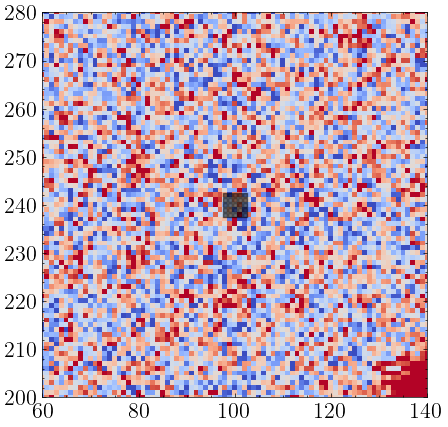

In [20]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(spec_cube[idx, :,:], origin='lower',
          vmin=-3, vmax=3, cmap='coolwarm')

ax.scatter(gal_x, gal_y, marker='s', 
           color='black', s=10, alpha=.5)

dwin = 40
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [21]:
# Get sigma of flux density
spec_samples = []

# Record spectra for each spaxel
for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]
    
    spec = spec_cube[:,y,x]
    spec_samples.append(spec[idx])
    
spec_samples = np.array(spec_samples)

In [22]:
cdf_1sig = 0.8413

(array([1., 0., 1., 3., 4., 9., 3., 3., 0., 1.]),
 array([-5.4728303 , -4.473776  , -3.474722  , -2.4756677 , -1.4766135 ,
        -0.47755933,  0.52149487,  1.520549  ,  2.5196033 ,  3.5186574 ,
         4.5177116 ], dtype=float32),
 <BarContainer object of 10 artists>)

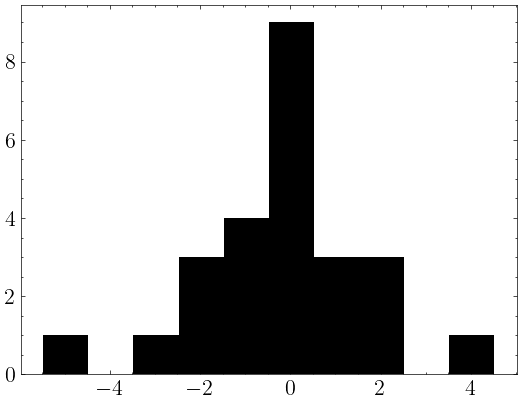

In [23]:
plt.hist(spec_samples)

In [24]:
np.std(spec_samples)*np.sqrt(len(gal_x))

9.415435194969177

# Limiting magnitude

In [25]:
x0, y0 = 270, 130
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 0*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/2.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/2.5)**2<1)

(90.0, 170.0)

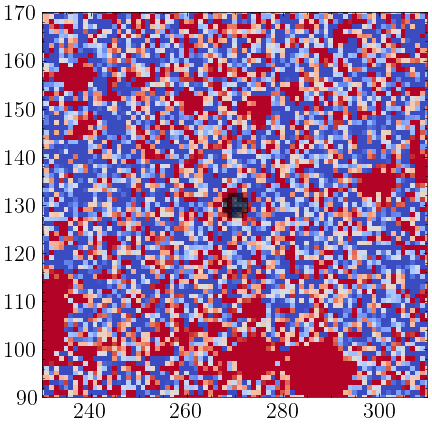

In [26]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(img_pseudo_r, origin='lower', vmin=-100, vmax=100,
          cmap='coolwarm')

ax.scatter(gal_x, gal_y, marker='s', 
           color='black', s=10, alpha=.5)

dwin = 40
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [27]:
# Pivot wavelength calculation
np.sqrt(.5*(7500**2 - 6000**2)/np.log(7500/6000)), .5*(7500+6000), np.sqrt((7500-6000)/(6000**-1 - 7500**-1))

(6736.050674687734, 6750.0, 6708.20393249937)

In [28]:
spec = []

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec.append(img_pseudo_r[y,x])

(array([1., 1., 2., 5., 2., 4., 0., 2., 2., 2.]),
 array([-270.66693 , -207.8182  , -144.96948 ,  -82.12075 ,  -19.272022,
          43.576706,  106.42543 ,  169.27415 ,  232.1229  ,  294.97162 ,
         357.82034 ], dtype=float32),
 <BarContainer object of 10 artists>)

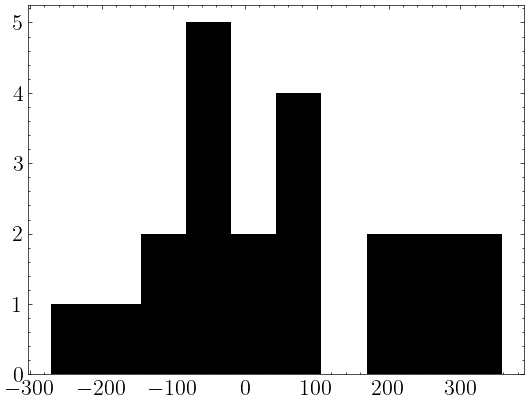

In [29]:
plt.hist(spec)

In [30]:
F = 5*np.std(spec)*np.sqrt(len(gal_x))

idx_pass = (wav_arr>=6000)&(wav_arr<=7500)
f_lam_ref = (3631/(3.34*1e4*wav_arr**2))/1e-20
F0 = np.sum(f_lam_ref[idx_pass])

In [31]:
-2.5*np.log10(F/F0)

27.18395728927573

# z=0.0966

## pseudo-g

In [32]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==122)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
idx = np.where((seg_map_gal_x-x0)**2+(seg_map_gal_y-y0)**2<20**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/3266762761.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/3266762761.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(255.56410256410254, 335.56410256410254)

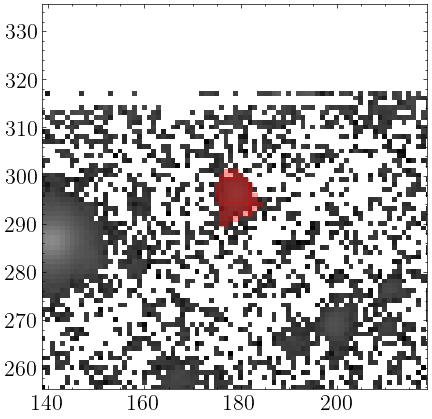

In [33]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 40
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1839520441.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1839520441.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(255.56410256410254, 335.56410256410254)

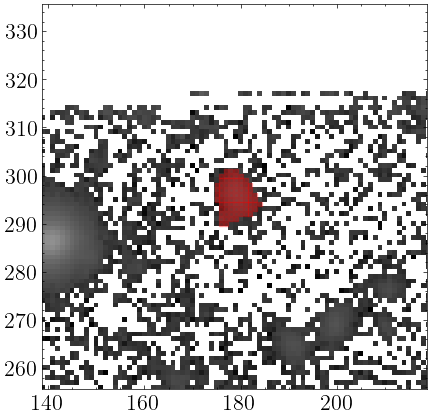

In [34]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 40
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2674588640.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2674588640.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(255.56410256410254, 335.56410256410254)

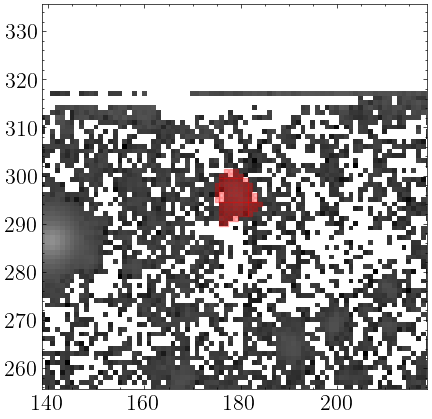

In [35]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 40
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [36]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [38]:
spec_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))
var_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))

for j in range(len(seg_map_gal_x[idx])):

    x = seg_map_gal_x[idx][j]
    y = seg_map_gal_y[idx][j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

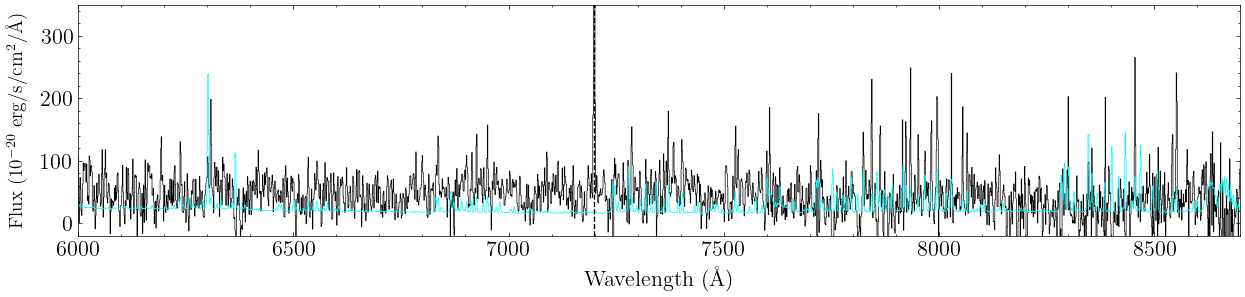

In [39]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(6564.61*(1+0.0966), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

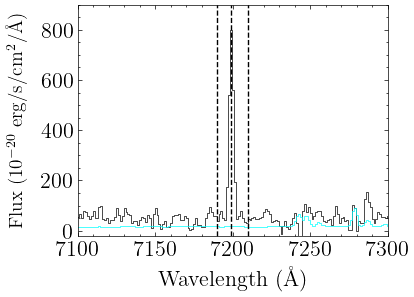

In [40]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.0966), linestyle='--')

ax.axvline(7190, linestyle='--')
ax.axvline(7210, linestyle='--')

ax.set_xlim(7100, 7300)
ax.set_ylim(-20, 900)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [41]:
idx = (wav_arr>=7190)&(wav_arr<=7210)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(3.5095699806135965, 0.0826501840279243)

In [42]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'])

(24.653, 0.023)

In [46]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'], 2)

(24.18, 0.02)

In [49]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'], 2)

(24.15, 0.04)

# z=0.1203

## pseudo-g

In [50]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==52)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)

In [51]:
flux_gal = np.zeros(len(seg_map_gal_x))

for i in range(len(seg_map_gal_x)):
    
    x = seg_map_gal_x[i]
    y = seg_map_gal_y[i]
    
    flux_gal[i] = np.nansum(spec_cube[:,y,x])

In [52]:
min_flux_gal = np.nanpercentile(flux_gal, 65)
max_flux_gal = np.nanpercentile(flux_gal, 100)

idx = (flux_gal>=min_flux_gal) & (flux_gal<=max_flux_gal)

In [53]:
#idx = np.where((seg_map_gal_x-x0)**2+(seg_map_gal_y-y0)**2<10**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/558162909.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/558162909.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(81.1439393939394, 281.1439393939394)

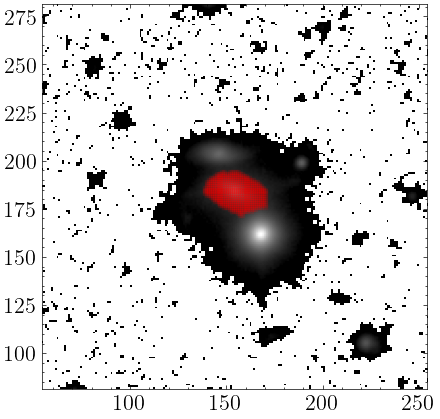

In [54]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
           vmin=3, vmax=7, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.1)

dwin = 100
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/188076315.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/188076315.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(111.1439393939394, 251.1439393939394)

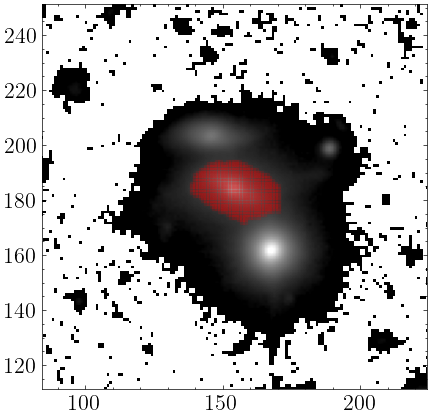

In [55]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
           vmin=3, vmax=7, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.1)

dwin = 70
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/973138010.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/973138010.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(111.1439393939394, 251.1439393939394)

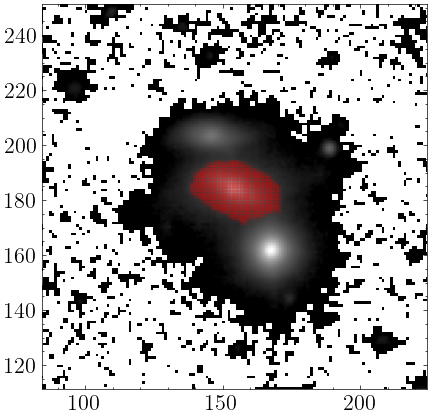

In [56]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
           vmin=3, vmax=7, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.1)

dwin = 70
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [57]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [58]:
spec_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))
var_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))

for j in range(len(seg_map_gal_x[idx])):

    x = seg_map_gal_x[idx][j]
    y = seg_map_gal_y[idx][j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

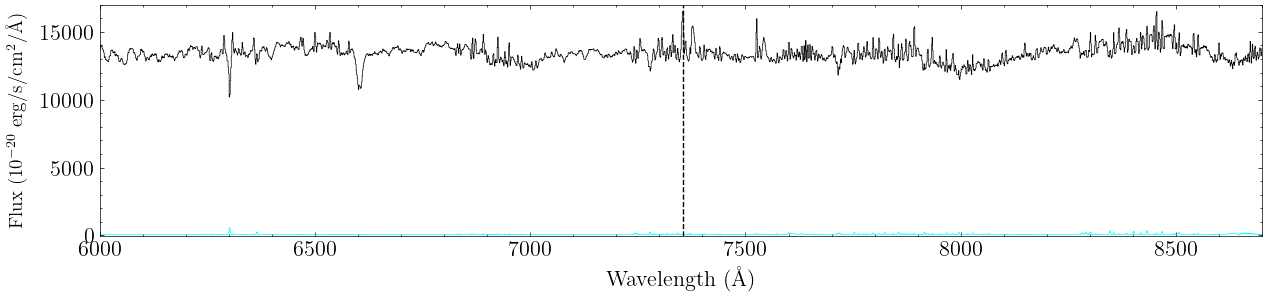

In [59]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(6564.61*(1+0.1203), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 17000)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

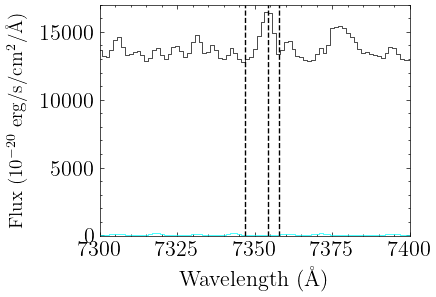

In [60]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.1203), linestyle='--')

ax.axvline(7347, linestyle='--')
ax.axvline(7358, linestyle='--')

ax.set_xlim(7300, 7400)
ax.set_ylim(-20, 17000)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [61]:
idx = (wav_arr>=7347)&(wav_arr<=7358)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(147.580086638378, 0.20590250601247095)

In [63]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],4)

(18.8587, 0.0003)

In [64]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],4)

(18.1284, 0.0002)

In [66]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],4)

(17.6973, 0.0003)

# z=0.1204

## pseudo-g

In [67]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==51)

In [68]:
flux_gal = np.zeros(len(seg_map_gal_x))

for i in range(len(seg_map_gal_x)):
    
    x = seg_map_gal_x[i]
    y = seg_map_gal_y[i]
    
    flux_gal[i] = np.nansum(spec_cube[:,y,x])

In [69]:
min_flux_gal = np.nanpercentile(flux_gal, 75)
max_flux_gal = np.nanpercentile(flux_gal, 100)

idx = (flux_gal>=min_flux_gal) & (flux_gal<=max_flux_gal)

In [70]:
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
#idx = np.where((seg_map_gal_x-x0)**2+(seg_map_gal_y-y0)**2<10**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2812414448.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2812414448.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(134.14015477214102, 274.14015477214105)

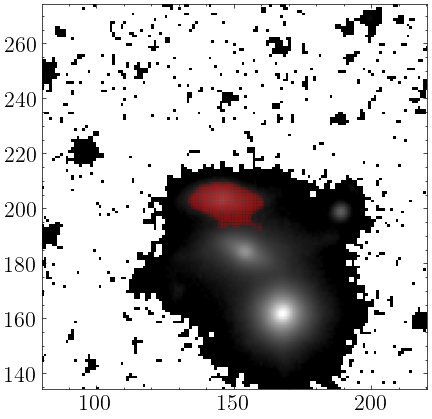

In [71]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
           vmin=3, vmax=7, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.1)

dwin = 70
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/188076315.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/188076315.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(134.14015477214102, 274.14015477214105)

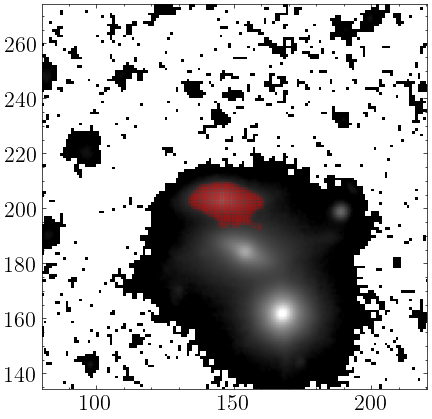

In [72]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
           vmin=3, vmax=7, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.1)

dwin = 70
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/973138010.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/973138010.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(134.14015477214102, 274.14015477214105)

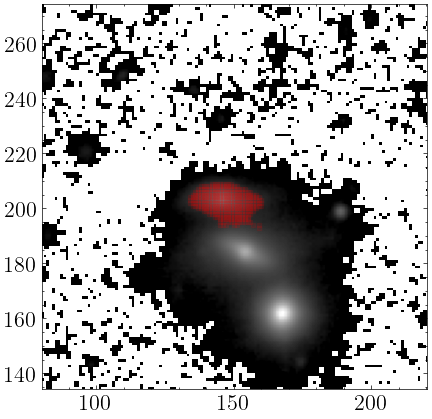

In [73]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
           vmin=3, vmax=7, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.1)

dwin = 70
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [74]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [75]:
spec_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))
var_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))

for j in range(len(seg_map_gal_x[idx])):

    x = seg_map_gal_x[idx][j]
    y = seg_map_gal_y[idx][j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

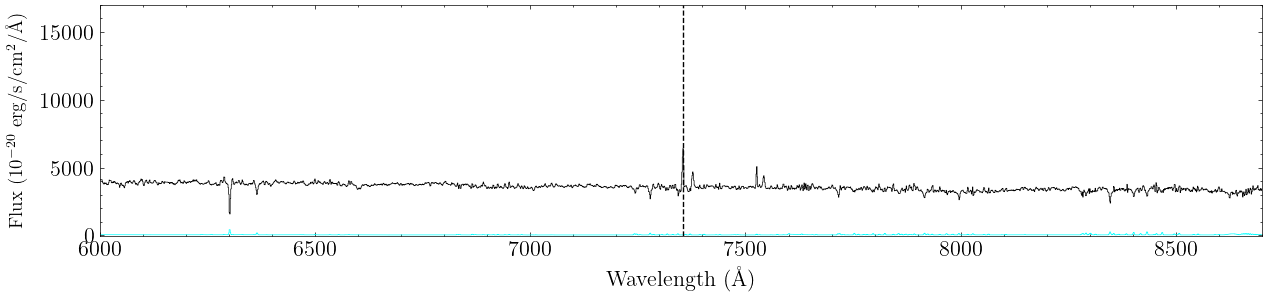

In [76]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(6564.61*(1+0.1204), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 17000)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

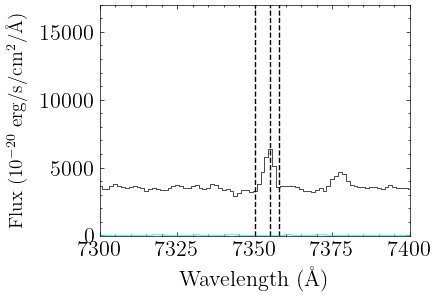

In [77]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.1204), linestyle='--')

ax.axvline(7350, linestyle='--')
ax.axvline(7358, linestyle='--')

ax.set_xlim(7300, 7400)
ax.set_ylim(-20, 17000)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [78]:
idx = (wav_arr>=7350)&(wav_arr<=7358)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(36.297051286920905, 0.11439458959720292)

In [82]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],4)

(20.0668, 0.0006)

In [83]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],4)

(19.5231, 0.0004)

In [85]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],4)

(19.2059, 0.0008)

# z=0.1264

## pseudo-g

In [86]:
x0, y0 = 150, 241
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 0*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/6)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/3)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(221.0, 261.0)

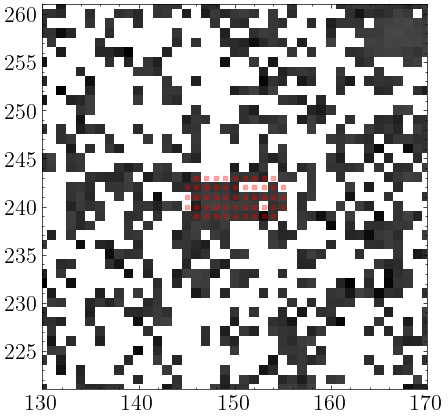

In [87]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(221.0, 261.0)

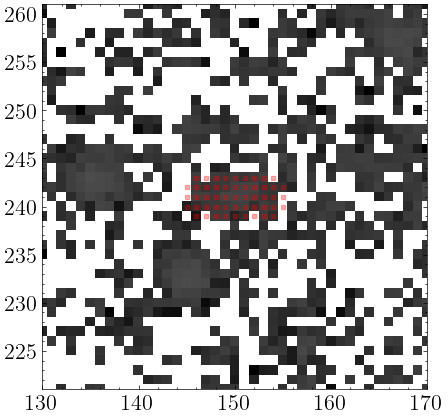

In [88]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(221.0, 261.0)

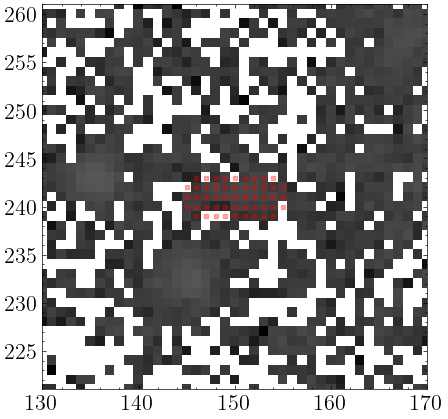

In [89]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [90]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [92]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

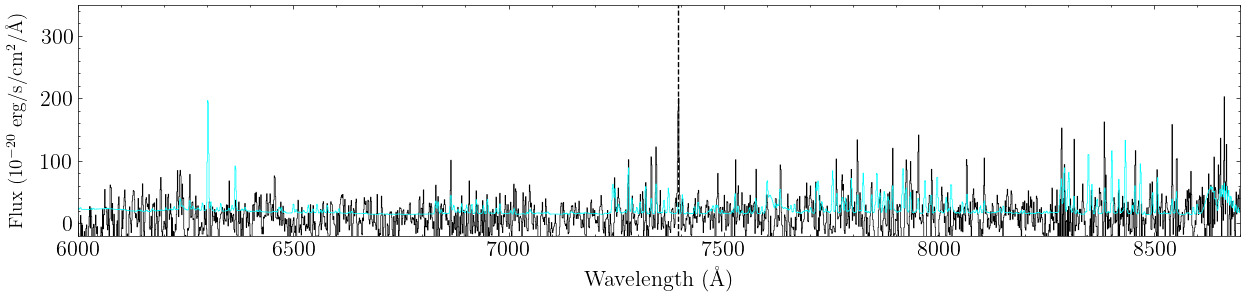

In [93]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(6564.61*(1+0.1264), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

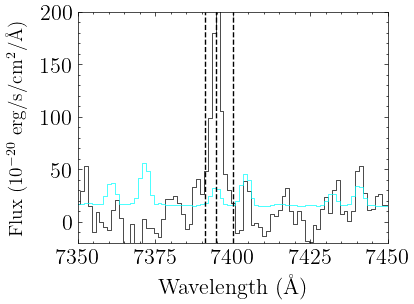

In [94]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.1264), linestyle='--')

ax.axvline(7391, linestyle='--')
ax.axvline(7400, linestyle='--')

ax.set_xlim(7350, 7450)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [95]:
idx = (wav_arr>=7391)&(wav_arr<=7400)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.8456308010290376, 0.07632130121136753)

In [99]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],1)

(26.7, 0.1)

In [100]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],1)

(26.3, 0.1)

In [101]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],1)

(25.5, 0.1)

# z=0.1335

## pseudo-g

In [102]:
x0, y0 = 242, 69
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 0*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/3)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/3)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2032114834.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2032114834.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(49.0, 89.0)

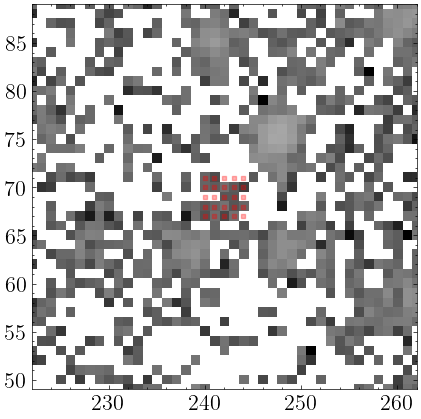

In [103]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=5, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(49.0, 89.0)

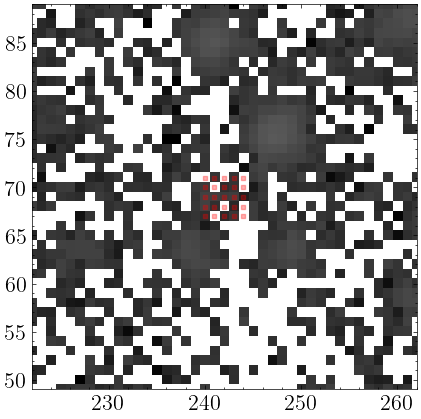

In [104]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(49.0, 89.0)

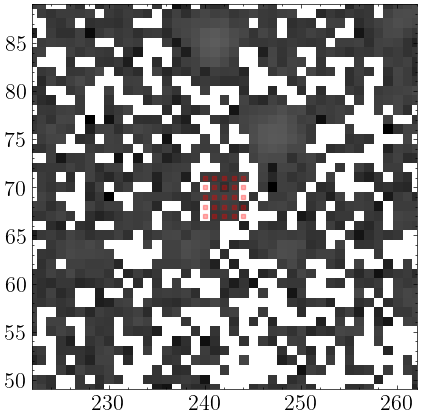

In [105]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [106]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [107]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

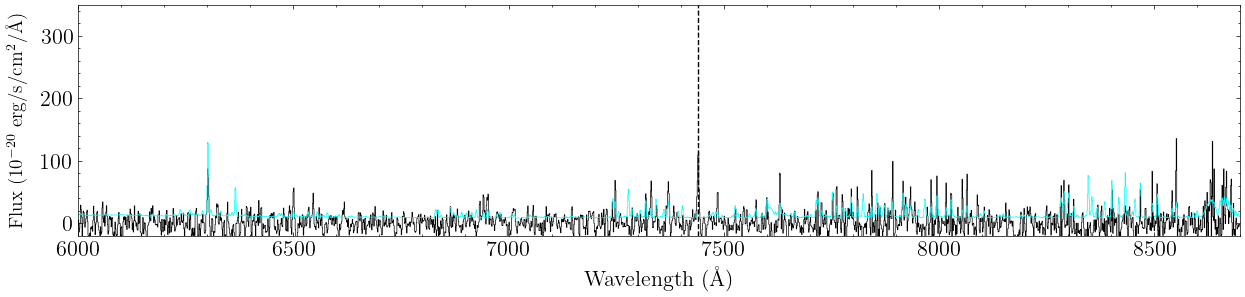

In [108]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(6564.61*(1+0.1335), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

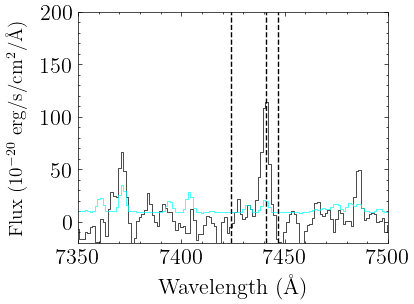

In [109]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.1335), linestyle='--')

ax.axvline(7424, linestyle='--')
ax.axvline(7447, linestyle='--')

ax.set_xlim(7350, 7500)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [110]:
idx = (wav_arr>=7424)&(wav_arr<=7447)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.63633187238127, 0.06649530219829526)

In [111]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],1)

(28.7, 0.5)

In [114]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],1)

(27.8, 0.2)

In [116]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],1)

(26.7, 0.2)

# z=0.1393

## pseudo-g

In [117]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==20)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
idx = np.where((seg_map_gal_x-x0)**2+(seg_map_gal_y-y0)**2<5**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1568320792.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1568320792.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(290.1714285714286, 330.1714285714286)

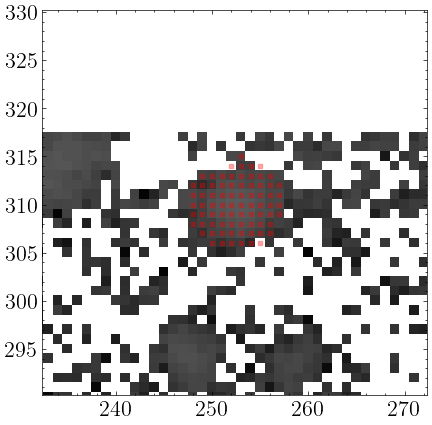

In [118]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1952758952.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1952758952.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(290.1714285714286, 330.1714285714286)

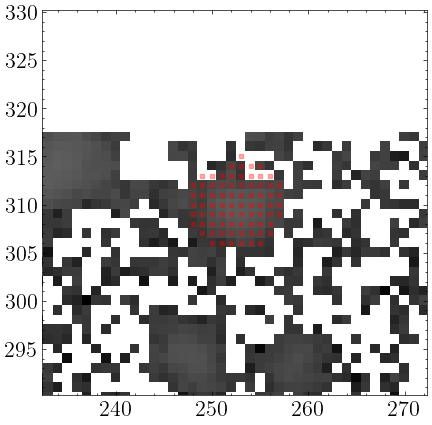

In [119]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/196516773.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/196516773.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(290.1714285714286, 330.1714285714286)

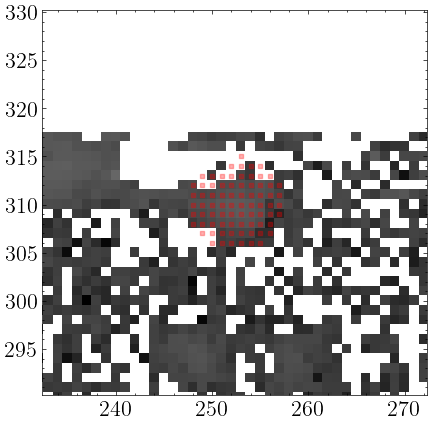

In [120]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [121]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [122]:
spec_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))
var_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))

for j in range(len(seg_map_gal_x[idx])):

    x = seg_map_gal_x[idx][j]
    y = seg_map_gal_y[idx][j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

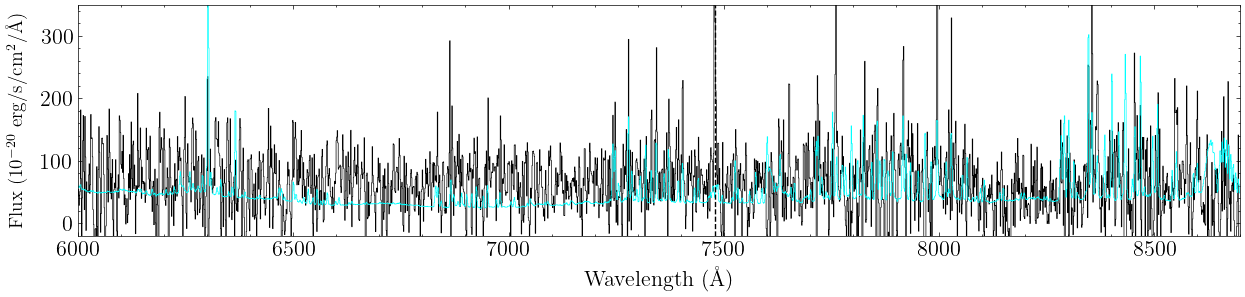

In [123]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(6564.61*(1+0.1393), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

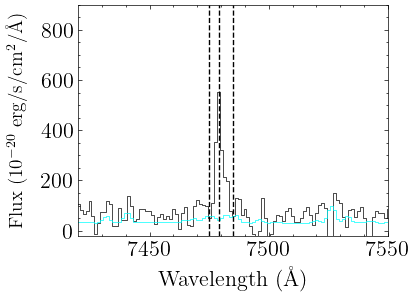

In [124]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.1393), linestyle='--')

ax.axvline(7475, linestyle='--')
ax.axvline(7485, linestyle='--')

ax.set_xlim(7420, 7550)
ax.set_ylim(-20, 900)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [125]:
idx = (wav_arr>=7475)&(wav_arr<=7485)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(2.24739376762358, 0.1807433262705251)

In [129]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'], 2)

(24.13, 0.02)

In [130]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'], 2)

(23.89, 0.02)

In [131]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'], 2)

(23.58, 0.04)

# z=0.2791

## pseudo-g

In [132]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==82)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
#idx = np.where((seg_map_gal_x-x0+1)**2+(seg_map_gal_y-y0)**2<5**2)

In [133]:
spec_cube.shape

(3682, 319, 337)

In [134]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==82)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 55*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/6)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/4)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(78.71153846153847, 118.71153846153847)

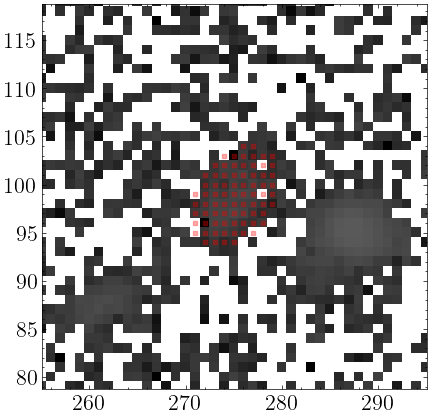

In [135]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(78.71153846153847, 118.71153846153847)

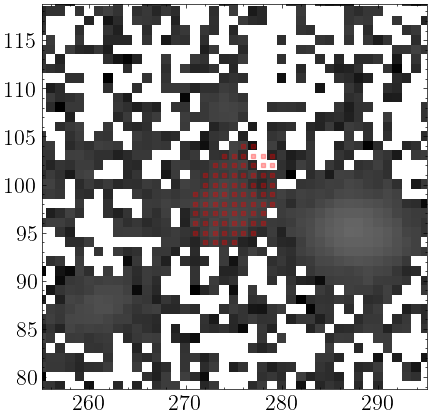

In [136]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(78.71153846153847, 118.71153846153847)

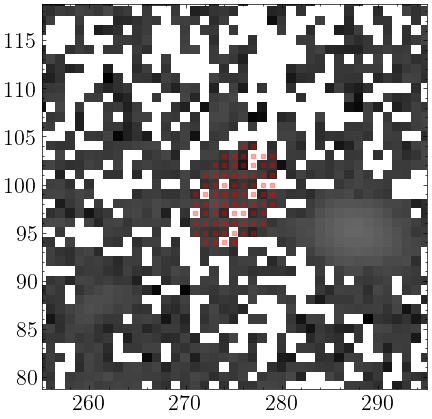

In [137]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [138]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [139]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

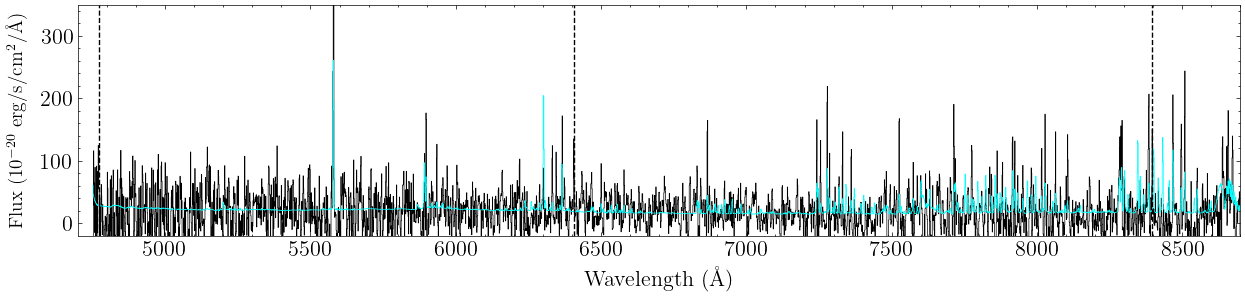

In [140]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.2791), linestyle='--')
ax.axvline(6564.61*(1+0.2791), linestyle='--')
ax.axvline(5008.24*(1+0.2791), linestyle='--')

#ax.axvline(3729*(1+0.2791), linestyle='--')

ax.set_xlim(4700, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

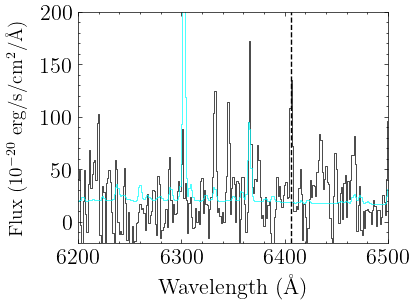

In [141]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(5008.24*(1+0.2791), linestyle='--')

#ax.axvline(8370, linestyle='--')
#ax.axvline(8405, linestyle='--')

ax.set_xlim(6200, 6500)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

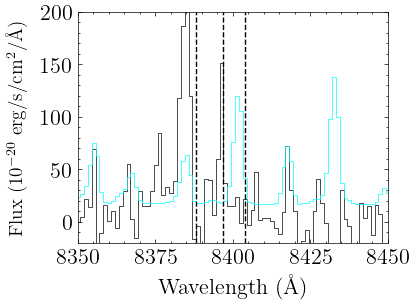

In [142]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.2791), linestyle='--')

ax.axvline(8388, linestyle='--')
ax.axvline(8404, linestyle='--')

ax.set_xlim(8350, 8450)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [143]:
idx = (wav_arr>=8388)&(wav_arr<=8404)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.43839379525597905, 0.23410201370304623)

In [147]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(25.7, 0.05)

In [148]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(25.25, 0.04)

In [146]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(25.11, 0.09)

# z=0.2915

## pseudo-g

In [149]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==96)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = -40*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/4)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/2.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(43.56521739130435, 83.56521739130434)

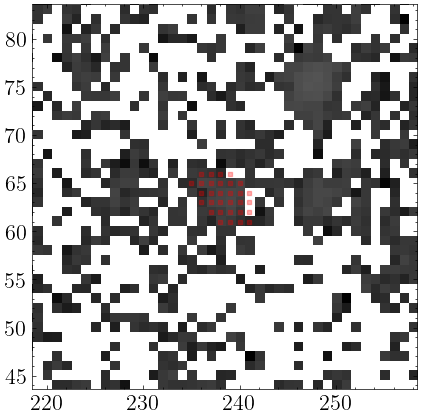

In [150]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(43.56521739130435, 83.56521739130434)

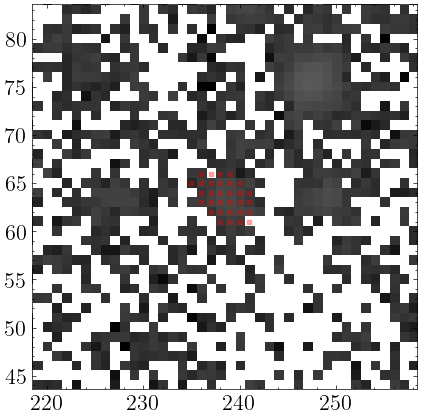

In [151]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(43.56521739130435, 83.56521739130434)

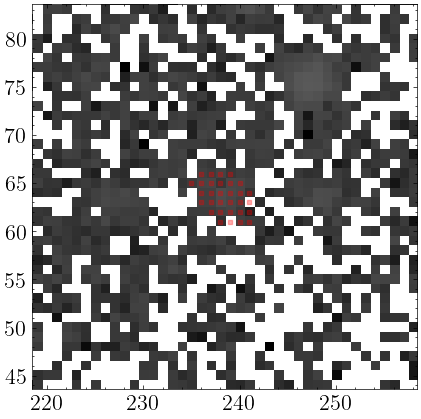

In [152]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [153]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [154]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

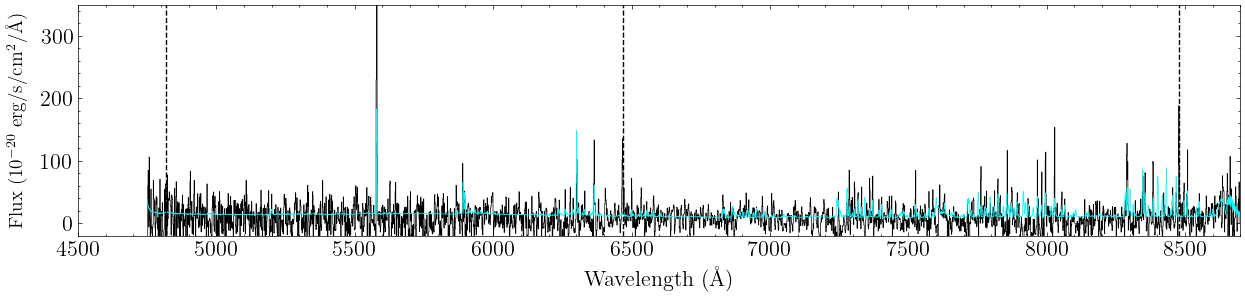

In [155]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(5008.24*(1+0.2915), linestyle='--')
ax.axvline(6564.61*(1+0.2915), linestyle='--')
ax.axvline(3729.87*(1+0.2915), linestyle='--')

ax.set_xlim(4500, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

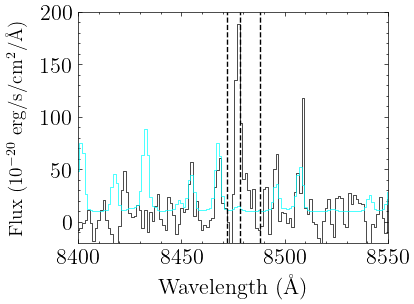

In [156]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.2915), linestyle='--')

ax.axvline(8472, linestyle='--')
ax.axvline(8488, linestyle='--')

ax.set_xlim(8400, 8550)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [157]:
idx = (wav_arr>=8472)&(wav_arr<=8488)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.718089963668026, 0.050468960837611744)

In [158]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(26.49, 0.07)

In [161]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(26.15, 0.06)

In [162]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(25.5, 0.08)

# z=0.3198

## pseudo-g

In [163]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==80)
x0, y0 = np.mean(seg_map_gal_x)+1, np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 19*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/10)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/4)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(89.1, 129.1)

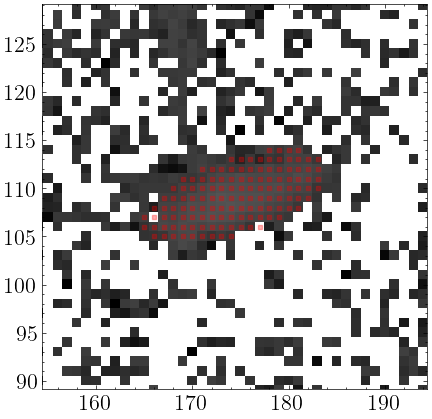

In [164]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(89.1, 129.1)

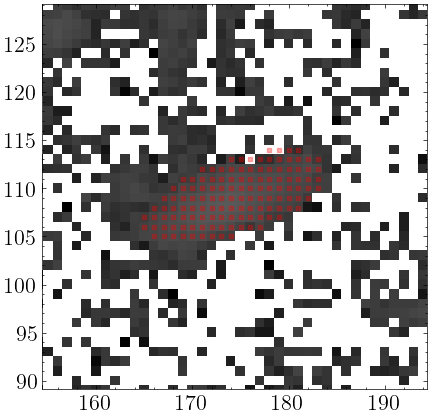

In [165]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(89.1, 129.1)

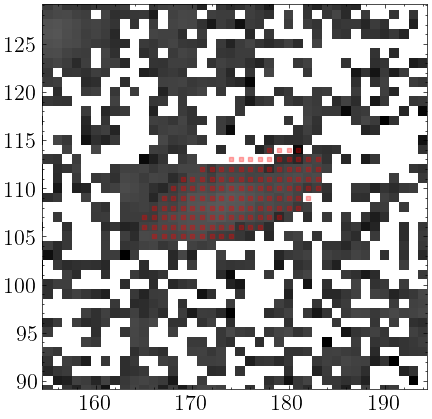

In [166]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [167]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [168]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

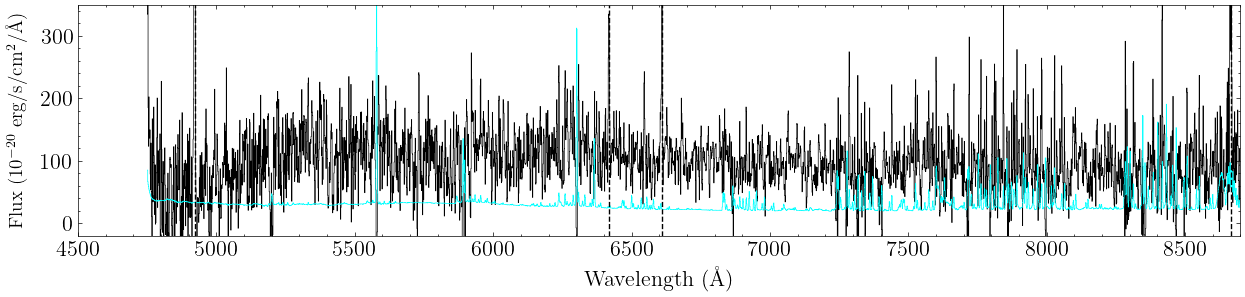

In [169]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.3198), linestyle='--')
ax.axvline(4862.68*(1+0.3198), linestyle='--')
ax.axvline(5008.24*(1+0.3198), linestyle='--')
ax.axvline(6564.61*(1+0.3198), linestyle='--')

ax.set_xlim(4500, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

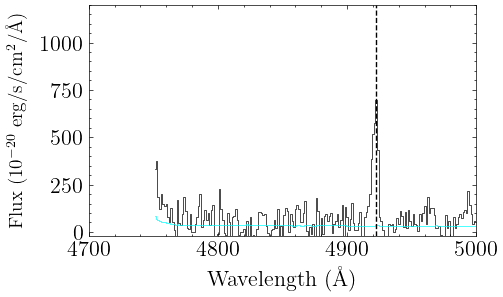

In [170]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.3198), linestyle='--')

ax.axvline(5008*(1+0.3198), linestyle='--')
ax.axvline(6562.819*(1+0.3198), linestyle='--')

ax.set_xlim(4700, 5000)
ax.set_ylim(-20, 1200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

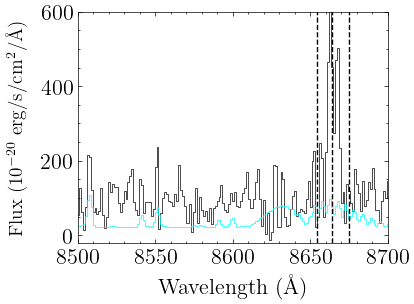

In [171]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.3198), linestyle='--')

ax.axvline(8654, linestyle='--')
ax.axvline(8675, linestyle='--')

ax.set_xlim(8500, 8700)
ax.set_ylim(-20, 600)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [172]:
idx = (wav_arr>=8654)&(wav_arr<=8675)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(5.285643168989264, 0.3685067463307254)

In [174]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(24.01, 0.02)

In [175]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(23.43, 0.01)

In [176]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(23.13, 0.02)

# z=0.3286

## pseudo-g

In [177]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==79)
x0, y0 = np.mean(seg_map_gal_x)-2, np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 19*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/4)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/4)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/204327804.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/204327804.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(54.96913580246914, 154.96913580246914)

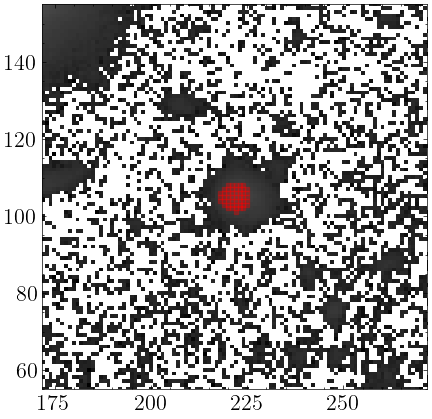

In [178]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=15, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 50
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(84.96913580246914, 124.96913580246914)

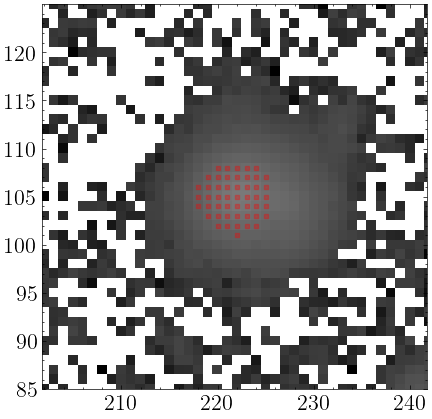

In [179]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(84.96913580246914, 124.96913580246914)

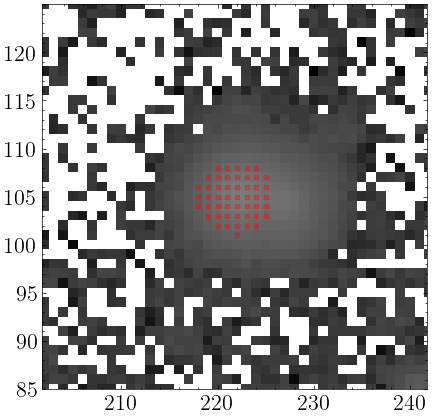

In [180]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [181]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [182]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

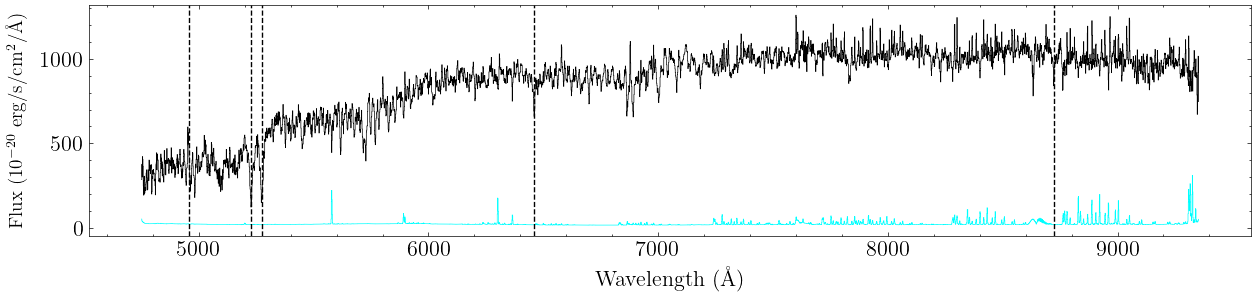

In [183]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.3286), linestyle='--')

ax.axvline(3934.78*(1+0.3286), linestyle='--')
ax.axvline(3969.59*(1+0.3286), linestyle='--')


ax.axvline(4862.68*(1+0.3286), linestyle='--')
#ax.axvline(5008.24*(1+0.3286), linestyle='--')
ax.axvline(6564.61*(1+0.3286), linestyle='--')

#ax.set_xlim(4500, 8700)
#ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

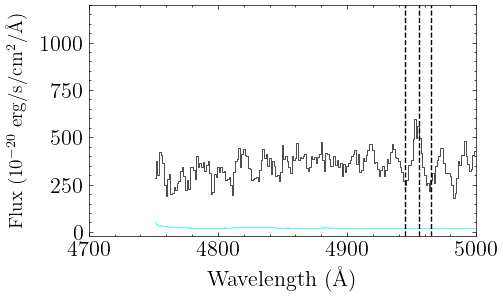

In [184]:
fig, ax = plt.subplots(1, figsize=(5,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.3286), linestyle='--')

ax.axvline(4945, linestyle='--')
ax.axvline(4965, linestyle='--')

ax.set_xlim(4700, 5000)
ax.set_ylim(-20, 1200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [185]:
idx = (wav_arr>=4945)&(wav_arr<=4965)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(7.280123032886477, 0.10268386380879199)

In [189]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],3)

(22.21, 0.002)

In [190]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],4)

(21.0403, 0.0007)

In [191]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],3)

(20.485, 0.001)

# z=0.3752

## pseudo-g

In [192]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==94)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 30*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/6)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/4)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(47.55172413793103, 87.55172413793103)

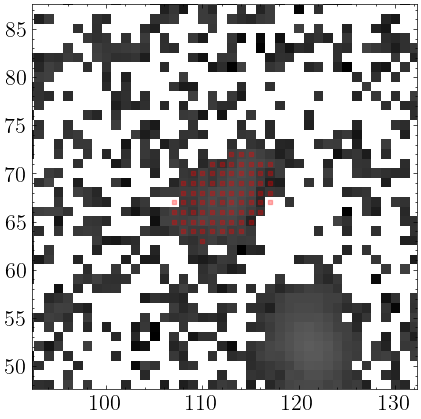

In [193]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(47.55172413793103, 87.55172413793103)

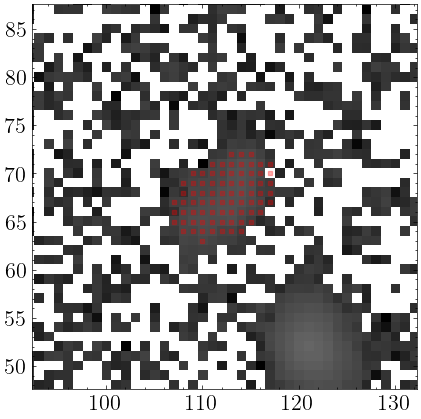

In [194]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(47.55172413793103, 87.55172413793103)

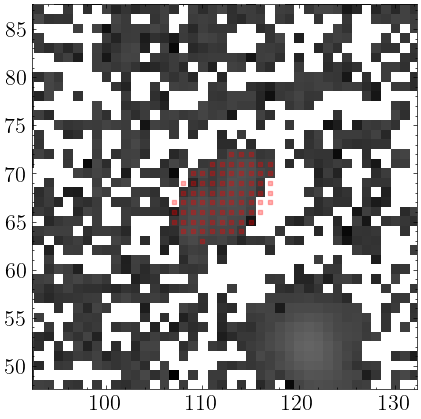

In [195]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [196]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [197]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

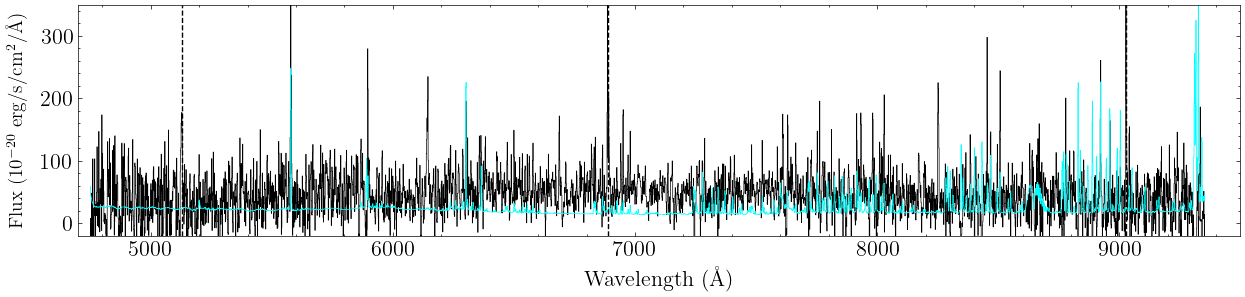

In [198]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.3752), linestyle='--')
ax.axvline(6564.61*(1+0.3752), linestyle='--')
ax.axvline(5008.24*(1+0.3752), linestyle='--')

ax.set_xlim(4700, 9500)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

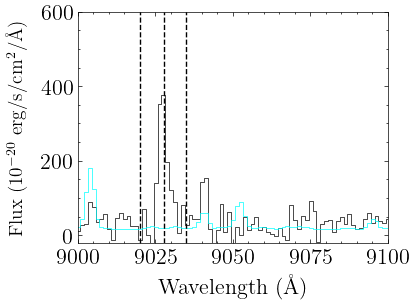

In [199]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.3752), linestyle='--')

ax.axvline(9020, linestyle='--')
ax.axvline(9035, linestyle='--')

ax.set_xlim(9000, 9100)
ax.set_ylim(-20, 600)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [200]:
idx = (wav_arr>=9020)&(wav_arr<=9035)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(1.633573147929128, 0.0894845719325305)

In [204]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'], 2)

(24.9, 0.02)

In [205]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'], 2)

(24.15, 0.01)

In [206]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'], 2)

(23.98, 0.03)

# z=0.3759

## pseudo-g

In [207]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==65)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)+4
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = -20*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/3)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/2)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/955538099.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/955538099.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(137.1, 177.1)

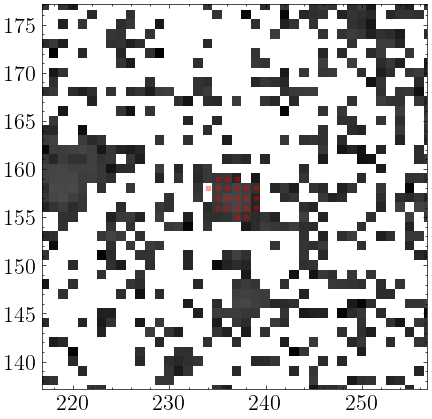

In [208]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
#ax.scatter(gal_x, gal_y, marker='s', 
#           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/361950707.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/361950707.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(137.1, 177.1)

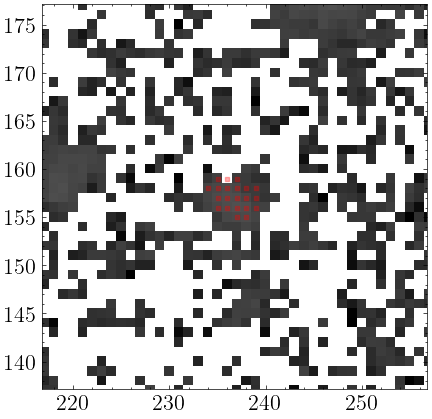

In [209]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')
ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4172510383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4172510383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(137.1, 177.1)

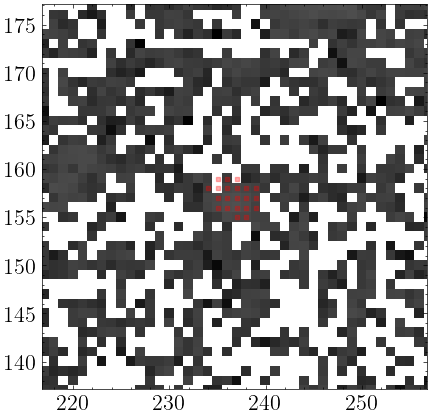

In [210]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')
ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [211]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [212]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

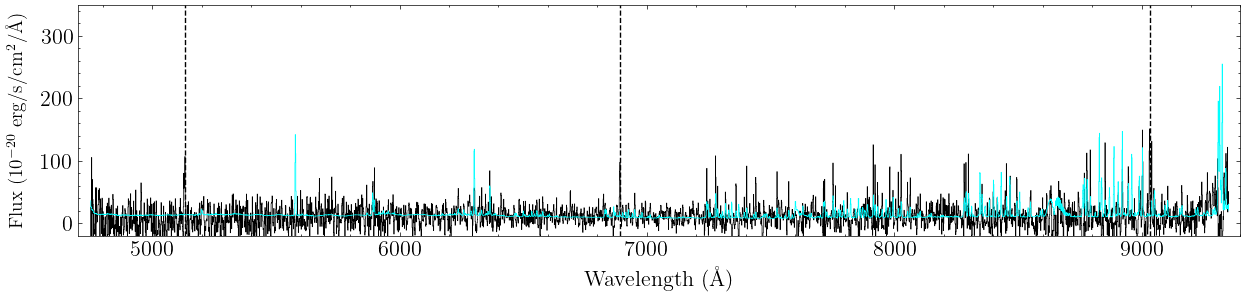

In [213]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(6564.61*(1+0.3759), linestyle='--')
ax.axvline(3729.87*(1+0.3759), linestyle='--')
ax.axvline(5008.24*(1+0.3759), linestyle='--')
#ax.axvline(6564*(1+0.3752), linestyle='--')

ax.set_xlim(4700, 9400)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

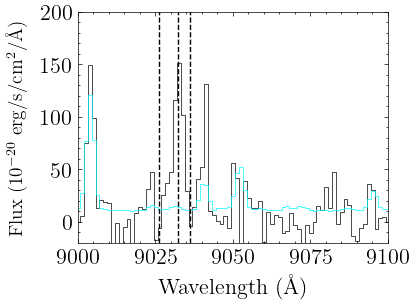

In [214]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(6564.61*(1+0.3759), linestyle='--')

ax.axvline(9026, linestyle='--')
ax.axvline(9036, linestyle='--')

ax.set_xlim(9000, 9100)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [26]:
idx = (wav_arr>=9026)&(wav_arr<=9036)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

NameError: name 'spec_gal' is not defined

In [216]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(26.92, 0.09)

In [218]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(25.78, 0.04)

In [219]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(25.46, 0.07)

# z=0.4395

## pseudo-g

In [220]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==103)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = -20*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/4.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/3.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(15.170731707317074, 55.170731707317074)

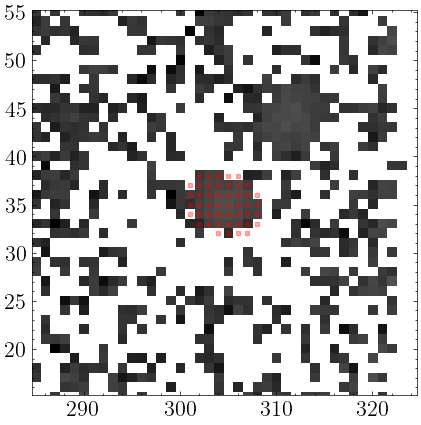

In [221]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(15.170731707317074, 55.170731707317074)

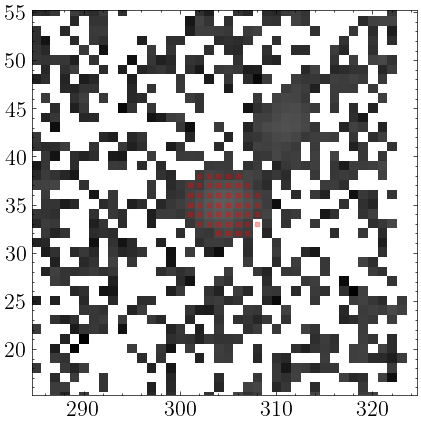

In [222]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(15.170731707317074, 55.170731707317074)

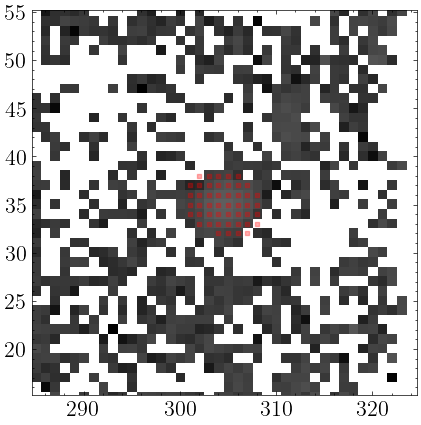

In [223]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [224]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [227]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

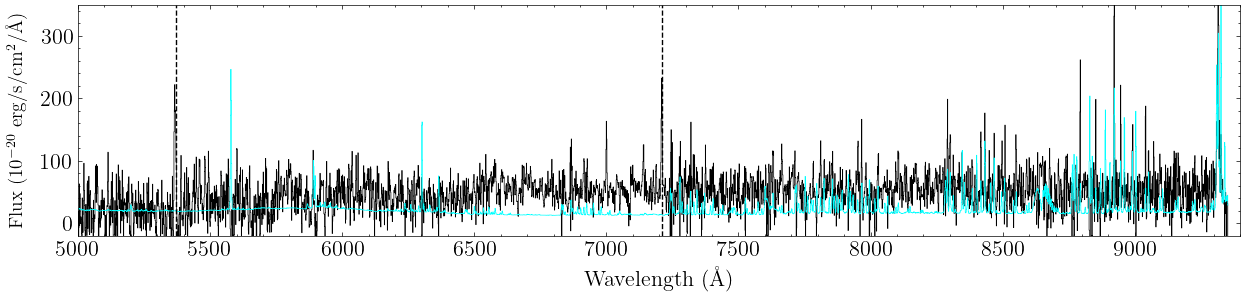

In [228]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.4395), linestyle='--')
ax.axvline(5008.24*(1+0.4395), linestyle='--')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

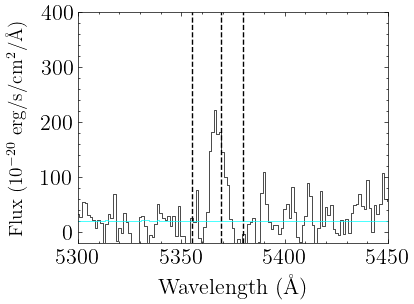

In [229]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.4395), linestyle='--')

ax.axvline(5355, linestyle='--')
ax.axvline(5380, linestyle='--')

ax.set_xlim(5300, 5450)
ax.set_ylim(-20, 400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [230]:
idx = (wav_arr>=5355)&(wav_arr<=5380)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(1.6789495068223914, 0.10618560386993121)

In [232]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(25.48, 0.04)

In [234]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(24.21, 0.01)

In [236]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(23.7, 0.02)

# z=0.4581

## pseudo-g

In [237]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==2)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)-1
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 35*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/6)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(3.937984496124031, 43.93798449612403)

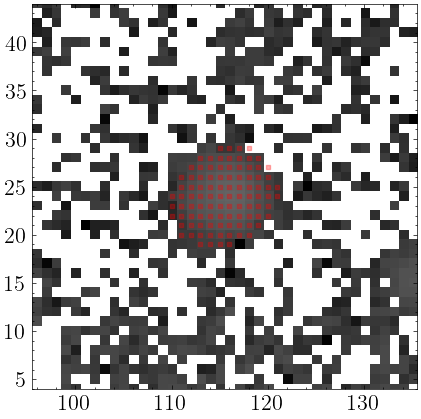

In [238]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(3.937984496124031, 43.93798449612403)

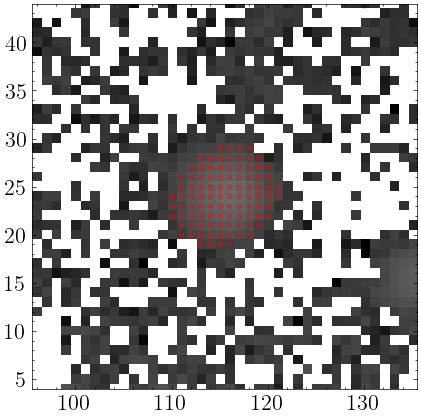

In [239]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(3.937984496124031, 43.93798449612403)

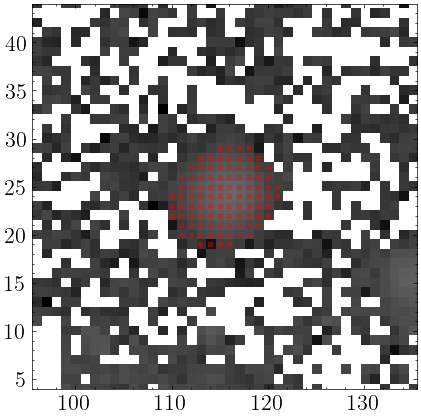

In [240]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [241]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [242]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

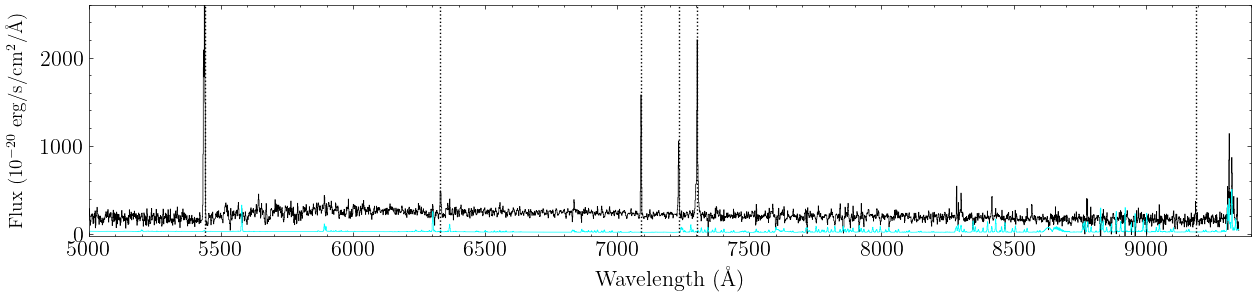

In [243]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.4581), linestyle=':')
#ax.axvline(3889.0*(1+0.4581), linestyle=':')
#ax.axvline(3934.78*(1+0.4581), linestyle=':')
#ax.axvline(4102.89*(1+0.4581), linestyle=':')
#ax.axvline(4305.61*(1+0.4581), linestyle=':')
ax.axvline(4341.68*(1+0.4581), linestyle=':')
ax.axvline(4862.68*(1+0.4581), linestyle=':')
ax.axvline(4960.30*(1+0.4581), linestyle=':')
ax.axvline(5008.24*(1+0.4581), linestyle=':')
#ax.axvline(5176.7*(1+0.4581), linestyle=':')
#ax.axvline(5895.6*(1+0.4581), linestyle=':')
ax.axvline(6302.05*(1+0.4581), linestyle=':')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 2600)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

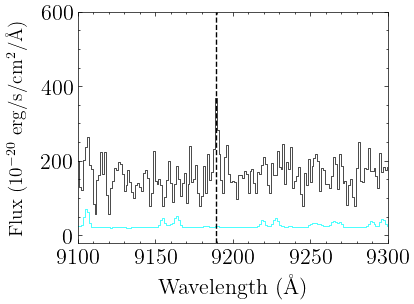

In [244]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(6302.05*(1+0.4581), linestyle='--')

ax.set_xlim(9100, 9300)
ax.set_ylim(-20, 600)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

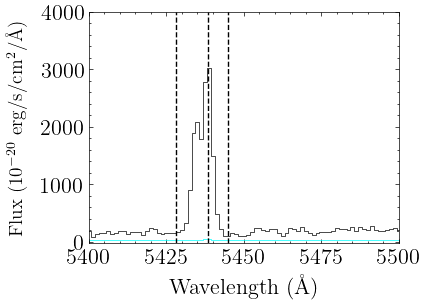

In [245]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.4581), linestyle='--')

ax.axvline(5428, linestyle='--')
ax.axvline(5445, linestyle='--')

ax.set_xlim(5400, 5500)
ax.set_ylim(-20, 4000)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [246]:
idx = (wav_arr>=5428)&(wav_arr<=5445)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(19.177795705160243, 0.13854734781784084)

In [247]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],3)

(23.125, 0.006)

In [248]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],3)

(22.453, 0.004)

In [249]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],3)

(22.341, 0.008)

# z=0.4784

## pseudo-g

In [250]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==19)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 30*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/7)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(293.0827586206897, 333.0827586206897)

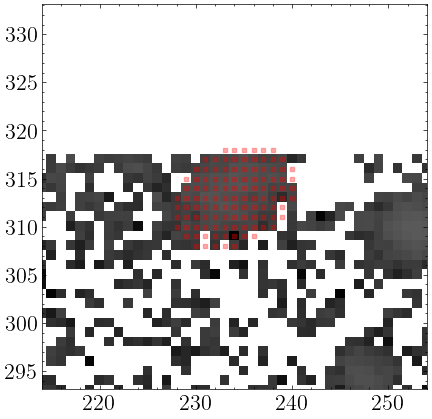

In [251]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(293.0827586206897, 333.0827586206897)

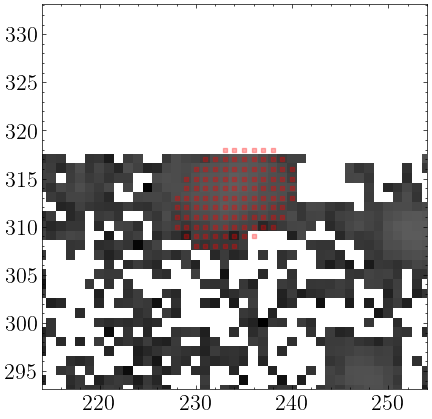

In [252]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(293.0827586206897, 333.0827586206897)

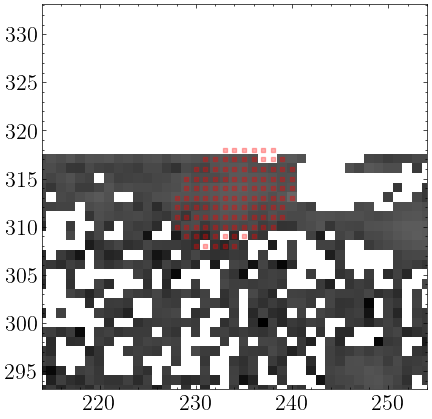

In [253]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [254]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [255]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

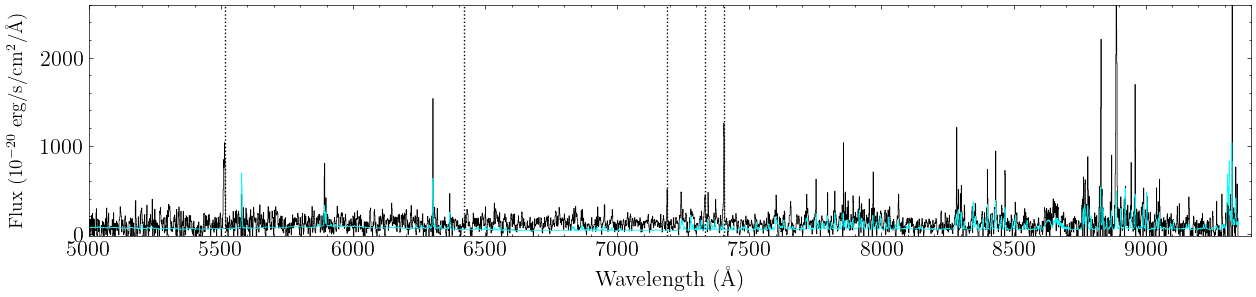

In [256]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.4784), linestyle=':')
ax.axvline(4341.68*(1+0.4784), linestyle=':')
ax.axvline(4862.68*(1+0.4784), linestyle=':')
ax.axvline(4960.30*(1+0.4784), linestyle=':')
ax.axvline(5008.24*(1+0.4784), linestyle=':')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 2600)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

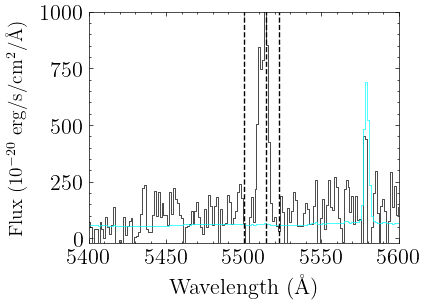

In [257]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.4784), linestyle='--')

ax.axvline(5500, linestyle='--')
ax.axvline(5523, linestyle='--')

ax.set_xlim(5400, 5600)
ax.set_ylim(-20, 1000)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [258]:
idx = (wav_arr>=5500)&(wav_arr<=5523)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(7.652944402866269, 0.3244527419926408)

In [260]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(23.96, 0.03)

In [261]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(23.17, 0.02)

In [262]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(22.58, 0.02)

# z=0.5191

## pseudo-g

In [389]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==72)
x0, y0 = np.mean(seg_map_gal_x)+1.75, np.mean(seg_map_gal_y)-1
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 90*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/3)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(85.47674418604652, 125.47674418604652)

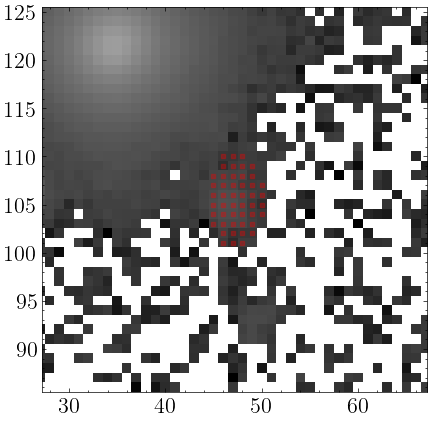

In [390]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(85.47674418604652, 125.47674418604652)

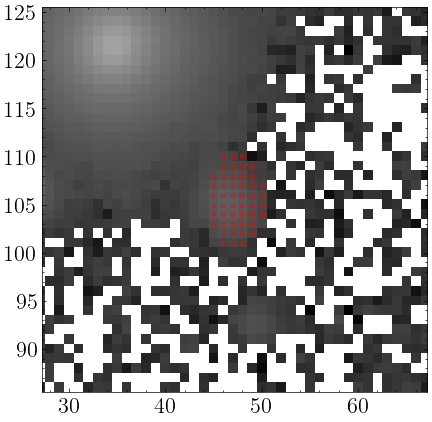

In [391]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(85.47674418604652, 125.47674418604652)

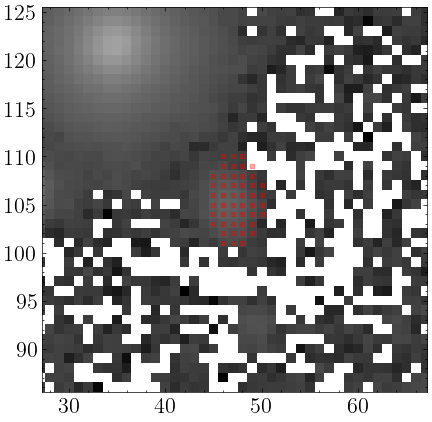

In [392]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [393]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [395]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

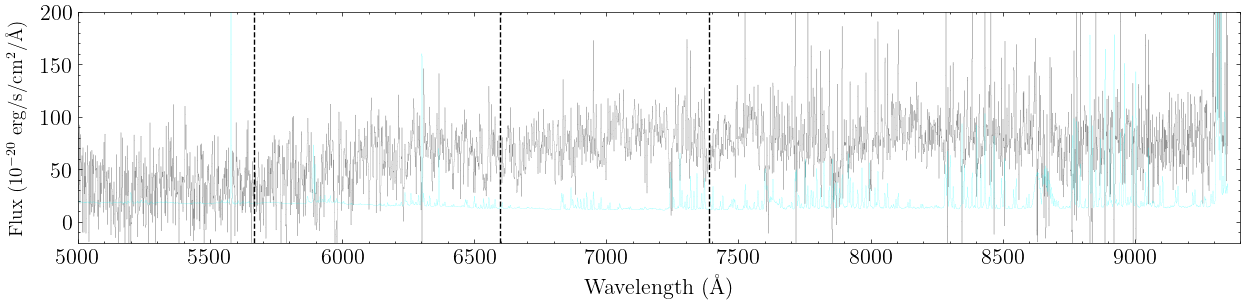

In [396]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.1)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.1)

ax.axvline(3729.87*(1+0.5191), linestyle='--')
ax.axvline(4341.68*(1+0.5191), linestyle='--')
ax.axvline(4862.68*(1+0.5191), linestyle='--')
#ax.axvline(4960.30*(1+0.5191), linestyle='--')
#ax.axvline(5008.24*(1+0.5191), linestyle='--')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

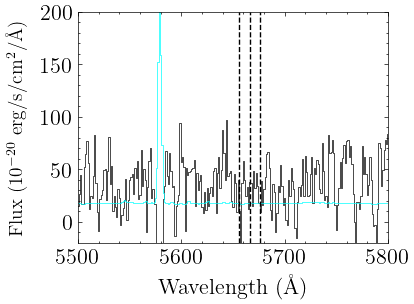

In [397]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.5191), linestyle='--')

ax.axvline(5656, linestyle='--')
ax.axvline(5676, linestyle='--')

ax.set_xlim(5500, 5800)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [398]:
idx = (wav_arr>=5656)&(wav_arr<=5676)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.556411534169456, 0.08530399878383094)

In [402]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(25.3, 0.03)

In [403]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(23.81, 0.01)

In [406]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(23.28, 0.01)

# z=0.5205

## pseudo-g

In [407]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==83)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)+.5
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 0*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/7)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(75.2927927927928, 115.2927927927928)

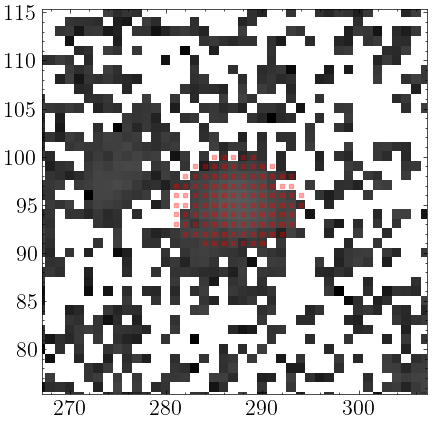

In [408]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(75.2927927927928, 115.2927927927928)

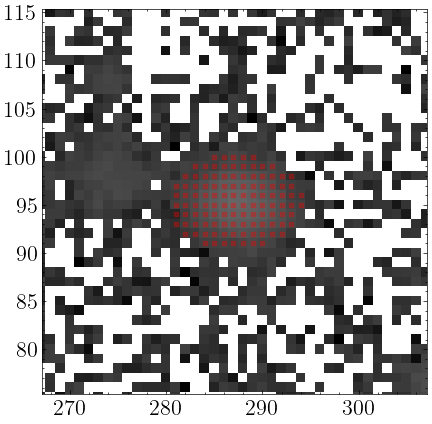

In [409]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(75.2927927927928, 115.2927927927928)

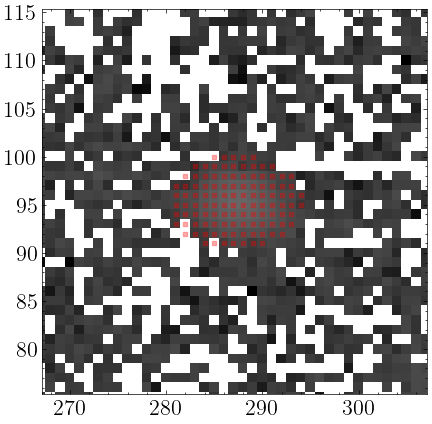

In [410]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [230]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [411]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

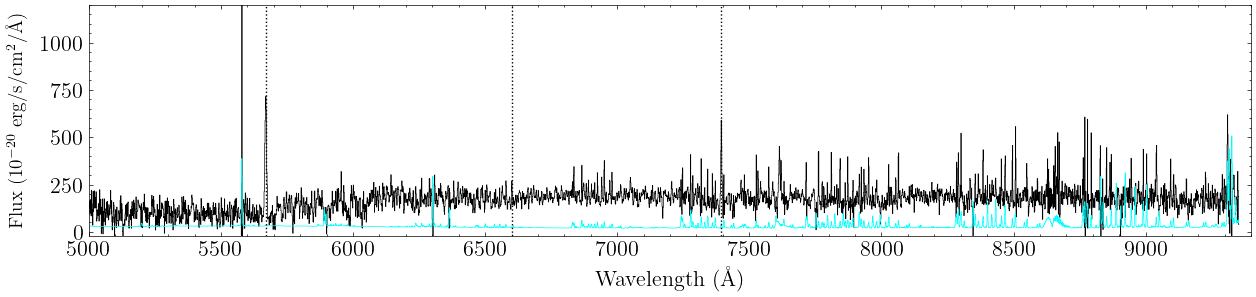

In [412]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.5205), linestyle=':')
ax.axvline(4341.68*(1+0.5205), linestyle=':')
ax.axvline(4862.68*(1+0.5205), linestyle=':')
#ax.axvline(4960.30*(1+0.5191), linestyle='--')
#ax.axvline(5008.24*(1+0.5191), linestyle='--')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 1200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

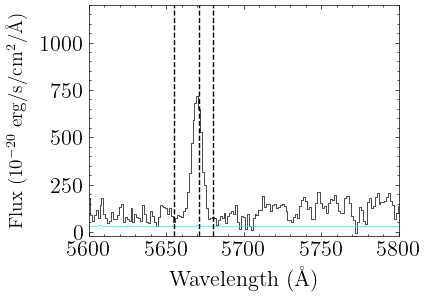

In [413]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.5205), linestyle='--')

ax.axvline(5655, linestyle='--')
ax.axvline(5680, linestyle='--')

ax.set_xlim(5600, 5800)
ax.set_ylim(-20, 1200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [415]:
idx = (wav_arr>=5655)&(wav_arr<=5680)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(6.906884276126512, 0.17408398020785482)

In [419]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(23.89, 0.01)

In [417]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],3)

(22.791, 0.005)

In [421]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],3)

(22.334, 0.009)

# z=0.5257

## pseudo-g

In [422]:
x0, y0 = 275, 309
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 0*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/3)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/3)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2032114834.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2032114834.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(289.0, 329.0)

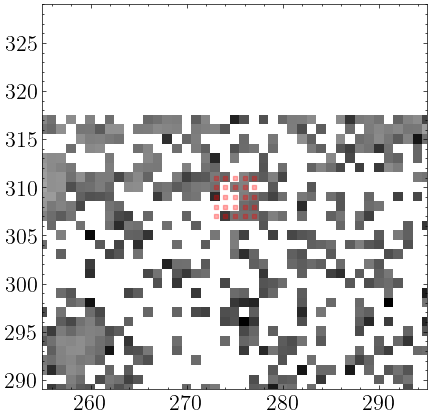

In [423]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=5, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(289.0, 329.0)

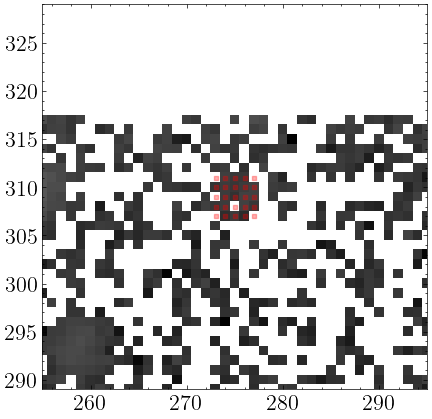

In [424]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(289.0, 329.0)

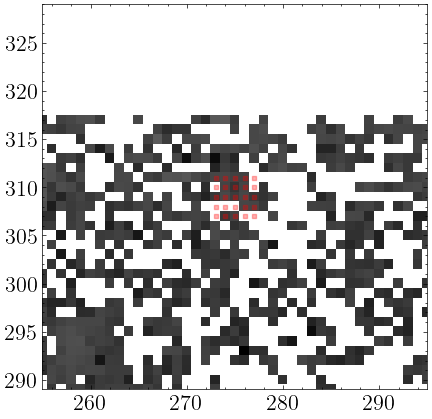

In [425]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [426]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [429]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

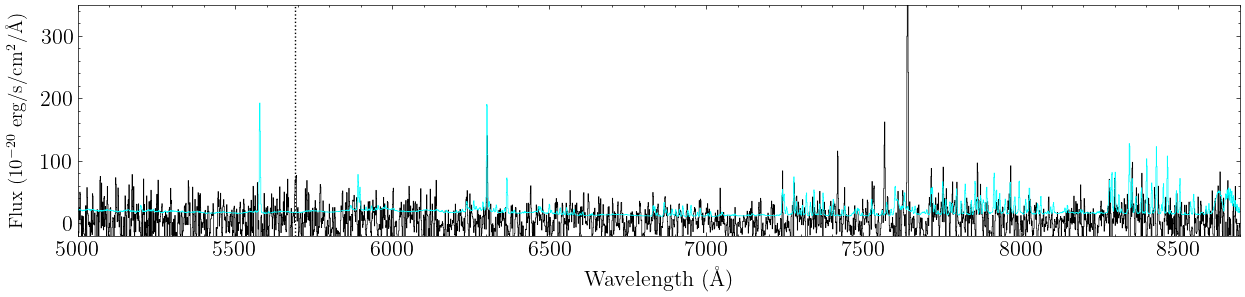

In [430]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(3729.87*(1+0.5257), linestyle=':')

ax.set_xlim(5000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

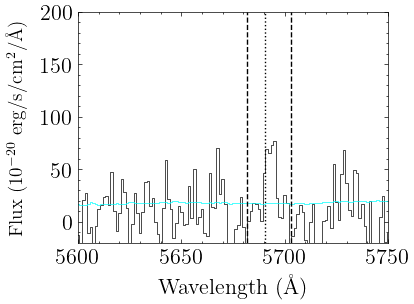

In [431]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.5257), linestyle=':')

ax.axvline(5682, linestyle='--')
ax.axvline(5703, linestyle='--')

ax.set_xlim(5600, 5750)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [432]:
idx = (wav_arr>=5682)&(wav_arr<=5703)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.5764466669363901, 0.08784629710164338)

In [434]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],1)

(28.0, 0.4)

In [436]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],1)

(27.2, 0.2)

In [438]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],1)

(26.6, 0.3)

# z=0.5356

## pseudo-g

In [439]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==1)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 0*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/10)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/8)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(8.182352941176472, 48.182352941176475)

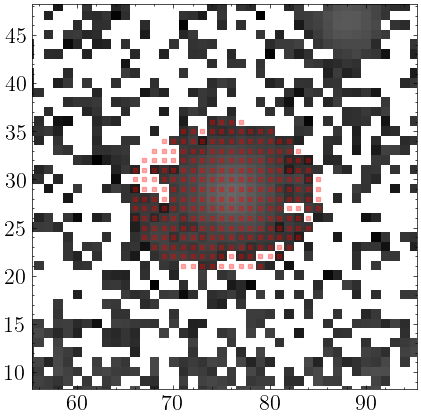

In [440]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(8.182352941176472, 48.182352941176475)

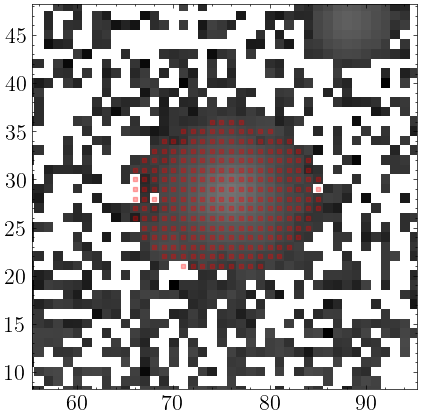

In [441]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(8.182352941176472, 48.182352941176475)

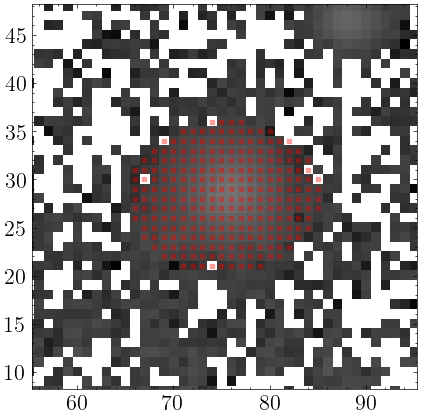

In [442]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [443]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [446]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

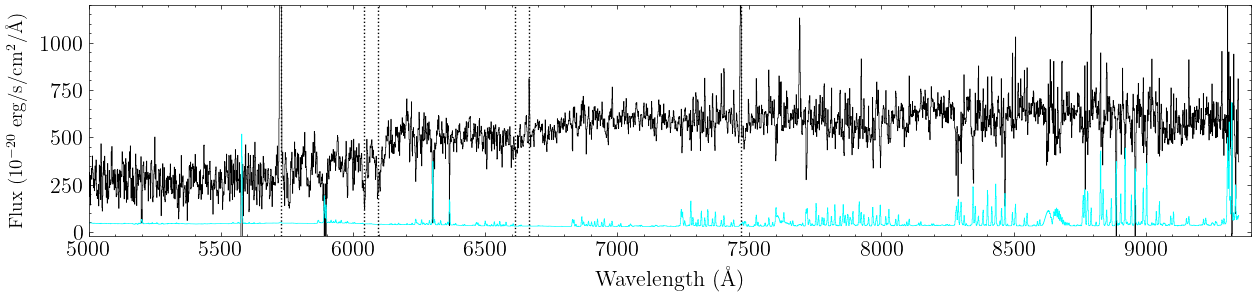

In [447]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.5356), linestyle=':')
ax.axvline(3934.78*(1+0.5356), linestyle=':')
ax.axvline(3969.59*(1+0.5356), linestyle=':')
ax.axvline(4305.61*(1+0.5356), linestyle=':')
ax.axvline(4341.68*(1+0.5356), linestyle=':')
ax.axvline(4862.68*(1+0.5356), linestyle=':')
#ax.axvline(4960.30*(1+0.5191), linestyle='--')
#ax.axvline(5008.24*(1+0.5191), linestyle='--')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 1200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

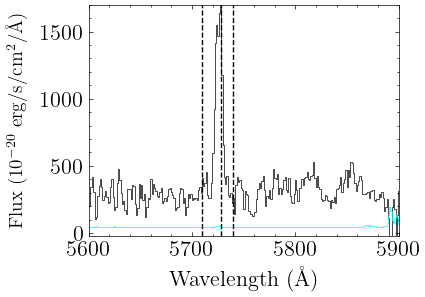

In [448]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.5356), linestyle='--')

ax.axvline(5710, linestyle='--')
ax.axvline(5740, linestyle='--')

ax.set_xlim(5600, 5900)
ax.set_ylim(-20, 1700)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [449]:
idx = (wav_arr>=5710)&(wav_arr<=5740)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(20.09885800102326, 0.2832225960667715)

In [453]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],3)

(22.91, 0.008)

In [454]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],3)

(21.621, 0.003)

In [455]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],3)

(21.055, 0.004)

# z=0.5723

## pseudo-g

In [456]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==59)
x0, y0 = np.mean(seg_map_gal_x)-1, np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = -40*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/10)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/7)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(161.675, 201.675)

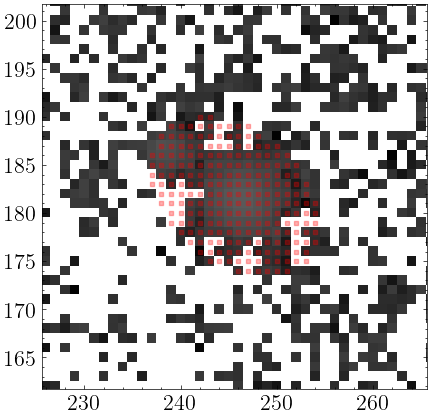

In [457]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(161.675, 201.675)

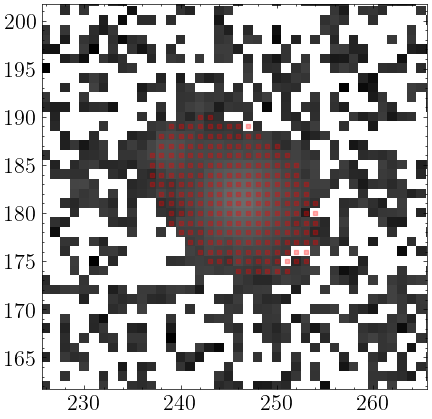

In [458]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(161.675, 201.675)

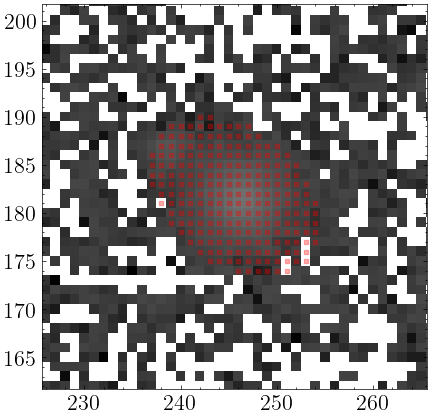

In [459]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [460]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [461]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

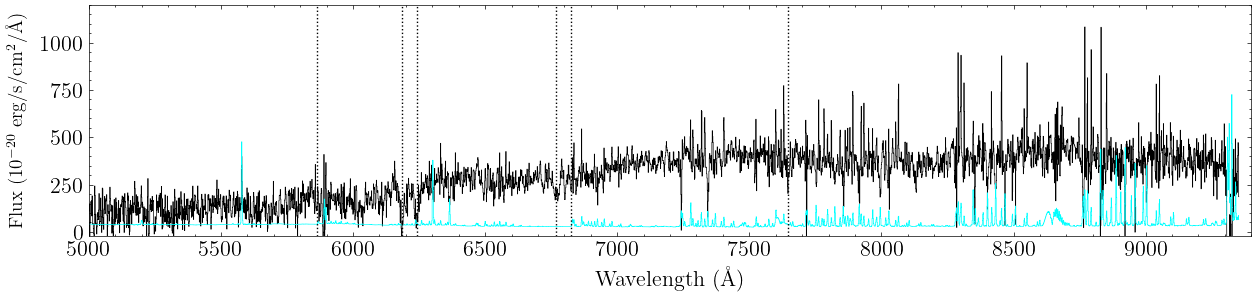

In [462]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.5723), linestyle=':')
ax.axvline(3934.78*(1+0.5723), linestyle=':')
ax.axvline(3969.59*(1+0.5723), linestyle=':')
ax.axvline(4305.61*(1+0.5723), linestyle=':')
ax.axvline(4341.68*(1+0.5723), linestyle=':')
ax.axvline(4862.68*(1+0.5723), linestyle=':')
#ax.axvline(4960.30*(1+0.5191), linestyle='--')
#ax.axvline(5008.24*(1+0.5191), linestyle='--')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 1200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [463]:
3729.87*(1+0.5723)

5864.474601

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

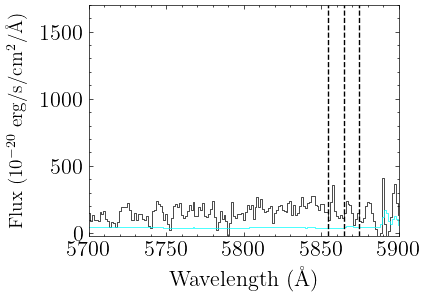

In [464]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.5723), linestyle='--')

ax.axvline(5854, linestyle='--')
ax.axvline(5874, linestyle='--')

ax.set_xlim(5700, 5900)
ax.set_ylim(-20, 1700)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [466]:
idx = (wav_arr>=5854)&(wav_arr<=5874)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(3.0692789374261293, 0.2179854343448175)

In [470]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(23.86, 0.02)

In [471]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],3)

(22.26, 0.004)

In [472]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],3)

(21.536, 0.006)

# z=0.6174

## pseudo-g

In [473]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==90)
x0, y0 = np.mean(seg_map_gal_x)+.5, np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = -40*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/3)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(58.959999999999994, 98.96)

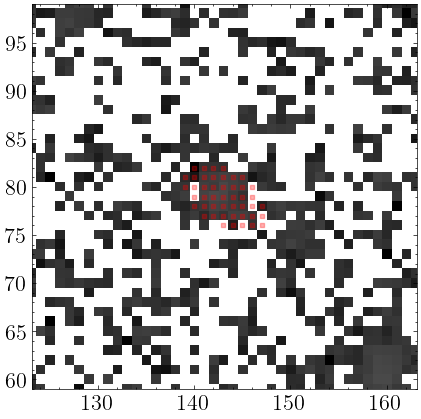

In [474]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(58.959999999999994, 98.96)

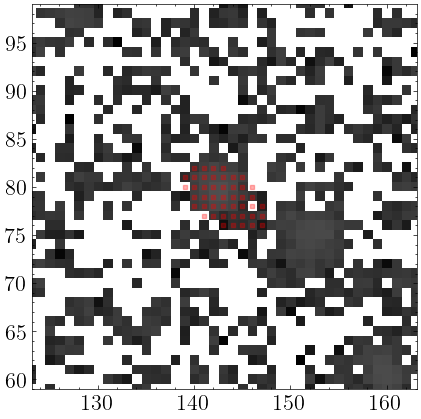

In [475]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(58.959999999999994, 98.96)

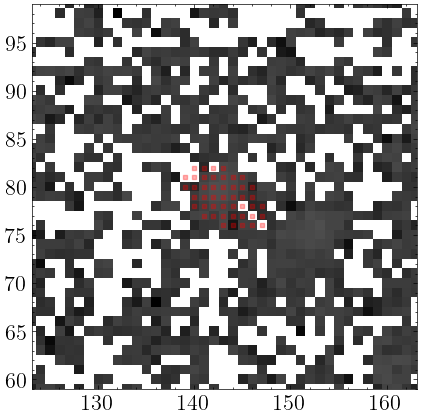

In [476]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [477]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [478]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

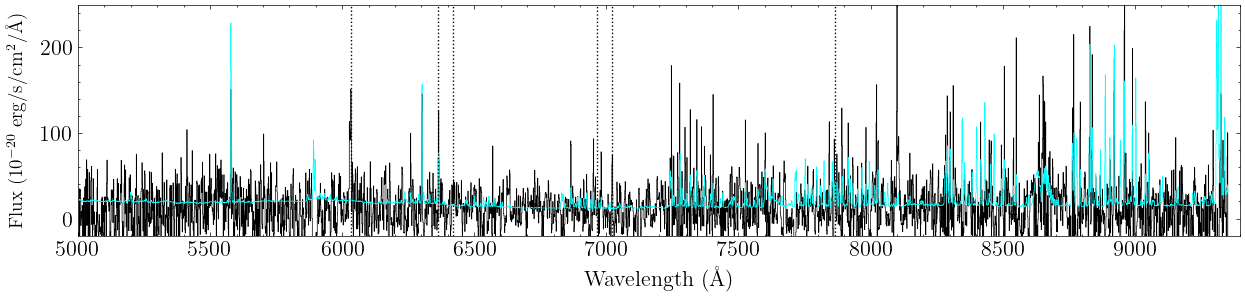

In [479]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.6174), linestyle=':')
ax.axvline(3934.78*(1+0.6174), linestyle=':')
ax.axvline(3969.59*(1+0.6174), linestyle=':')
ax.axvline(4305.61*(1+0.6174), linestyle=':')
ax.axvline(4341.68*(1+0.6174), linestyle=':')
ax.axvline(4862.68*(1+0.6174), linestyle=':')
#ax.axvline(4960.30*(1+0.5191), linestyle='--')
#ax.axvline(5008.24*(1+0.5191), linestyle='--')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 250)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

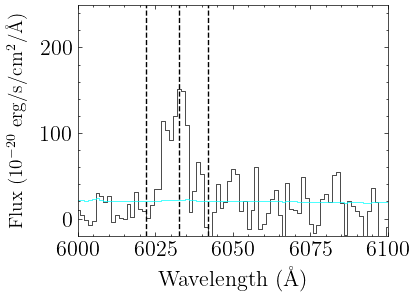

In [480]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.6174), linestyle='--')

ax.axvline(6022, linestyle='--')
ax.axvline(6042, linestyle='--')

ax.set_xlim(6000, 6100)
ax.set_ylim(-20, 250)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [481]:
idx = (wav_arr>=6022)&(wav_arr<=6042)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(1.3532545113016385, 0.10359709446242193)

In [483]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],1)

(26.5, 0.1)

In [485]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(25.62, 0.04)

In [486]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(25.15, 0.08)

# z=0.6178

## pseudo-g

In [487]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==99)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = -70*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/7)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(32.074074074074076, 72.07407407407408)

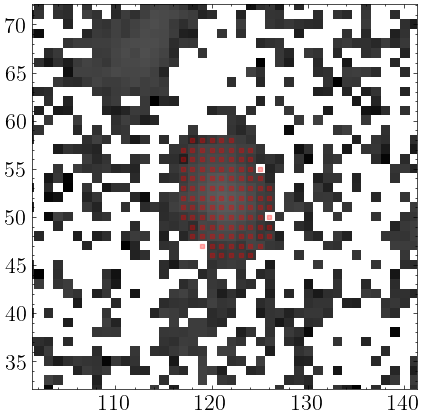

In [488]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(32.074074074074076, 72.07407407407408)

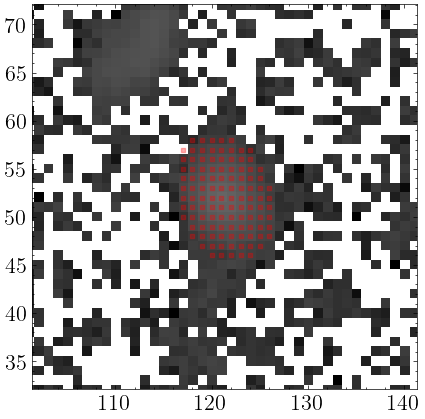

In [489]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(32.074074074074076, 72.07407407407408)

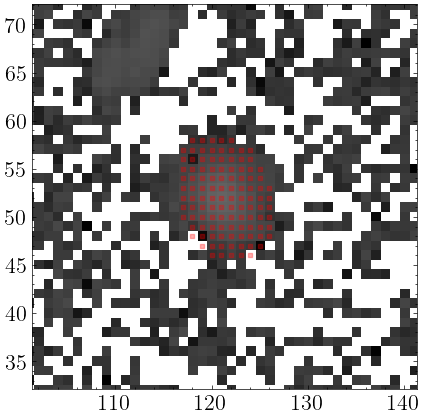

In [490]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [491]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [492]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

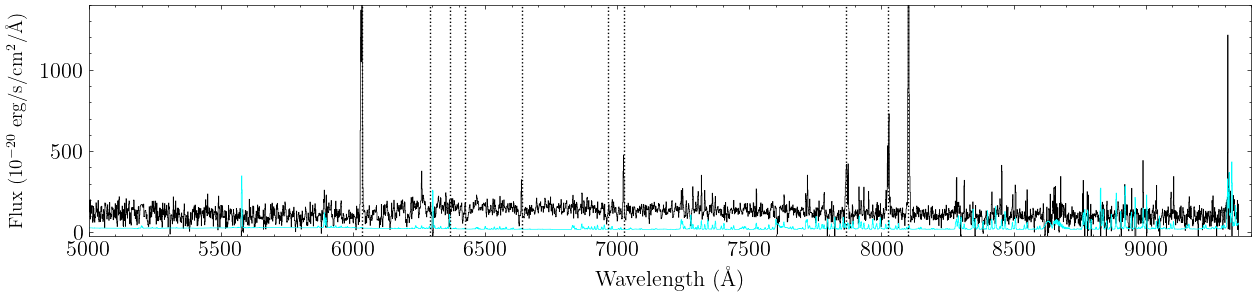

In [493]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.6178), linestyle=':')
ax.axvline(3889.0*(1+0.6178), linestyle=':')

ax.axvline(3934.78*(1+0.6178), linestyle=':')
ax.axvline(3969.59*(1+0.6178), linestyle=':')
ax.axvline(4102.89*(1+0.6178), linestyle=':')
ax.axvline(4305.61*(1+0.6178), linestyle=':')
ax.axvline(4341.68*(1+0.6178), linestyle=':')
ax.axvline(4862.68*(1+0.6178), linestyle=':')
ax.axvline(4960.30*(1+0.6178), linestyle=':')
ax.axvline(5008.24*(1+0.6178), linestyle=':')


ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 1400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

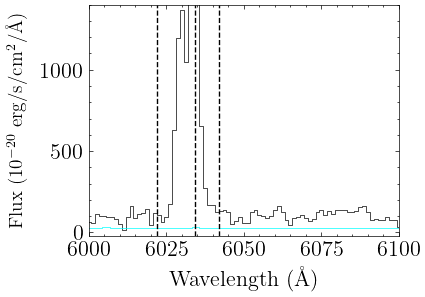

In [494]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.6178), linestyle='--')

ax.axvline(6022, linestyle='--')
ax.axvline(6042, linestyle='--')

ax.set_xlim(6000, 6100)
ax.set_ylim(-20, 1400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [495]:
idx = (wav_arr>=6022)&(wav_arr<=6042)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(13.504841225817218, 0.13705898007868914)

In [499]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(23.85, 0.01)

In [500]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],3)

(23.027, 0.006)

In [501]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(22.79, 0.01)

# z=0.6183

## pseudo-g

In [502]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==100)
x0, y0 = np.mean(seg_map_gal_x)+.5, np.mean(seg_map_gal_y)+.5
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 60*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/4.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(27.34848484848485, 67.34848484848484)

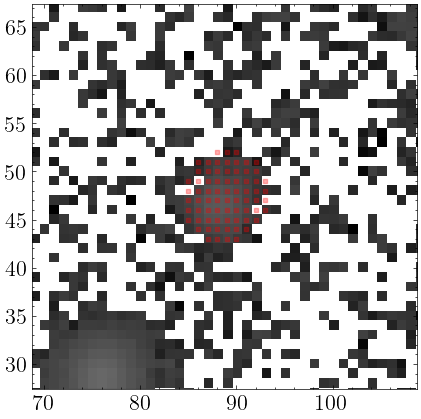

In [503]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(27.34848484848485, 67.34848484848484)

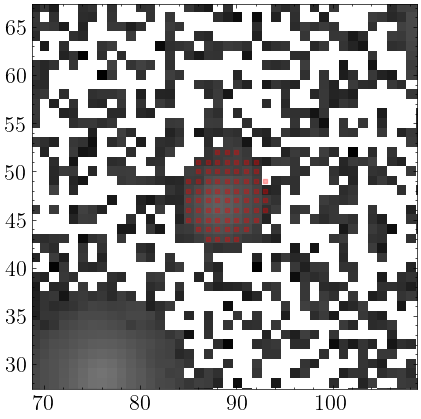

In [504]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(27.34848484848485, 67.34848484848484)

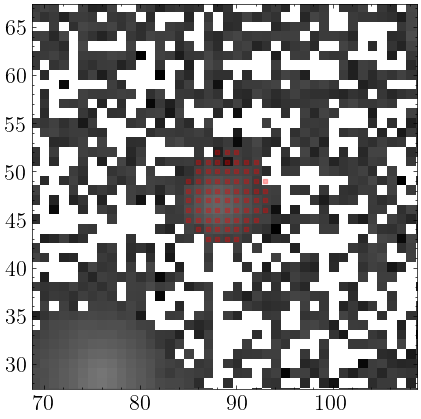

In [505]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [506]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [510]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

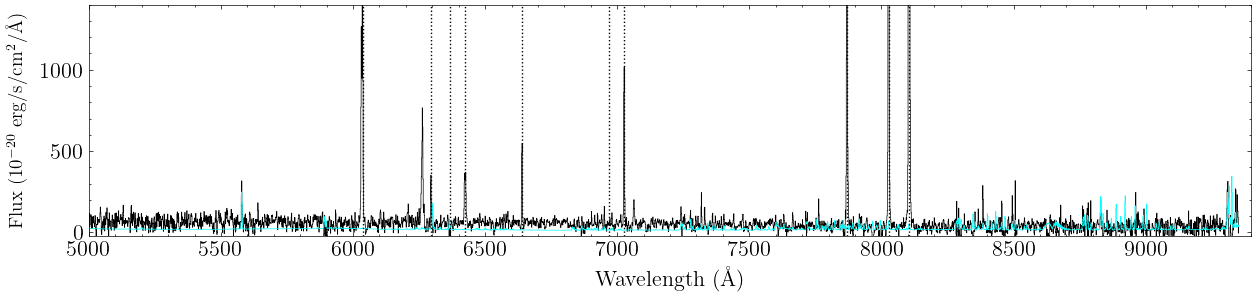

In [511]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.6183), linestyle=':')
ax.axvline(3889.0*(1+0.6183), linestyle=':')

ax.axvline(3934.78*(1+0.6183), linestyle=':')
ax.axvline(3969.59*(1+0.6183), linestyle=':')
ax.axvline(4102.89*(1+0.6183), linestyle=':')
ax.axvline(4305.61*(1+0.6183), linestyle=':')
ax.axvline(4341.68*(1+0.6183), linestyle=':')
ax.axvline(4862.68*(1+0.6183), linestyle=':')
ax.axvline(4960.30*(1+0.6183), linestyle=':')
ax.axvline(5008.24*(1+0.6183), linestyle=':')


ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 1400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

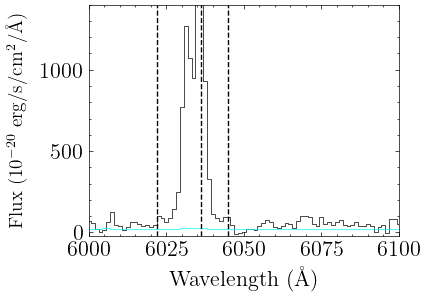

In [512]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.6183), linestyle='--')

ax.axvline(6022, linestyle='--')
ax.axvline(6045, linestyle='--')

ax.set_xlim(6000, 6100)
ax.set_ylim(-20, 1400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [513]:
idx = (wav_arr>=6022)&(wav_arr<=6045)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(11.909507415780391, 0.1237667330322781)

In [515]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(24.42, 0.02)

In [517]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],3)

(23.835, 0.009)

In [521]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(23.14, 0.01)

# z=0.6469

## pseudo-g

In [522]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==38)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)+.5
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 60*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/3)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(228.54, 268.53999999999996)

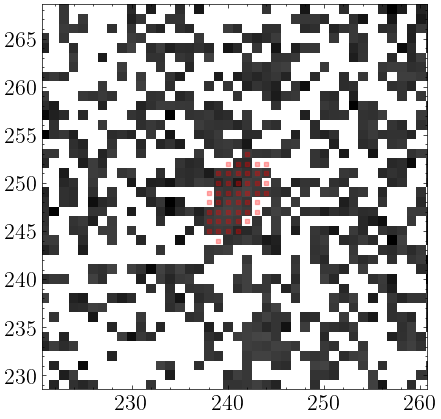

In [523]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(228.54, 268.53999999999996)

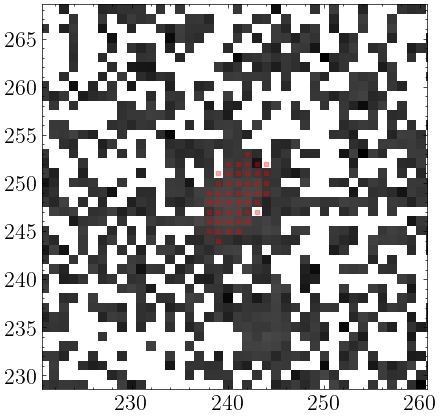

In [524]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(228.54, 268.53999999999996)

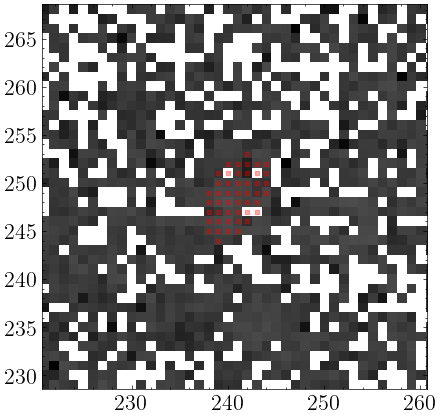

In [525]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [526]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [527]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

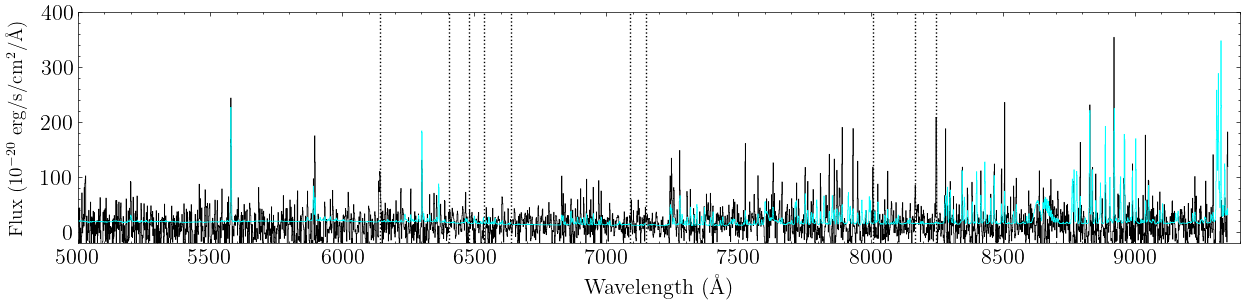

In [528]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.6469), linestyle=':')
ax.axvline(3889.0*(1+0.6469), linestyle=':')

ax.axvline(3934.78*(1+0.6469), linestyle=':')
ax.axvline(3969.59*(1+0.6469), linestyle=':')
ax.axvline(4102.89*(1+0.6183), linestyle=':')
ax.axvline(4305.61*(1+0.6469), linestyle=':')
ax.axvline(4341.68*(1+0.6469), linestyle=':')
ax.axvline(4862.68*(1+0.6469), linestyle=':')
ax.axvline(4960.30*(1+0.6469), linestyle=':')
ax.axvline(5008.24*(1+0.6469), linestyle=':')


ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

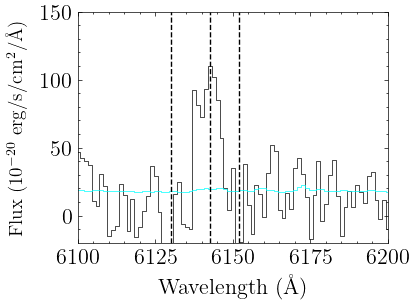

In [529]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.6469), linestyle='--')

ax.axvline(6130, linestyle='--')
ax.axvline(6152, linestyle='--')

ax.set_xlim(6100, 6200)
ax.set_ylim(-20, 150)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [530]:
idx = (wav_arr>=6130)&(wav_arr<=6152)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.9272798830451211, 0.09719367418962037)

In [535]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(26.6, 0.1)

In [533]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(25.62, 0.04)

In [532]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(25.11, 0.08)

# z=0.6478

## pseudo-g

In [536]:
x0, y0 = 109, 64
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 0*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/3)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/3)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2032114834.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2032114834.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(44.0, 84.0)

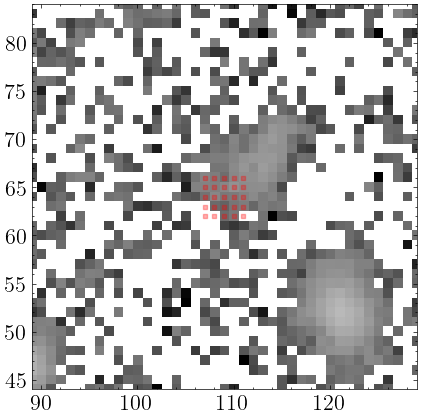

In [537]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=5, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(44.0, 84.0)

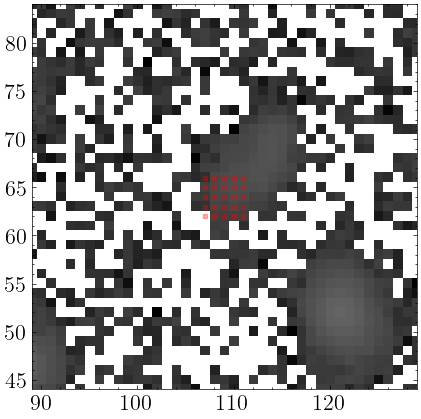

In [538]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(44.0, 84.0)

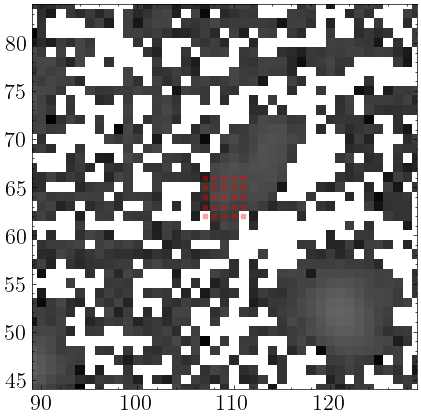

In [539]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [540]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [541]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

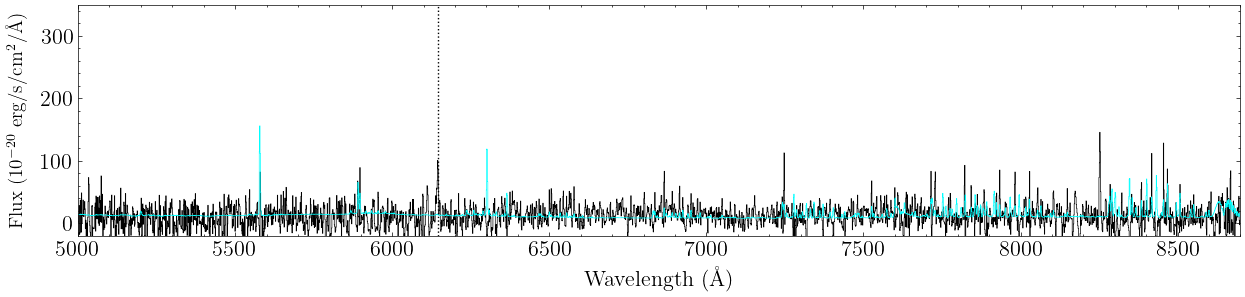

In [542]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(3729.87*(1+0.6478), linestyle=':')

ax.set_xlim(5000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

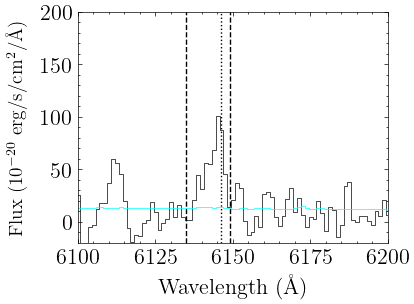

In [543]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.6478), linestyle=':')

ax.axvline(6135, linestyle='--')
ax.axvline(6149, linestyle='--')

ax.set_xlim(6100, 6200)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [544]:
idx = (wav_arr>=6135)&(wav_arr<=6149)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.6400611458392814, 0.0562960256787219)

In [545]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(26.69, 0.07)

In [546]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(25.71, 0.03)

In [547]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(25.42, 0.07)

# z=0.6531

## pseudo-g

In [548]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==56)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)+.5
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 60*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/6)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(170.36206896551724, 210.36206896551724)

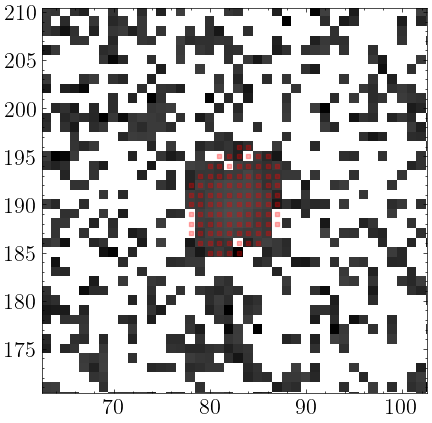

In [549]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(170.36206896551724, 210.36206896551724)

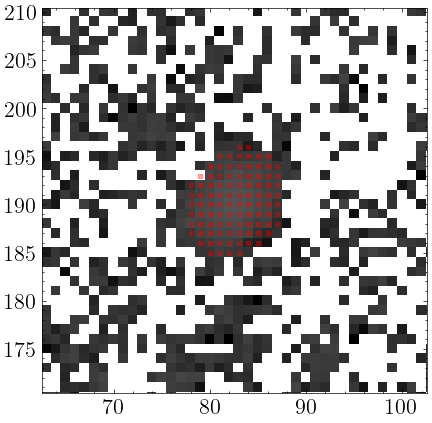

In [550]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(170.36206896551724, 210.36206896551724)

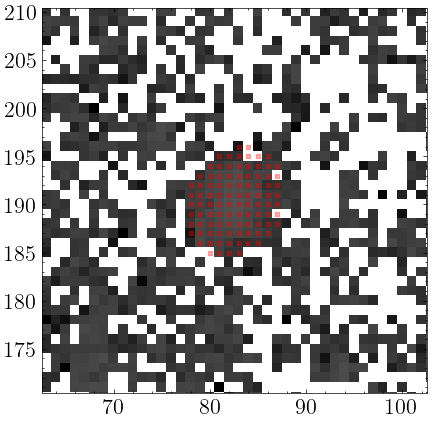

In [551]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [552]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [553]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

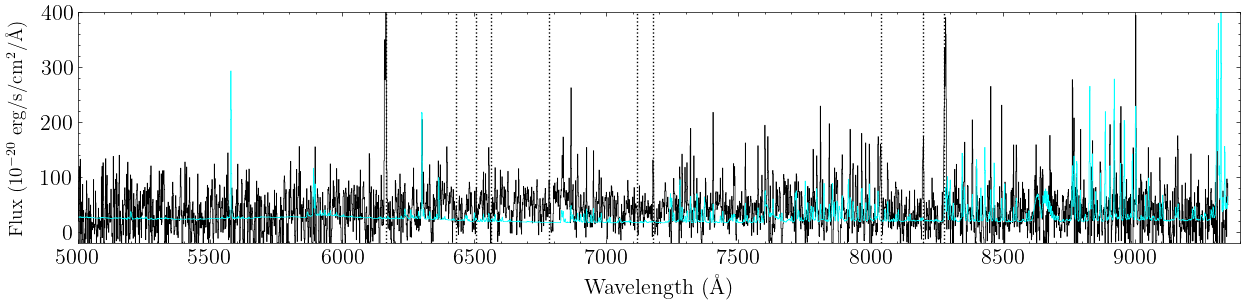

In [554]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.6531), linestyle=':')
ax.axvline(3889.0*(1+0.6531), linestyle=':')

ax.axvline(3934.78*(1+0.6531), linestyle=':')
ax.axvline(3969.59*(1+0.6531), linestyle=':')
ax.axvline(4102.89*(1+0.6531), linestyle=':')
ax.axvline(4305.61*(1+0.6531), linestyle=':')
ax.axvline(4341.68*(1+0.6531), linestyle=':')
ax.axvline(4862.68*(1+0.6531), linestyle=':')
ax.axvline(4960.30*(1+0.6531), linestyle=':')
ax.axvline(5008.24*(1+0.6531), linestyle=':')


ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

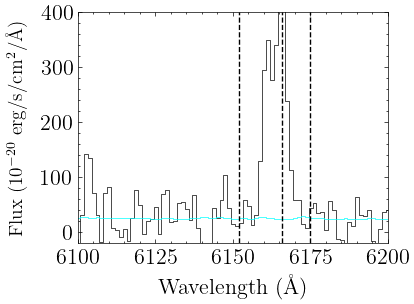

In [555]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.6531), linestyle='--')

ax.axvline(6152, linestyle='--')
ax.axvline(6175, linestyle='--')

ax.set_xlim(6100, 6200)
ax.set_ylim(-20, 400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [556]:
idx = (wav_arr>=6152)&(wav_arr<=6175)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(3.6253036505386627, 0.12805029344330524)

In [560]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(25.16, 0.03)

In [561]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(24.29, 0.02)

In [562]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(24.05, 0.04)

# z=0.6780

## pseudo-g

In [18]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==105)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 60*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/5.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/5.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/3082123145.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/3082123145.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(13.0, 53.0)

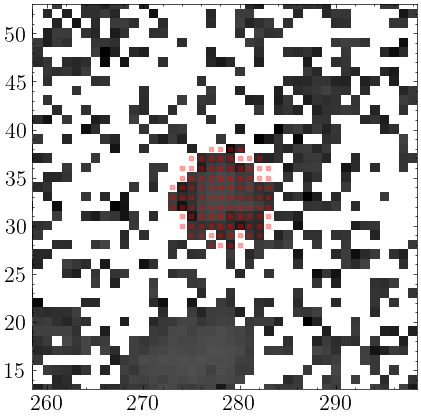

In [19]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)
#ax.invert_yaxis()
#ax.invert_xaxis()

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1081664601.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1081664601.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


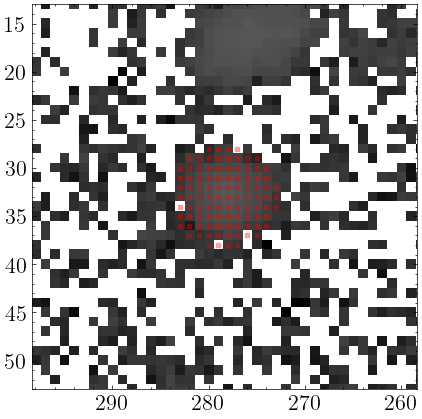

In [20]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)
ax.invert_yaxis()
ax.invert_xaxis()

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1766027471.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1766027471.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


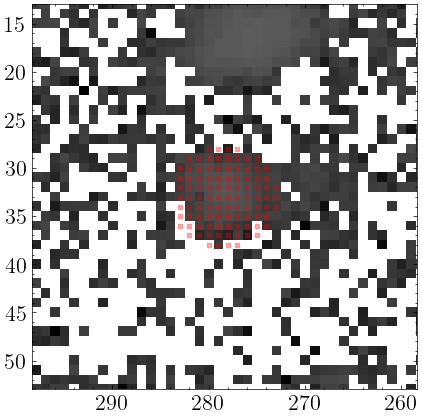

In [21]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)
ax.invert_yaxis()
ax.invert_xaxis()

In [22]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [23]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

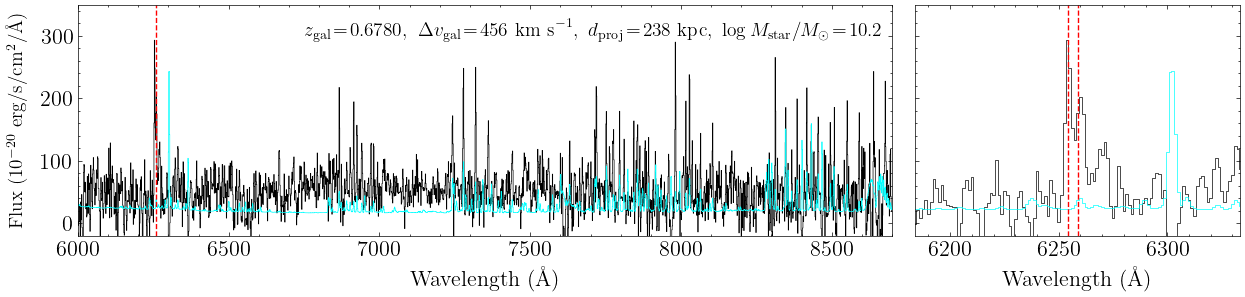

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [2.5, 1]}, sharey=True)

axes[0].step(wav_arr, spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
axes[0].text(6750, 300, 
             r'$z_\mathrm{gal}\!=\!0.6780, \ \Delta v_\mathrm{gal}\!=\!456 \ \mathrm{km \ s}^{-1}, \ d_\mathrm{proj} \!=\! 238 \ \mathrm{kpc}, \ \log M_\mathrm{star}/M_\odot \!=\! 10.2$', 
             fontsize=14)
axes[0].axvline(3729.875*(1+0.6780), linestyle='--', color='red')

axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-20, 350)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[1].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)

axes[1].set_xlim(3729.875*(1+0.6780)-75, 3729.875*(1+0.6780)+75)
axes[1].axvline(3727.092*(1+0.6780), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+0.6780), linestyle='--', color='red')

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=0.67545705/z_067_gal.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729*(1+0.6780), linestyle='--')
ax.axvline(4862.68*(1+0.6780), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

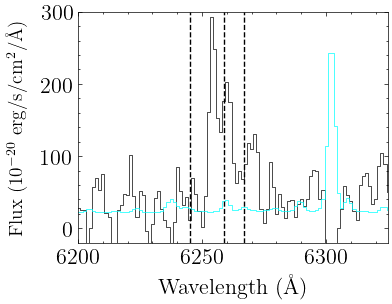

In [573]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.6780), linestyle='--')

ax.axvline(6245, linestyle='--')
ax.axvline(6267, linestyle='--')

ax.set_xlim(6200, 6325)
ax.set_ylim(-20, 300)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [574]:
idx = (wav_arr>=6245)&(wav_arr<=6267)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(2.468209709607054, 0.14134503481127275)

In [575]:
# OII SFR, cross-checked with catalog
D_L = 4096.4*3.086e+24 # cm
f_OII = 2.5*1e-17 # erg/cm^2/s
L_OII = 4*np.pi*D_L**2*f_OII # erg/s
SFR_OII = 6.58*1e-42*L_OII

In [576]:
SFR_OII

0.3303484889947504

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

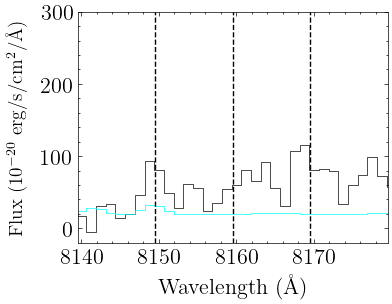

In [577]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(4862.68*(1+0.6780), linestyle='--')

ax.axvline(4862.68*(1+0.6780)-10, linestyle='--')
ax.axvline(4862.68*(1+0.6780)+10, linestyle='--')

ax.set_xlim(4862.68*(1+0.6780)-20, 4862.68*(1+0.6780)+20)
ax.set_ylim(-20, 300)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [578]:
idx = (wav_arr>=8150)&(wav_arr<=8170)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(1.1003151817833714, 0.10409482199441276)

In [579]:
4862.68*(1+0.6780)

8159.57704

In [580]:
# Assess spatial variation of Hbeta flux since non-detection
wav_idx = np.argmin(np.abs(wav_arr-4862.68*(1+0.6780)))

flam_Hb = np.zeros(len(gal_x))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    flam_Hb[j] = spec_cube[wav_idx,y,x]

In [581]:
#plt.hist(flam_Hb)

In [582]:
sig_flam_Hb = np.std(flam_Hb)*1e-3 # 1e-17 erg/cm^2/Å
#f_Hb = #1.1*1e-17 # Hbeta limiting flux from co-add
f_Hb = 3*(sig_flam_Hb*1e-17)*np.sqrt(len(gal_x))*20 # Hbeta limiting flux from spatial variation, account for area, wavelength window
f_Ha = 3*f_Hb # Standard correction, no dust?
L_Ha = 4*np.pi*D_L**2*f_Ha
SFR_Ha = 7.9*1e-42*L_Ha

In [583]:
SFR_Ha

0.7168404649660831

In [587]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(25.63, 0.06)

In [588]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(24.15, 0.02)

In [589]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(23.81, 0.03)

# z=0.7010

## pseudo-g

In [590]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==45)
x0, y0 = 98, 220
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 60*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/7)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/7)**2<1)

In [591]:
x0,y0

(98, 220)

In [592]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==45)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
idx = np.where((seg_map_gal_x-x0)**2+(seg_map_gal_y-y0)**2<5**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(200.7979797979798, 240.7979797979798)

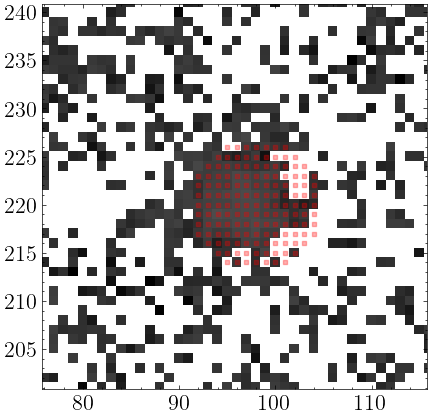

In [593]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1399351500.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1399351500.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(200.7979797979798, 240.7979797979798)

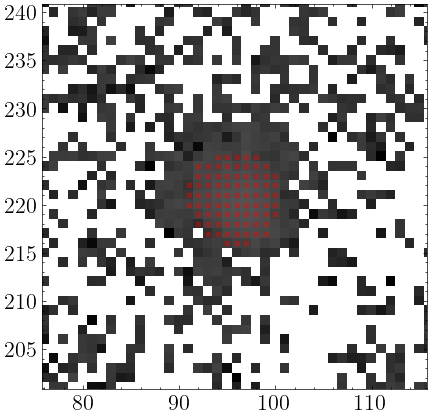

In [594]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/863437531.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/863437531.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(200.7979797979798, 240.7979797979798)

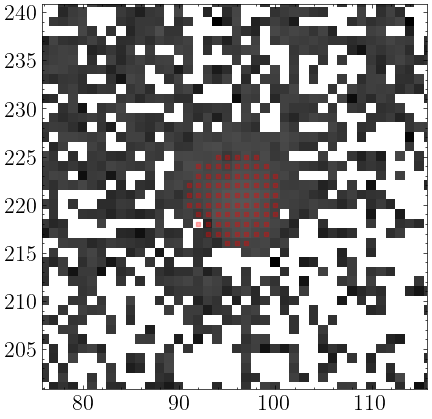

In [595]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [596]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [597]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

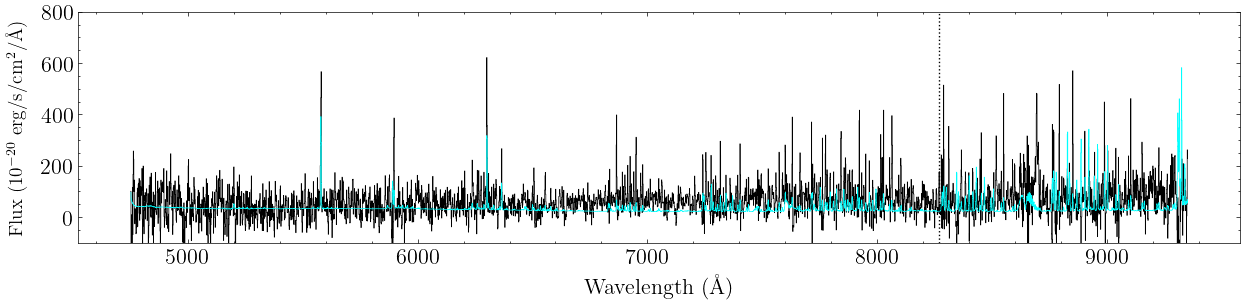

In [598]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


#ax.axvline(6564.61*(1+0.3010), linestyle=':')
#ax.axvline(4102.89*(1+0.7010), linestyle=':')
#ax.axvline(4305.61*(1+0.7010), linestyle=':')
#ax.axvline(4341.68*(1+0.7010), linestyle=':')
ax.axvline(4862.68*(1+0.7010), linestyle=':')
#ax.axvline(4960.30*(1+0.7010), linestyle=':')
#ax.axvline(5008.24*(1+0.7010), linestyle=':')
#ax.axvline(5895*(1+0.7010), linestyle=':')


#ax.set_xlim(6500, 9400)
ax.set_ylim(-100, 800)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [599]:
4862.68*(1+0.7010)

8271.41868

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

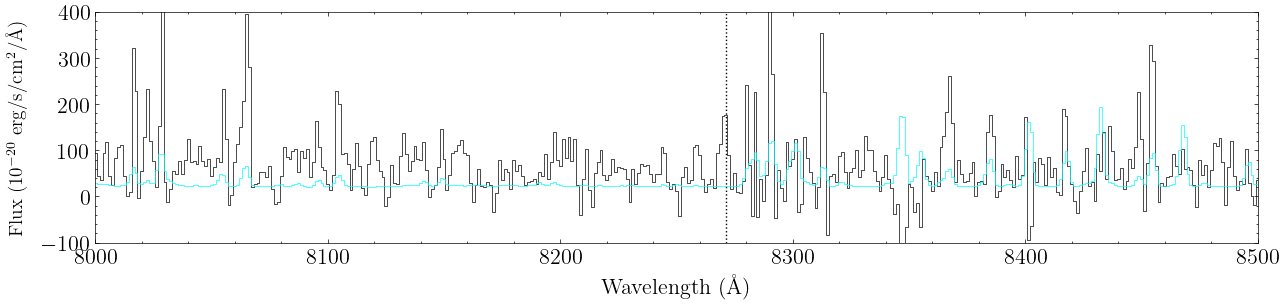

In [600]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


#ax.axvline(6564.61*(1+0.3010), linestyle=':')
#ax.axvline(4102.89*(1+0.7010), linestyle=':')
#ax.axvline(4305.61*(1+0.7010), linestyle=':')
#ax.axvline(4341.68*(1+0.7010), linestyle=':')
ax.axvline(4862.68*(1+0.7010), linestyle=':')
#ax.axvline(4960.30*(1+0.7010), linestyle=':')
#ax.axvline(5008.24*(1+0.7010), linestyle=':')
#ax.axvline(5895*(1+0.7010), linestyle=':')


ax.set_xlim(8000, 8500)
ax.set_ylim(-100, 400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [601]:
eigenspec_df = pd.read_csv('/Users/thepoetoftwilight/Documents/CUBS/Data/Eigenspectra/eigen_galaxy_Bolton2012.csv')

In [602]:
wav_eigen = eigenspec_df['wav']
c1 = eigenspec_df['c1']
c2 = eigenspec_df['c2']
c3 = eigenspec_df['c3']
c4 = eigenspec_df['c4']

In [603]:
def z_shift_eigen(z, wav_arr):
    
    wav_eigen_shift = wav_eigen*(1+z)
    
    gal_ind = (wav_eigen_shift>=wav_arr[0])&(wav_eigen_shift<=wav_arr[-1])
    wav_eigen_shift_gal = wav_eigen_shift[gal_ind]
    
    c1_gal = c1[gal_ind]
    c1_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c1_gal)

    c2_gal = c2[gal_ind]
    c2_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c2_gal)
    
    c3_gal = c3[gal_ind]
    c3_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c3_gal)

    c4_gal = c4[gal_ind]
    c4_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c4_gal)
    
    return c1_gal_interp, c2_gal_interp, c3_gal_interp, c4_gal_interp

In [604]:
def best_model(c1, c2, c3, c4, y, y_err):

    A11 = np.sum((c1/y_err)**2)
    A12 = np.sum(c1*c2/y_err**2)
    A13 = np.sum(c1*c3/y_err**2)
    A14 = np.sum(c1*c4/y_err**2)
    
    A21 = np.sum(c2*c1/y_err**2)
    A22 = np.sum((c2/y_err)**2)
    A23 = np.sum(c2*c3/y_err**2)
    A24 = np.sum(c2*c4/y_err**2)
    
    A31 = np.sum(c3*c1/y_err**2)
    A32 = np.sum(c3*c2/y_err**2)
    A33 = np.sum((c3/y_err)**2)
    A34 = np.sum(c3*c4/y_err**2)
    
    A41 = np.sum(c4*c1/y_err**2)
    A42 = np.sum(c4*c2/y_err**2)
    A43 = np.sum(c4*c3/y_err**2)
    A44 = np.sum((c4/y_err)**2)
    
    b1 = np.sum(y*c1/y_err**2)
    b2 = np.sum(y*c2/y_err**2)
    b3 = np.sum(y*c3/y_err**2)
    b4 = np.sum(y*c4/y_err**2)
    
    A_mat = np.array([[A11, A12, A13, A14],[A21, A22, A23, A24],[A31, A32, A33, A34],[A41, A42, A43, A44]])
    b_vec = np.array([b1, b2, b3, b4])
    
    x_vec = np.linalg.inv(A_mat)@b_vec
    
    a = x_vec[0]
    b = x_vec[1]
    c = x_vec[2]
    d = x_vec[3]

    return a, b, c, d

In [605]:
def eval_red_chi_sq(y_hat, y, y_err, dof):
    
    return np.sum(((y-y_hat)/y_err)**2)/(len(y)-dof)

In [606]:
z_arr = np.arange(0,1.,1e-4)
red_chi_sq_arr = np.zeros(len(z_arr))

In [607]:
model_params = np.zeros((len(z_arr), 4))

In [608]:
idx = ~np.isnan(spec_gal)

In [609]:
for i in range(len(z_arr)):
    
    z = z_arr[i]
    
    c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr[idx][20:-20])
    
    a, b, c, d = best_model(c1_shift, c2_shift, c3_shift, c4_shift, 
                            spec_gal[idx][20:-20], err_gal[idx][20:-20])
    
    model_params[i,0] = a
    model_params[i,1] = b
    model_params[i,2] = c
    model_params[i,3] = d 
    
    red_chi_sq = eval_red_chi_sq(a*c1_shift+b*c2_shift+c*c3_shift+d*c4_shift, 
                                        spec_gal[idx][20:-20], err_gal[idx][20:-20], model_params.shape[1])
    
    red_chi_sq_arr[i] = red_chi_sq
    
    #print(a, b, c, d, red_chi_sq)

In [610]:
z = z_arr[np.argmin(red_chi_sq_arr)]
c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr)

Text(0, 0.5, '$\\chi^2_\\mathrm{red}$')

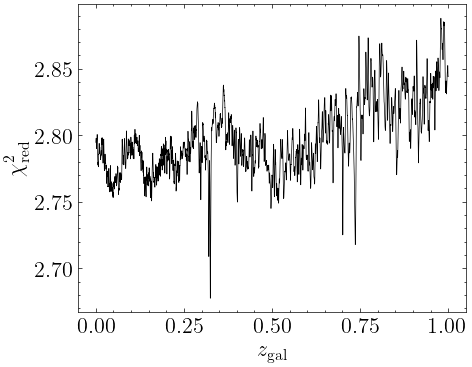

In [611]:
fig, ax = plt.subplots(1, figsize=(5,4))

ax.plot(z_arr, red_chi_sq_arr, lw=.5)
#ax.axvline(0.7010,color='red', linestyle='--')

ax.set_xlabel(r'$z_\mathrm{gal}$')
ax.set_ylabel(r'$\chi^2_\mathrm{red}$')

#ax.set_xlim(1.0,1.3)
#ax.set_ylim(45,51)


Text(0, 0.5, '$\\chi^2_\\mathrm{red}$')

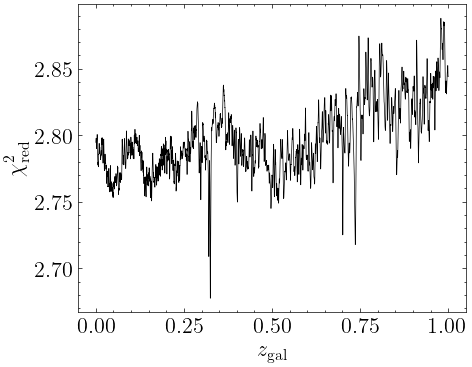

In [612]:
fig, ax = plt.subplots(1, figsize=(5,4))

ax.plot(z_arr, red_chi_sq_arr, lw=.5)
#ax.axvline(0.7010,color='red', linestyle=':')

ax.set_xlabel(r'$z_\mathrm{gal}$')
ax.set_ylabel(r'$\chi^2_\mathrm{red}$')

#ax.set_xlim(0.6,0.8)
#ax.set_ylim(45,51)


Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

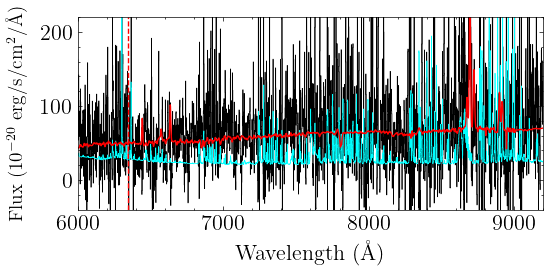

In [613]:
fig, ax = plt.subplots(1,figsize=(6,2.5))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=1, color='red')
ax.axvline(3729.875*(1+0.7010), linestyle='--', color='red')

ax.set_xlim(6000, 9200)
ax.set_ylim(-40, 220)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.27767328/z_127_gal.pdf', dpi=300)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

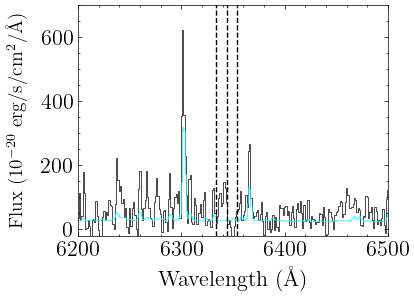

In [614]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.7010), linestyle='--')

ax.axvline(6334, linestyle='--')
ax.axvline(6354, linestyle='--')

ax.set_xlim(6200, 6500)
ax.set_ylim(-20, 700)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [615]:
idx = (wav_arr>=6334)&(wav_arr<=6354)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.9739468196993403, 0.14133173151275186)

In [619]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(24.89, 0.04)

In [620]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(23.98, 0.02)

In [621]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(23.33, 0.02)

# z=0.7293

## pseudo-g

In [622]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==61)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)+.5
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 60*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/6)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(163.13440860215053, 203.13440860215053)

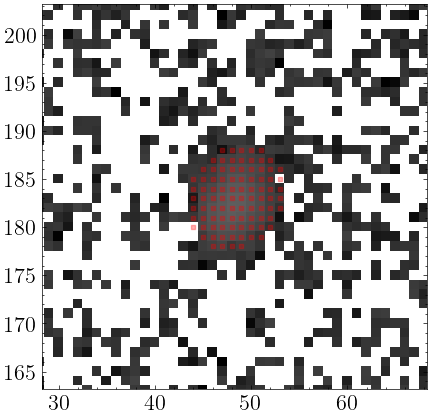

In [623]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(163.13440860215053, 203.13440860215053)

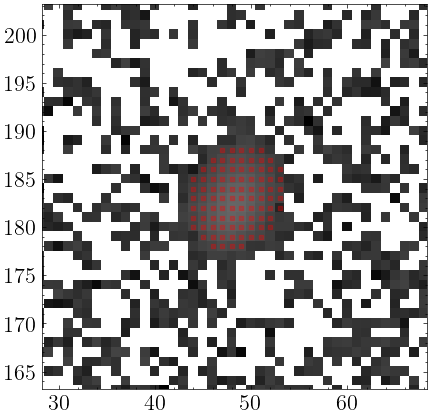

In [624]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(163.13440860215053, 203.13440860215053)

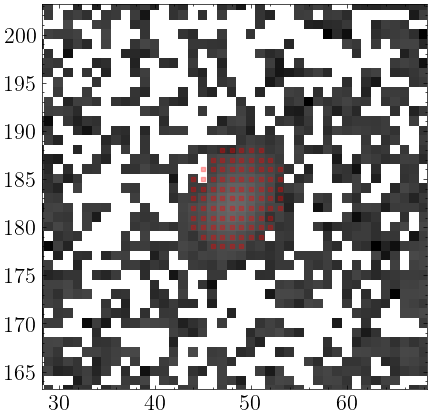

In [625]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [626]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [630]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

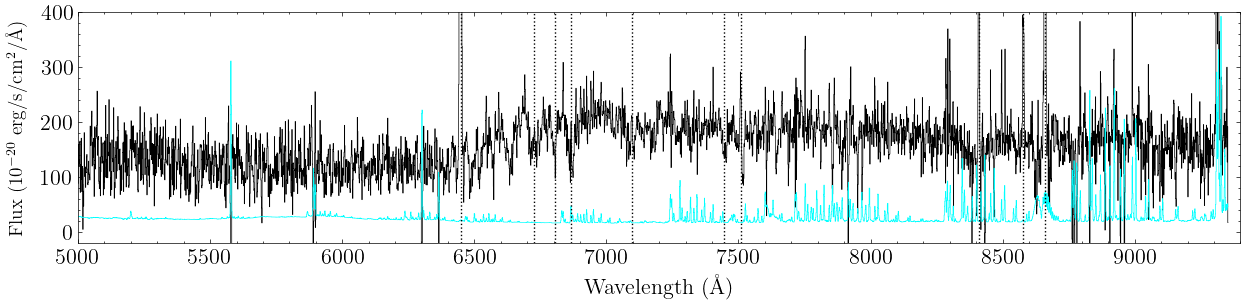

In [631]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.7293), linestyle=':')
ax.axvline(3889.0*(1+0.7293), linestyle=':')

ax.axvline(3934.78*(1+0.7293), linestyle=':')
ax.axvline(3969.59*(1+0.7293), linestyle=':')
ax.axvline(4102.89*(1+0.7293), linestyle=':')
ax.axvline(4305.61*(1+0.7293), linestyle=':')
ax.axvline(4341.68*(1+0.7293), linestyle=':')
ax.axvline(4862.68*(1+0.7293), linestyle=':')
ax.axvline(4960.30*(1+0.7293), linestyle=':')
ax.axvline(5008.24*(1+0.7293), linestyle=':')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

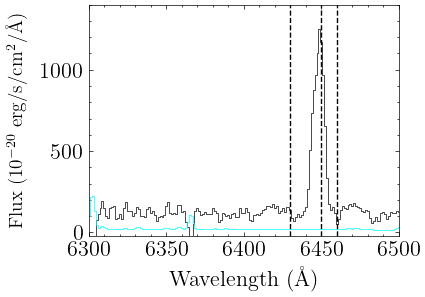

In [632]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.7293), linestyle='--')

ax.axvline(6430, linestyle='--')
ax.axvline(6460, linestyle='--')

ax.set_xlim(6300, 6500)
ax.set_ylim(-20, 1400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [633]:
idx = (wav_arr>=6430)&(wav_arr<=6460)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(12.898787698575624, 0.11865007847008922)

In [637]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(23.75, 0.01)

In [638]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],3)

(22.872, 0.005)

In [639]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],3)

(22.426, 0.008)

# z=0.8217

## pseudo-g

In [640]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==5)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)+.5
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 80*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/6)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/4)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(-5.196428571428571, 34.80357142857143)

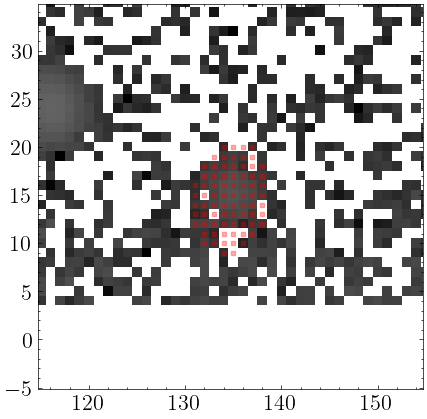

In [641]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(-5.196428571428571, 34.80357142857143)

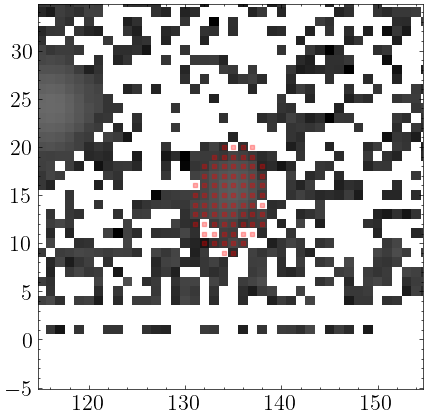

In [642]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(-5.196428571428571, 34.80357142857143)

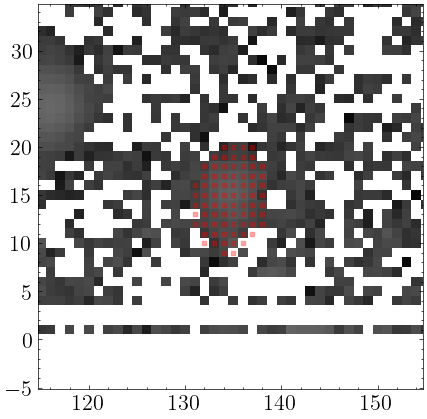

In [643]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [644]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [645]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

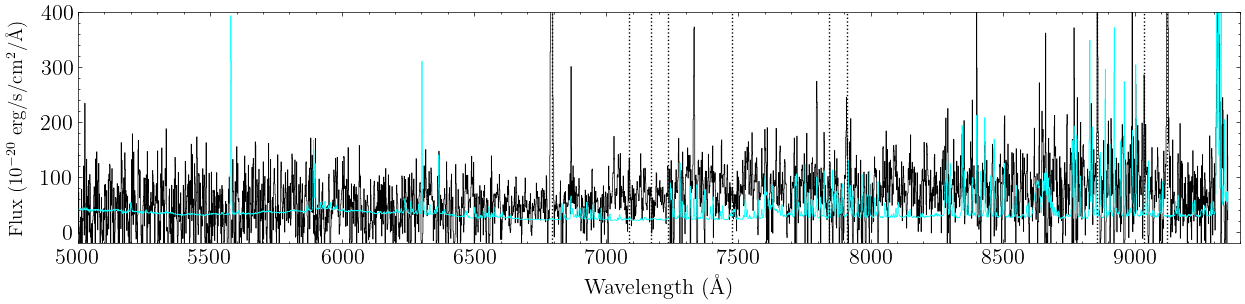

In [646]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.8217), linestyle=':')
ax.axvline(3889.0*(1+0.8217), linestyle=':')

ax.axvline(3934.78*(1+0.8217), linestyle=':')
ax.axvline(3969.59*(1+0.8217), linestyle=':')
ax.axvline(4102.89*(1+0.8217), linestyle=':')
ax.axvline(4305.61*(1+0.8217), linestyle=':')
ax.axvline(4341.68*(1+0.8217), linestyle=':')
ax.axvline(4862.68*(1+0.8217), linestyle=':')
ax.axvline(4960.30*(1+0.8217), linestyle=':')
ax.axvline(5008.24*(1+0.8217), linestyle=':')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

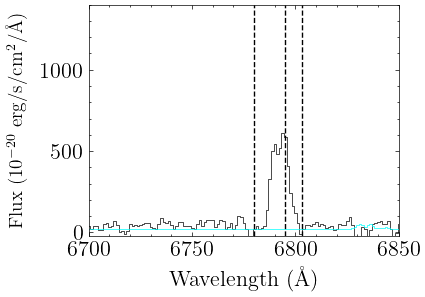

In [647]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.8217), linestyle='--')

ax.axvline(6780, linestyle='--')
ax.axvline(6803, linestyle='--')

ax.set_xlim(6700, 6850)
ax.set_ylim(-20, 1400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [648]:
idx = (wav_arr>=6780)&(wav_arr<=6803)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(6.066581845479414, 0.11956235672530381)

In [652]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(25.05, 0.04)

In [653]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(24.08, 0.02)

In [654]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(23.3, 0.03)

# z=0.8458

## pseudo-g

In [655]:
x0, y0 = 230, 105
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 0*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/3.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/3.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/353885458.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/353885458.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(85.0, 125.0)

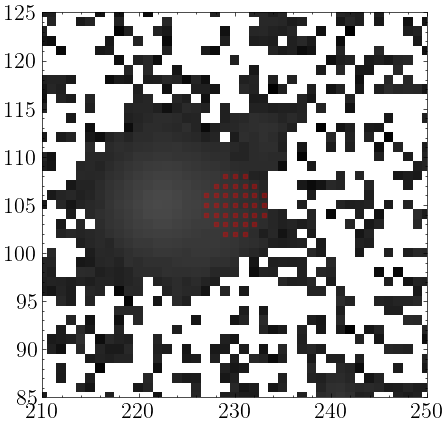

In [656]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=15, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(85.0, 125.0)

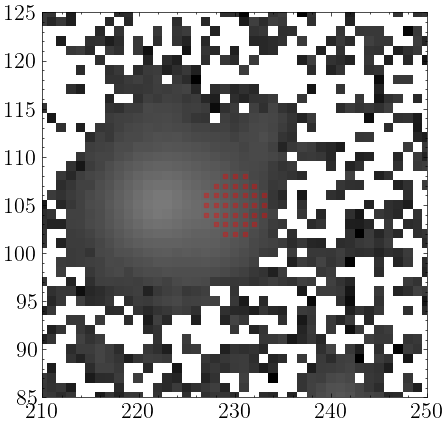

In [657]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(85.0, 125.0)

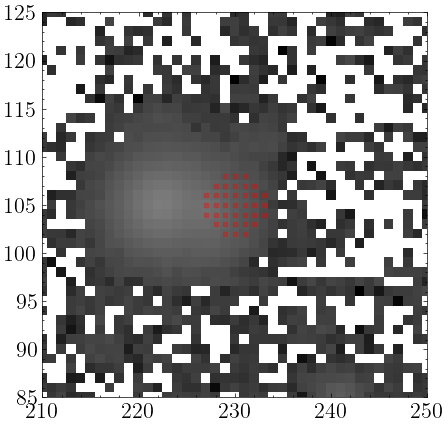

In [658]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [659]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [660]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

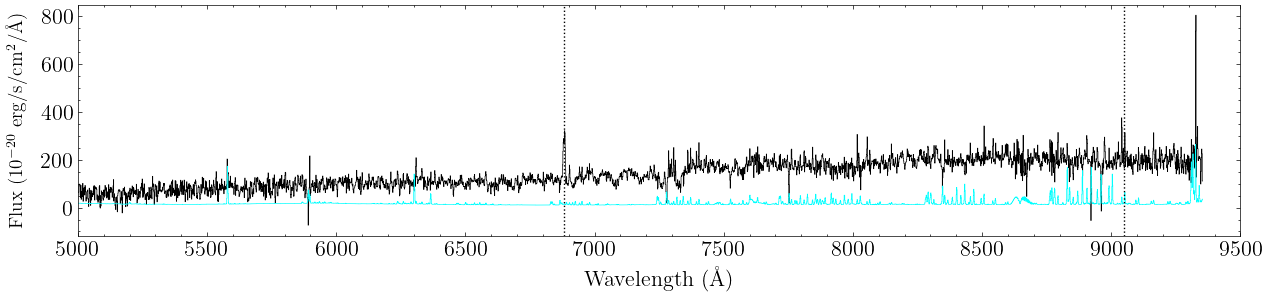

In [661]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(3729.87*(1+0.845), linestyle=':')

#ax.axvline(3934.78*(1+0.8609), linestyle=':')
#ax.axvline(3969.59*(1+0.8609), linestyle=':')

#ax.axvline(4102.89*(1+0.8609), linestyle=':')
#ax.axvline(3969.59*(1+0.8609), linestyle=':')
#ax.axvline(4305.61*(1+0.8609), linestyle=':')
ax.axvline(4862.68*(1+0.8609), linestyle=':')
#ax.axvline(4862.68*(1+0.8609), linestyle=':')
#ax.axvline(4960.30*(1+0.8609), linestyle=':')
#ax.axvline(5008.24*(1+0.8609), linestyle=':')


ax.set_xlim(5000, 9500)
#ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

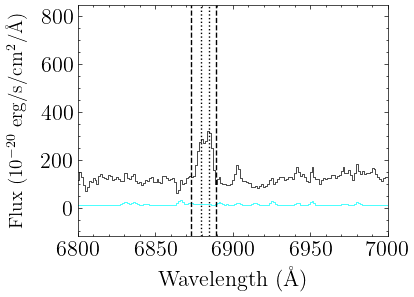

In [662]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3727.09*(1+0.8458), linestyle=':')
ax.axvline(3729.87*(1+0.8458), linestyle=':')

ax.axvline(6873, linestyle='--')
ax.axvline(6889, linestyle='--')

ax.set_xlim(6800, 7000)
#ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [663]:
idx = (wav_arr>=6873)&(wav_arr<=6889)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(3.5303678867593407, 0.062392707982199085)

In [667]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(24.37, 0.01)

In [668]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],3)

(23.229, 0.004)

In [669]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],3)

(22.311, 0.005)

# z=0.9576

## pseudo-g

In [670]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==3)
x0, y0 = np.mean(seg_map_gal_x)+1, np.mean(seg_map_gal_y)+.5
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 25*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/7)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(-3.5542635658914747, 36.445736434108525)

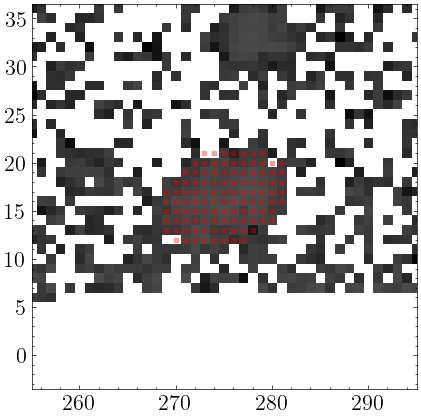

In [671]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(-3.5542635658914747, 36.445736434108525)

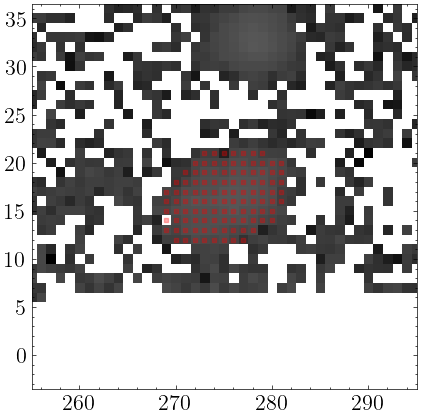

In [672]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(-3.5542635658914747, 36.445736434108525)

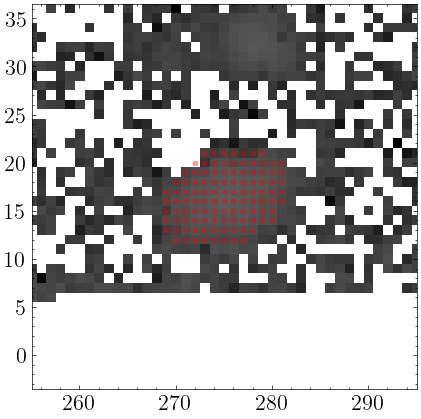

In [673]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [674]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [675]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

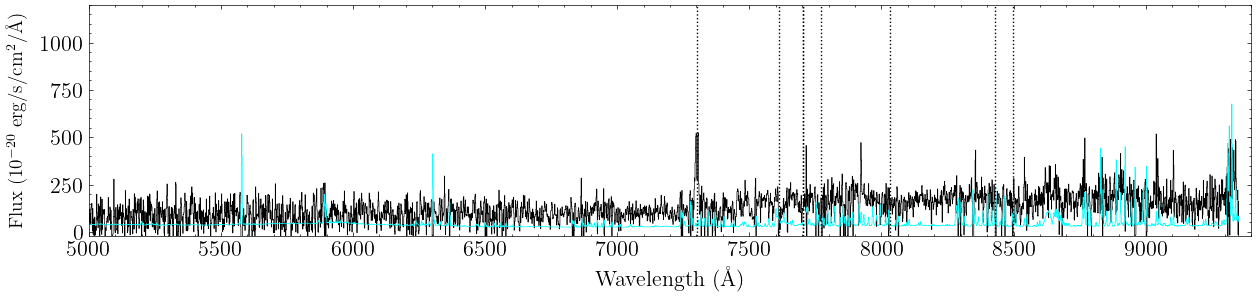

In [676]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+0.9576), linestyle=':')
ax.axvline(3889.0*(1+0.9576), linestyle=':')
ax.axvline(3934.78*(1+0.9576), linestyle=':')


ax.axvline(3934.78*(1+0.9576), linestyle=':')
ax.axvline(3969.59*(1+0.9576), linestyle=':')
ax.axvline(4102.89*(1+0.9576), linestyle=':')
ax.axvline(4305.61*(1+0.9576), linestyle=':')
ax.axvline(4341.68*(1+0.9576), linestyle=':')
ax.axvline(4862.68*(1+0.9576), linestyle=':')
ax.axvline(4960.30*(1+0.9576), linestyle=':')
ax.axvline(5008.24*(1+0.9576), linestyle=':')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 1200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

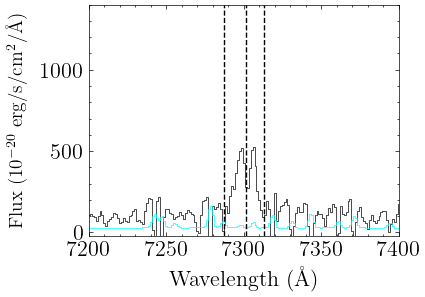

In [677]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+0.9576), linestyle='--')

ax.axvline(7287, linestyle='--')
ax.axvline(7313, linestyle='--')

ax.set_xlim(7200, 7400)
ax.set_ylim(-20, 1400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [678]:
idx = (wav_arr>=7287)&(wav_arr<=7313)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(7.934973144907854, 0.23278263084289105)

In [682]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(24.34, 0.03)

In [683]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(23.44, 0.01)

In [684]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(22.51, 0.01)

# z=1.0426

## pseudo-g

In [26]:
x0, y0 = 109, 248
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 45*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/3.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/2.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(228.0, 268.0)

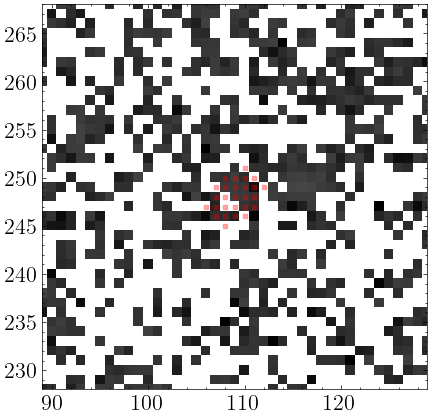

In [27]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(228.0, 268.0)

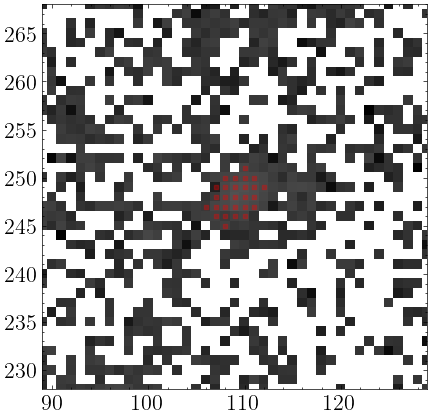

In [28]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(228.0, 268.0)

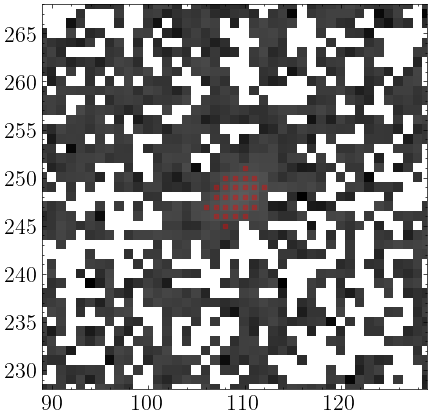

In [29]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [30]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [31]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

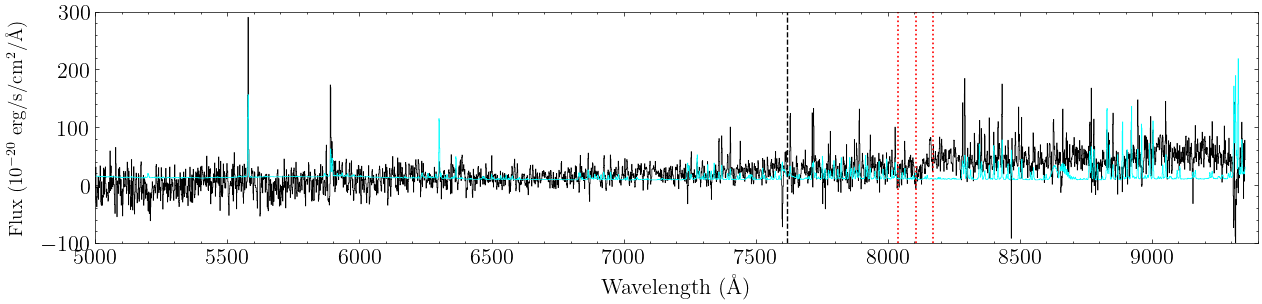

In [32]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+1.0426), linestyle='--')
ax.axvline(3934.78*(1+1.0426), linestyle=':', color='red', lw=1.2)
ax.axvline(3969.59*(1+1.0426), linestyle=':', color='red', lw=1.2)

ax.axvline(4000*(1+1.0426), linestyle=':', color='red', lw=1.2)


ax.set_xlim(5000, 9400)
ax.set_ylim(-100, 300)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [36]:
eigenspec_df = pd.read_csv('/Users/thepoetoftwilight/Documents/Astro/Data/Eigenspectra/eigen_galaxy_Bolton2012.csv')

In [37]:
wav_eigen = eigenspec_df['wav']
c1 = eigenspec_df['c1']
c2 = eigenspec_df['c2']
c3 = eigenspec_df['c3']
c4 = eigenspec_df['c4']

In [35]:
def z_shift_eigen(z, wav_arr):
    
    wav_eigen_shift = wav_eigen*(1+z)
    
    gal_ind = (wav_eigen_shift>=wav_arr[0])&(wav_eigen_shift<=wav_arr[-1])
    wav_eigen_shift_gal = wav_eigen_shift[gal_ind]
    
    c1_gal = c1[gal_ind]
    c1_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c1_gal)

    c2_gal = c2[gal_ind]
    c2_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c2_gal)
    
    c3_gal = c3[gal_ind]
    c3_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c3_gal)

    c4_gal = c4[gal_ind]
    c4_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c4_gal)
    
    return c1_gal_interp, c2_gal_interp, c3_gal_interp, c4_gal_interp

In [830]:
def best_model(c1, c2, c3, c4, y, y_err):

    A11 = np.sum((c1/y_err)**2)
    A12 = np.sum(c1*c2/y_err**2)
    A13 = np.sum(c1*c3/y_err**2)
    A14 = np.sum(c1*c4/y_err**2)
    
    A21 = np.sum(c2*c1/y_err**2)
    A22 = np.sum((c2/y_err)**2)
    A23 = np.sum(c2*c3/y_err**2)
    A24 = np.sum(c2*c4/y_err**2)
    
    A31 = np.sum(c3*c1/y_err**2)
    A32 = np.sum(c3*c2/y_err**2)
    A33 = np.sum((c3/y_err)**2)
    A34 = np.sum(c3*c4/y_err**2)
    
    A41 = np.sum(c4*c1/y_err**2)
    A42 = np.sum(c4*c2/y_err**2)
    A43 = np.sum(c4*c3/y_err**2)
    A44 = np.sum((c4/y_err)**2)
    
    b1 = np.sum(y*c1/y_err**2)
    b2 = np.sum(y*c2/y_err**2)
    b3 = np.sum(y*c3/y_err**2)
    b4 = np.sum(y*c4/y_err**2)
    
    A_mat = np.array([[A11, A12, A13, A14],[A21, A22, A23, A24],[A31, A32, A33, A34],[A41, A42, A43, A44]])
    b_vec = np.array([b1, b2, b3, b4])
    
    x_vec = np.linalg.inv(A_mat)@b_vec
    
    a = x_vec[0]
    b = x_vec[1]
    c = x_vec[2]
    d = x_vec[3]

    return a, b, c, d

In [831]:
def eval_red_chi_sq(y_hat, y, y_err, dof):
    
    return np.sum(((y-y_hat)/y_err)**2)/(len(y)-dof)

In [832]:
z_arr = np.arange(0.0,2,1e-4)
red_chi_sq_arr = np.zeros(len(z_arr))

In [833]:
model_params = np.zeros((len(z_arr), 4))

In [834]:
idx = ~np.isnan(spec_gal)

In [835]:
for i in range(len(z_arr)):
    
    z = z_arr[i]
    
    c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr[idx][20:-20])
    
    a, b, c, d = best_model(c1_shift, c2_shift, c3_shift, c4_shift, 
                            spec_gal[idx][20:-20], err_gal[idx][20:-20])
    
    model_params[i,0] = a
    model_params[i,1] = b
    model_params[i,2] = c
    model_params[i,3] = d 
    
    red_chi_sq = eval_red_chi_sq(a*c1_shift+b*c2_shift+c*c3_shift+d*c4_shift, 
                                        spec_gal[idx][20:-20], err_gal[idx][20:-20], model_params.shape[1])
    
    red_chi_sq_arr[i] = red_chi_sq
    
    #print(a, b, c, d, red_chi_sq)

Text(0, 0.5, '$\\chi^2_\\mathrm{red}$')

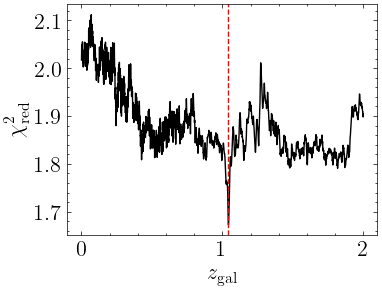

In [836]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.plot(z_arr, red_chi_sq_arr)
ax.axvline(1.0426, linestyle='--', color='red')

ax.set_xlabel(r'$z_\mathrm{gal}$')
ax.set_ylabel(r'$\chi^2_\mathrm{red}$')

In [837]:
z = z_arr[np.argmin(red_chi_sq_arr)]
c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr)

In [838]:
z

1.0426

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

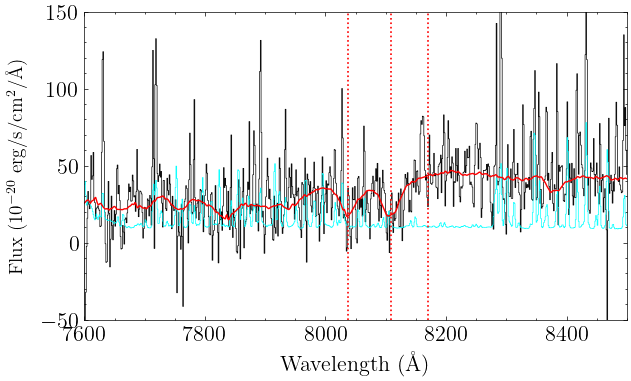

In [839]:
fig, ax = plt.subplots(1, figsize=(7,4))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3934.78*(1+1.0425), linestyle=':', color='red', lw=1.2)
ax.axvline(3969.59*(1+1.0425), linestyle=':', color='red', lw=1.2)

ax.axvline(4000*(1+1.0425), linestyle=':', color='red', lw=1.2)

#ax.axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
#ax.axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

ax.plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=1, color='red')

#ax.axhline(23, linestyle='--', color='orange')
#ax.axhline(42, linestyle='--', color='orange')

ax.set_xlim(7600, 8500)
#ax.set_ylim(-50, 150)
ax.set_ylim(-50,150)
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

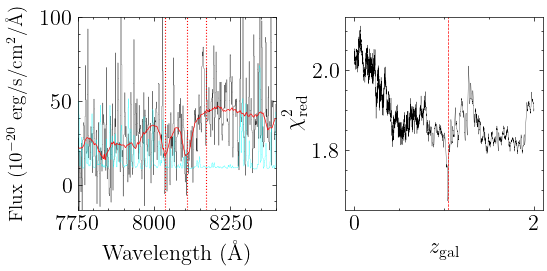

In [840]:
fig, axes = plt.subplots(1,2, figsize=(6,2.5))

axes[0].step(wav_arr, spec_gal, where='mid', lw=.2)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.2)

axes[0].axvline(3934.78*(1+1.0426), linestyle=':', color='red', lw=.8)
axes[0].axvline(3969.59*(1+1.0426), linestyle=':', color='red', lw=.8)

axes[0].axvline(4000*(1+1.0426), linestyle=':', color='red', lw=.8)

axes[0].plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, 
        lw=.5, color='red')

axes[0].set_xlim(7750, 8400)
#ax.set_ylim(-50, 150)
axes[0].set_ylim(-15,100)
axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].plot(z_arr, red_chi_sq_arr, lw=.2)
axes[1].axvline(1.0426, linestyle='--', color='red', lw=.5)

axes[1].set_xlabel(r'$z_\mathrm{gal}$')
axes[1].set_ylabel(r'$\chi^2_\mathrm{red}$')

plt.subplots_adjust(wspace=.35, hspace=0)      

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.04430803/z_104_gal_fit.pdf', dpi=300)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

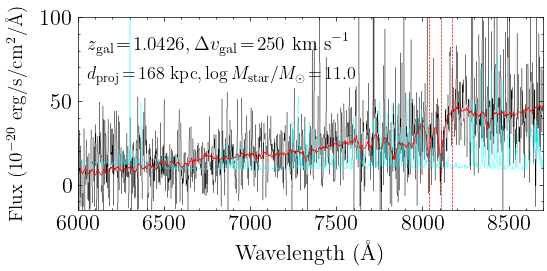

In [841]:
fig, ax = plt.subplots(1, figsize=(6,2.5))

ax.step(wav_arr, spec_gal, where='mid', lw=.2)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.2)

ax.axvline(3934.78*(1+1.0425), linestyle='--', color='red', lw=.5)
ax.axvline(3969.59*(1+1.0425), linestyle='--', color='red', lw=.5)

ax.axvline(4000*(1+1.0425), linestyle='--', color='red', lw=.5)

#ax.axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
#ax.axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

ax.plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=.5, color='red')

#ax.axhline(23, linestyle='--', color='orange')
#ax.axhline(42, linestyle='--', color='orange')

ax.text(6050, 80, r'$z_\mathrm{gal} \!=\! 1.0426, \Delta v_\mathrm{gal} \!=\! 250 \ \mathrm{km \ s}^{-1}$', fontsize=14)
ax.text(6050, 63, r'$d_\mathrm{proj} \!=\! 168 \ \mathrm{kpc}, \log M_\mathrm{star}/M_\odot \!=\! 11.0$', fontsize=13)

#ax.set_xlim(7600, 8500)
ax.set_xlim(6000, 8700)
ax.set_ylim(-15,100)
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.04430803/z_104_gal.pdf', dpi=300)

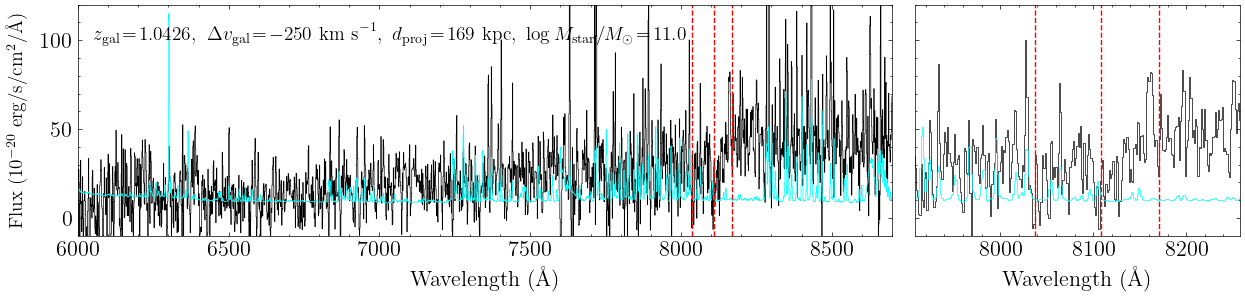

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [2.5, 1]}, sharey=True)

axes[0].step(wav_arr, spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
axes[0].text(6050, 100, 
             r'$z_\mathrm{gal}\!=\!1.0426, \ \Delta v_\mathrm{gal}\!=\!-250 \ \mathrm{km \ s}^{-1}, \ d_\mathrm{proj} \!=\! 169 \ \mathrm{kpc}, \ \log M_\mathrm{star}/M_\odot \!=\! 11.0$', 
             fontsize=14)

axes[0].axvline(3934.78*(1+1.0426), linestyle='--', color='red')
axes[0].axvline(3969.59*(1+1.0426), linestyle='--', color='red')
axes[0].axvline(4000.0*(1+1.0426), linestyle='--', color='red')

axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-10, 120)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[1].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)

axes[1].set_xlim(3969.59*(1+1.0426)-200, 3969.59*(1+1.0426)+150)
axes[1].axvline(3934.78*(1+1.0426), linestyle='--', color='red')
axes[1].axvline(3969.59*(1+1.0426), linestyle='--', color='red')
axes[1].axvline(4000.0*(1+1.0426), linestyle='--', color='red')

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.04430803/z_104_gal.pdf', dpi=300)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

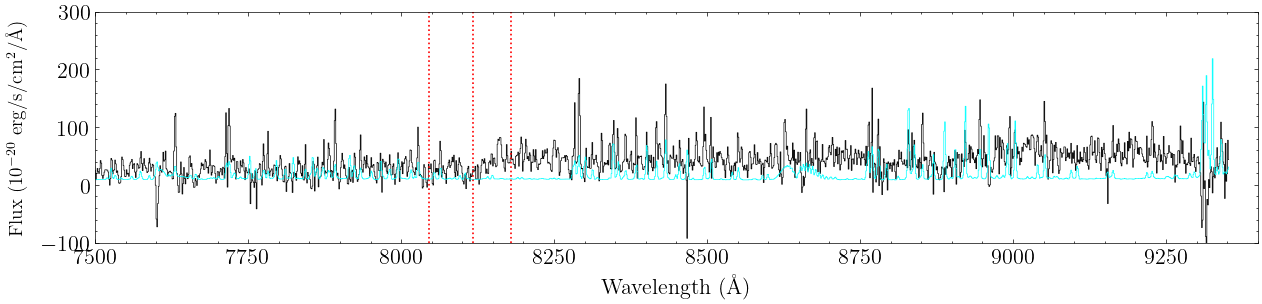

In [711]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(3934.78*(1+1.0448), linestyle=':', color='red', lw=1.2)
ax.axvline(3969.59*(1+1.0448), linestyle=':', color='red', lw=1.2)

ax.axvline(4000*(1+1.0448), linestyle=':', color='red', lw=1.2)


ax.set_xlim(7500, 9400)
ax.set_ylim(-100, 300)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

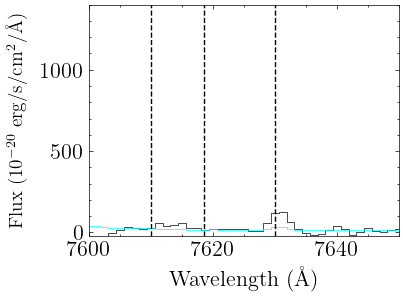

In [715]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+1.0426), linestyle='--')

ax.axvline(7610, linestyle='--')
ax.axvline(7630, linestyle='--')

ax.set_xlim(7600, 7650)
ax.set_ylim(-20, 1400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [717]:
idx = (wav_arr>=7610)&(wav_arr<=7630)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.5353805849538185, 0.08989617253400138)

In [718]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],1)

(28.8, 0.6)

In [719]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(25.46, 0.03)

In [720]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(24.05, 0.02)

# z=1.0959

## pseudo-g

In [40]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==27)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
idx = np.where((seg_map_gal_x-x0)**2+(seg_map_gal_y-y0)**2<50**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/3609254156.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/3609254156.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


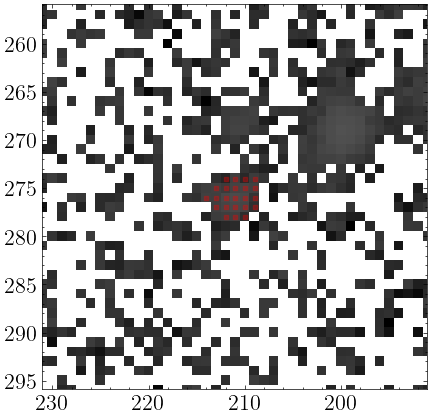

In [41]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)
ax.invert_yaxis()
ax.invert_xaxis()

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/772616851.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/772616851.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


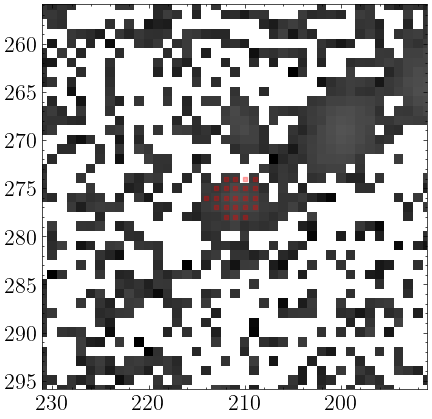

In [42]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)
ax.invert_yaxis()
ax.invert_xaxis()

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1884462142.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1884462142.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


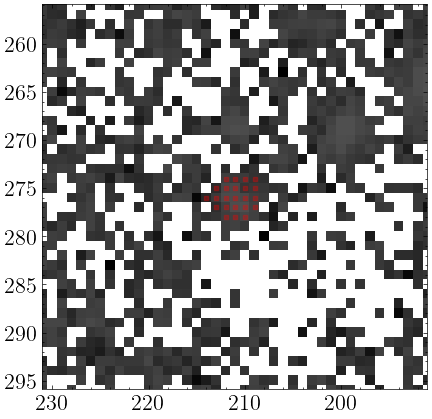

In [43]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)
ax.invert_yaxis()
ax.invert_xaxis()

In [44]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [45]:
spec_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))
var_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))

for j in range(len(seg_map_gal_x[idx])):

    x = seg_map_gal_x[idx][j]
    y = seg_map_gal_y[idx][j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

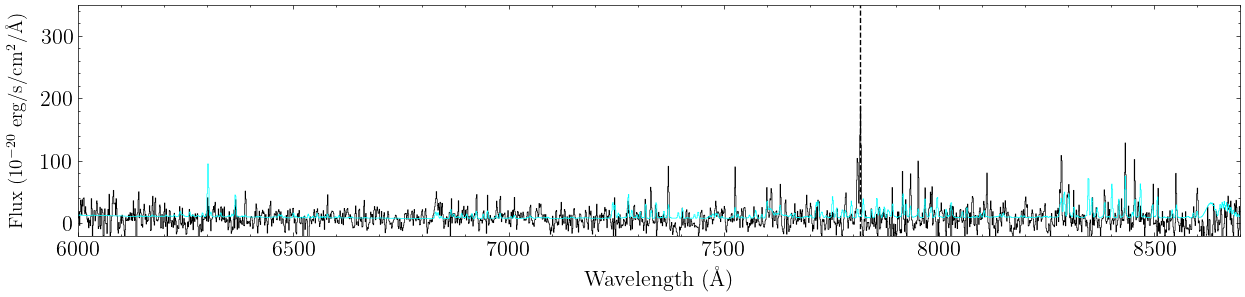

In [46]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(3729*(1+1.0959), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

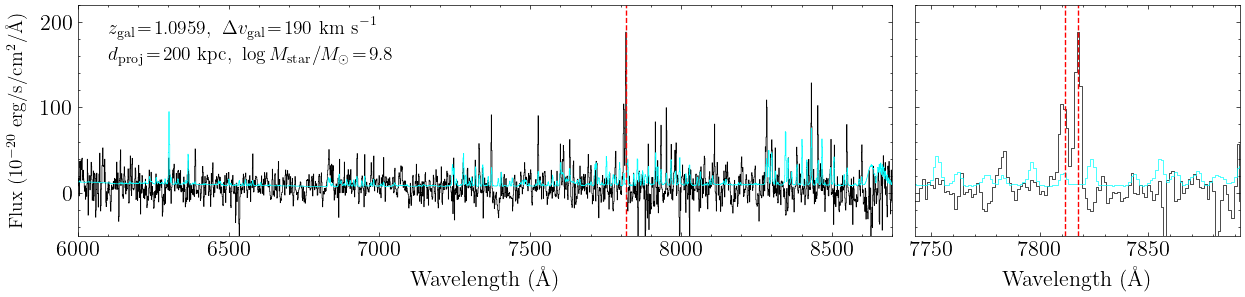

In [47]:
#fig, axes = plt.subplots(1, 2, figsize=(9,2.8), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)
fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [2.5, 1]}, sharey=True)

axes[0].step(wav_arr, spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
axes[0].text(6100, 185, 
             r'$z_\mathrm{gal}\!=\!1.0959, \ \Delta v_\mathrm{gal}\!=\!190 \ \mathrm{km \ s}^{-1}$', 
             fontsize=14)
axes[0].text(6100, 155, 
             r'$d_\mathrm{proj}\!=\!200 \ \mathrm{kpc}, \ \log M_\mathrm{star}/M_\odot \!=\!9.8$', 
             fontsize=14)
axes[0].axvline(3729.875*(1+1.0959), linestyle='--', color='red')

axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-50, 220)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

axes[1].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[1].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)

axes[1].set_xlim(3729.875*(1+1.0959)-75, 3729.875*(1+1.0959)+75)
axes[1].axvline(3727.092*(1+1.0959), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+1.0959), linestyle='--', color='red')

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.09456549/z_109_gal.pdf', dpi=300)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

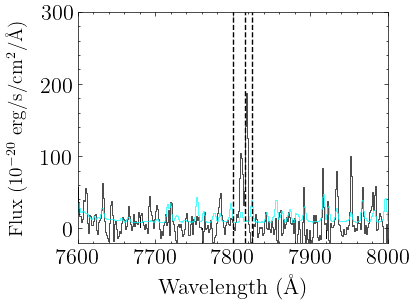

In [729]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729*(1+1.0959), linestyle='--')

ax.axvline(7800, linestyle='--')
ax.axvline(7825, linestyle='--')

ax.set_xlim(7600, 8000)
ax.set_ylim(-20, 300)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [730]:
idx = (wav_arr>=7800)&(wav_arr<=7825)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(1.166660598589806, 0.07875851084448088)

In [731]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(26.44, 0.05)

In [732]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(26.23, 0.05)

In [733]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(25.76, 0.08)

# z=1.1932

## pseudo-g

In [734]:
x0, y0 = 210.5, 268.5
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = -65*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/4.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/2.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(248.5, 288.5)

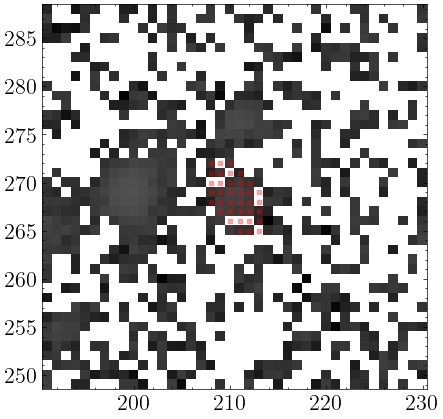

In [735]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(248.5, 288.5)

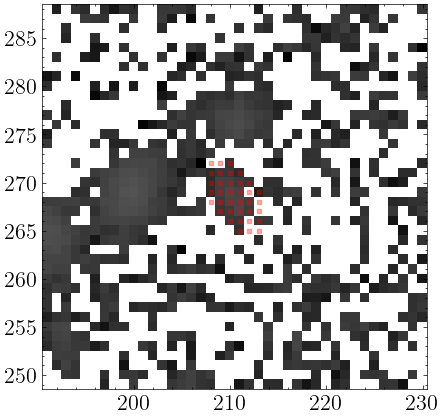

In [736]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(248.5, 288.5)

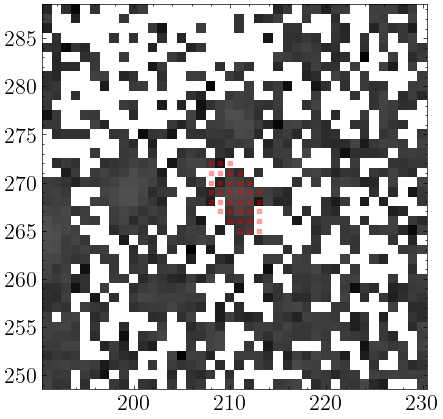

In [737]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [738]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [739]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

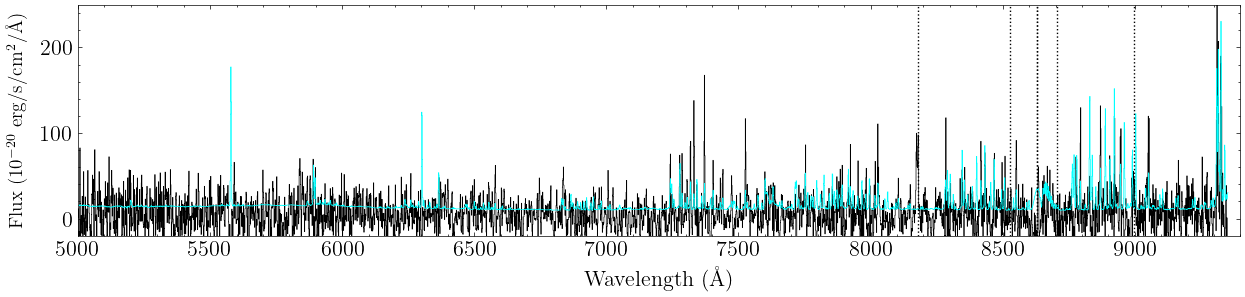

In [740]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+1.1932), linestyle=':')
ax.axvline(3889.0*(1+1.1932), linestyle=':')
ax.axvline(3934.78*(1+1.1932), linestyle=':')


ax.axvline(3934.78*(1+1.1932), linestyle=':')
ax.axvline(3969.59*(1+1.1932), linestyle=':')
ax.axvline(4102.89*(1+1.1932), linestyle=':')
ax.axvline(4305.61*(1+1.1932), linestyle=':')
ax.axvline(4341.68*(1+1.1932), linestyle=':')
ax.axvline(4862.68*(1+1.1932), linestyle=':')
ax.axvline(4960.30*(1+1.1932), linestyle=':')
ax.axvline(5008.24*(1+1.1932), linestyle=':')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 250)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

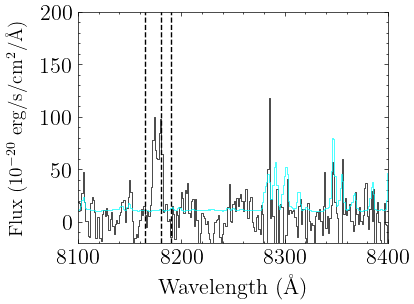

In [741]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+1.1932), linestyle='--')

ax.axvline(8165, linestyle='--')
ax.axvline(8190, linestyle='--')

ax.set_xlim(8100, 8400)
ax.set_ylim(-20, 200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [742]:
idx = (wav_arr>=8165)&(wav_arr<=8190)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.8955820456510355, 0.059877677838560246)

In [746]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],1)

(27.3, 0.2)

In [748]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(26.62, 0.09)

In [749]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],1)

(26.0, 0.1)

# z=1.1935

## pseudo-g

In [750]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==25)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 25*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/4)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/4)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(263.9594594594595, 303.9594594594595)

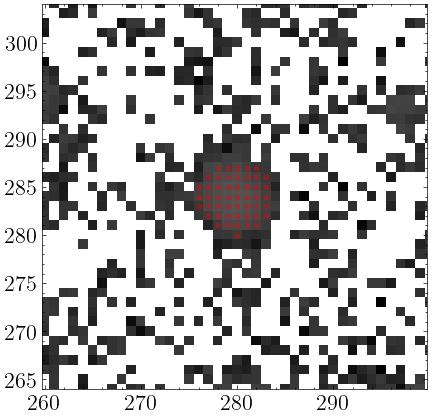

In [751]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(263.9594594594595, 303.9594594594595)

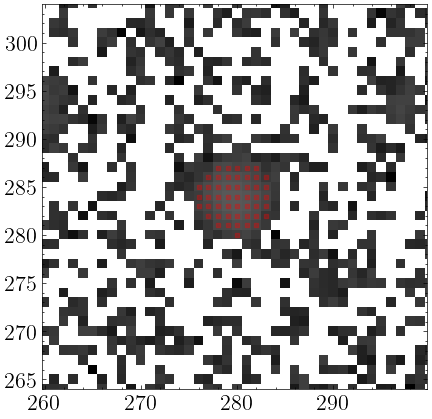

In [752]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6482/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(263.9594594594595, 303.9594594594595)

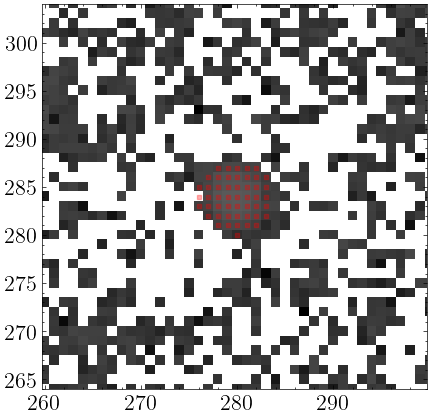

In [753]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [754]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [755]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

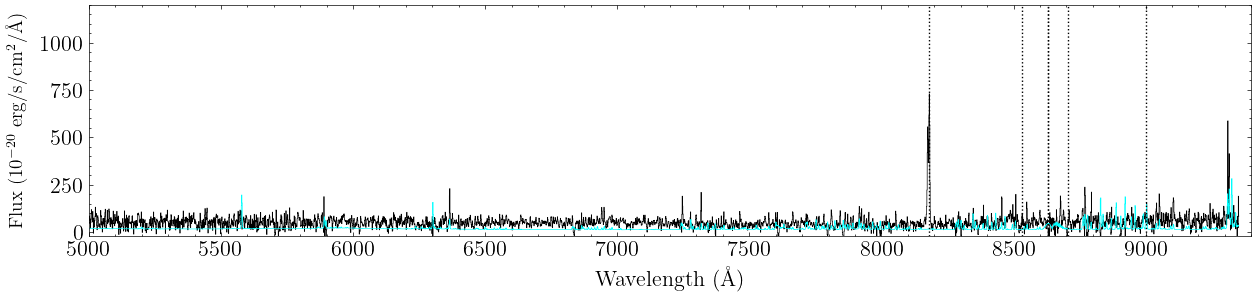

In [756]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)

ax.axvline(3729.87*(1+1.1935), linestyle=':')
ax.axvline(3889.0*(1+1.1935), linestyle=':')
ax.axvline(3934.78*(1+1.1935), linestyle=':')


ax.axvline(3934.78*(1+1.1935), linestyle=':')
ax.axvline(3969.59*(1+1.1935), linestyle=':')
ax.axvline(4102.89*(1+1.1935), linestyle=':')
ax.axvline(4305.61*(1+1.1935), linestyle=':')
ax.axvline(4341.68*(1+1.1935), linestyle=':')
ax.axvline(4862.68*(1+1.1935), linestyle=':')
ax.axvline(4960.30*(1+1.1935), linestyle=':')
ax.axvline(5008.24*(1+1.1935), linestyle=':')

ax.set_xlim(5000, 9400)
ax.set_ylim(-20, 1200)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

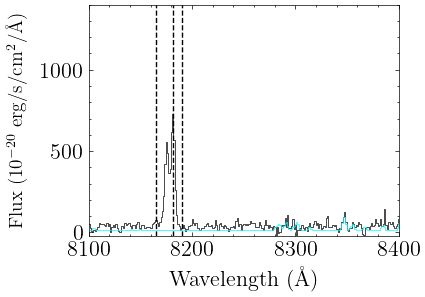

In [757]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729.87*(1+1.1935), linestyle='--')

ax.axvline(8165, linestyle='--')
ax.axvline(8190, linestyle='--')

ax.set_xlim(8100, 8400)
ax.set_ylim(-20, 1400)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [758]:
idx = (wav_arr>=8165)&(wav_arr<=8190)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(6.605644073110307, 0.07841887845501008)

In [762]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(24.7, 0.02)

In [764]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(24.26, 0.01)

In [765]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(23.8, 0.02)

# z=1.2256

## pseudo-g

In [48]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==58)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
idx = np.where((seg_map_gal_x-x0)**2+(seg_map_gal_y-y0)**2<7**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1568320792.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1568320792.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(166.7948717948718, 206.7948717948718)

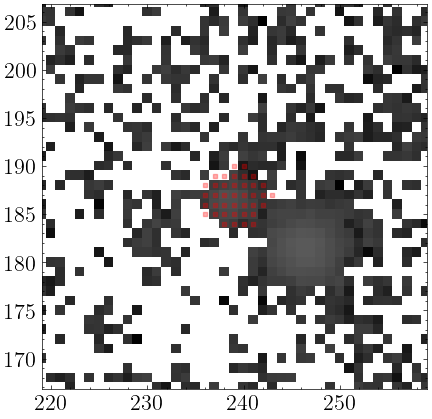

In [49]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1952758952.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1952758952.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(166.7948717948718, 206.7948717948718)

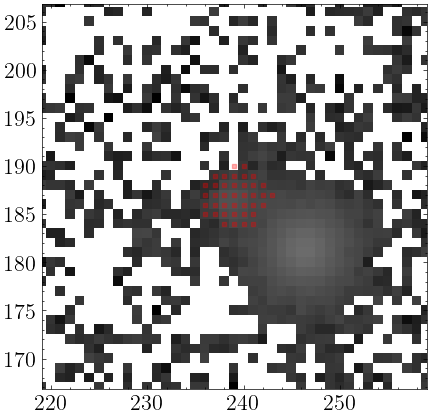

In [50]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/196516773.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/196516773.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(166.7948717948718, 206.7948717948718)

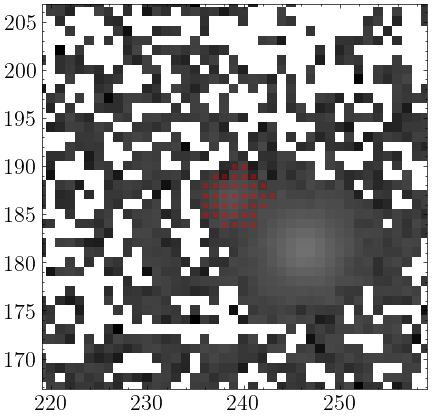

In [51]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(seg_map_gal_x[idx], seg_map_gal_y[idx], marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [52]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [53]:
spec_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))
var_stack = np.zeros((len(seg_map_gal_x[idx]), len(wav_arr)))

for j in range(len(seg_map_gal_x[idx])):

    x = seg_map_gal_x[idx][j]
    y = seg_map_gal_y[idx][j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

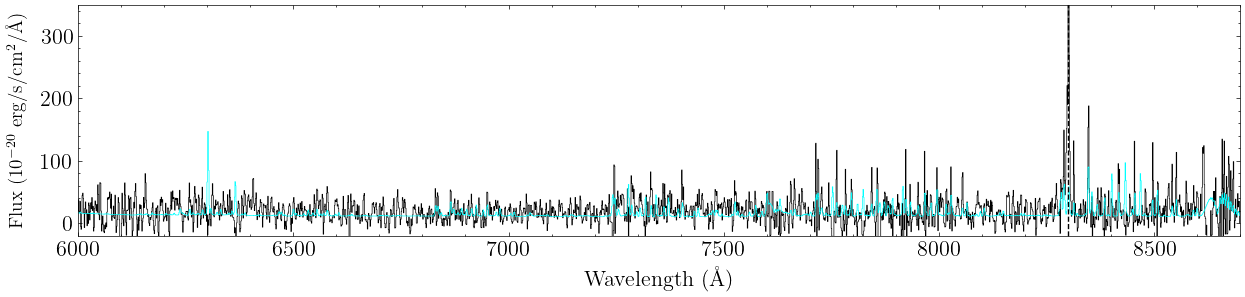

In [54]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(3729*(1+1.2256), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

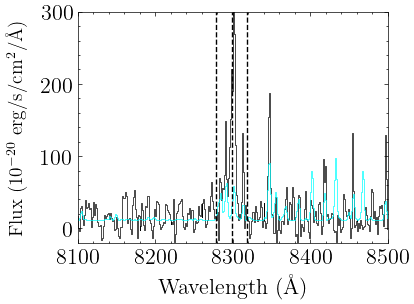

In [55]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.axvline(3729*(1+1.2256), linestyle='--')

ax.axvline(8278, linestyle='--')
ax.axvline(8318, linestyle='--')

ax.set_xlim(8100, 8500)
ax.set_ylim(-20, 300)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

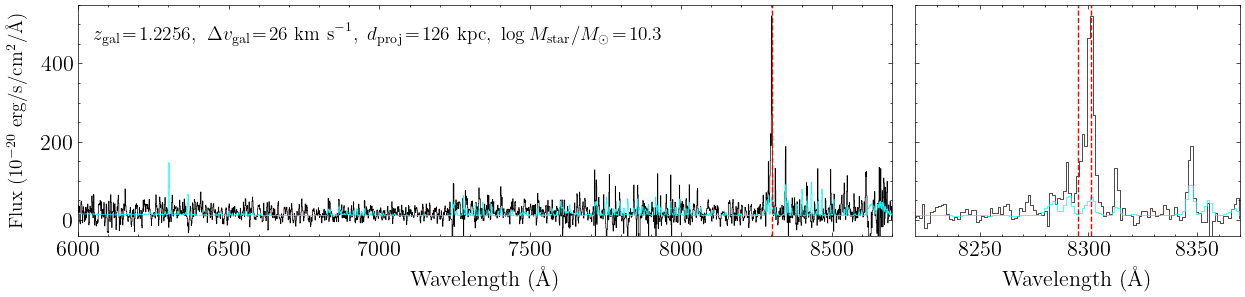

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [2.5, 1]}, sharey=True)

axes[0].step(wav_arr, spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
axes[0].text(6050, 460, 
             r'$z_\mathrm{gal}\!=\!1.2256, \ \Delta v_\mathrm{gal}\!=\! 26 \ \mathrm{km \ s}^{-1}, \ d_\mathrm{proj}\!=\!126 \ \mathrm{kpc}, \ \log M_\mathrm{star}/M_\odot \!=\!10.3$', 
             fontsize=14)
axes[0].axvline(3729.875*(1+1.2256), linestyle='--', color='red')

axes[0].set_xlim(6000, 8700)
axes[0].set_ylim(-40, 550)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[1].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)

axes[1].set_xlim(3727.092*(1+1.2256)-75, 3727.092*(1+1.2256)+75)
axes[1].axvline(3727.092*(1+1.2256), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+1.2256), linestyle='--', color='red')

axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.22541394/z_122_gal.pdf', dpi=300)

In [775]:
idx = (wav_arr>=8278)&(wav_arr<=8318)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(3.9502379524968276, 0.2366519907837949)

In [779]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(25.88, 0.05)

In [780]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(25.23, 0.03)

In [781]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(24.65, 0.04)

# z=1.2787

## pseudo-g

In [57]:
seg_map_gal_y, seg_map_gal_x = np.where(seg_map==87)
x0, y0 = np.mean(seg_map_gal_x), np.mean(seg_map_gal_y)
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
gal_y, gal_x = np.where((X-x0)**2+(Y-y0)**2<3**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/2718398477.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/2718398477.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(65.0909090909091, 105.0909090909091)

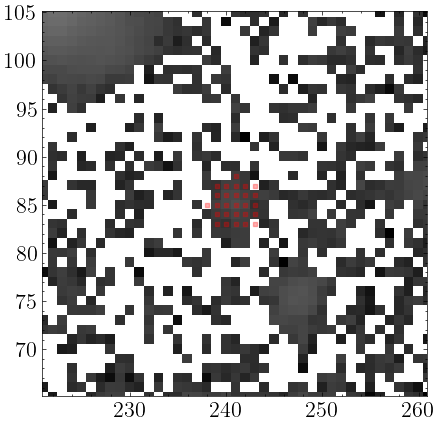

In [58]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/75025383.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/75025383.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(65.0909090909091, 105.0909090909091)

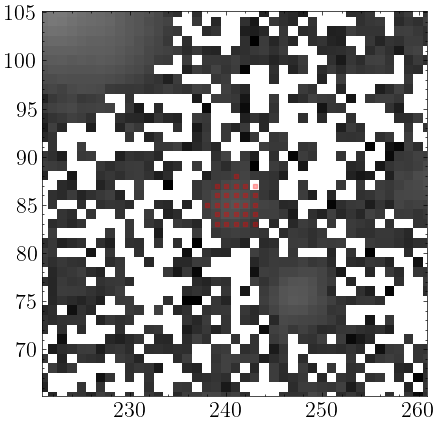

In [59]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1992103995.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_49787/1992103995.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(65.0909090909091, 105.0909090909091)

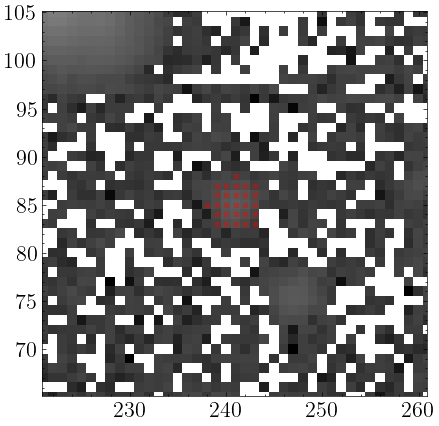

In [60]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## Composite image

In [61]:
wav_plot = 3729.875*(1+1.2787)
wav_plot_idx = np.argmin(np.abs(wav_arr-wav_plot))

In [62]:
circ_x = np.array([x0+3*np.cos(p) for p in np.arange(0.,2*np.pi+.1, .05)])
circ_y = np.array([y0+3*np.sin(p) for p in np.arange(0.,2*np.pi+.1, .05)])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.27767328/z_127_gal_img.pdf'

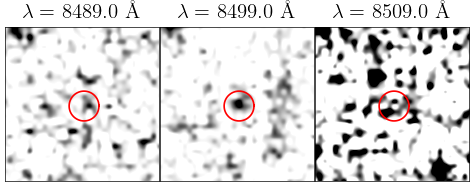

In [63]:
fig, axes = plt.subplots(1,3, figsize=(2*3,2), sharex=True, sharey=True)

axes[0].imshow(spec_cube[wav_plot_idx-8,:,:], vmin = 0, vmax = 5, cmap='Greys', interpolation='gaussian')

axes[0].set_title(r'$\lambda = $ ' + str(np.round(wav_arr[wav_plot_idx-8]))+' Å', fontsize=15)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[0].plot(circ_x, circ_y, lw=1.2, color='red')


axes[0].invert_yaxis()

axes[0].set_xlim(np.min(gal_x)-13, np.max(gal_x)+13)
axes[0].set_ylim(np.min(gal_y)-13, np.max(gal_y)+13)

axes[1].imshow(spec_cube[wav_plot_idx,:,:], vmin = 0, vmax = 5, cmap='Greys', interpolation='gaussian')
axes[1].plot(circ_x, circ_y, lw=1.2, color='red')

axes[1].set_title(r'$\lambda = $ ' + str(np.round(wav_arr[wav_plot_idx]))+' Å', fontsize=15)

axes[1].invert_yaxis()

axes[1].set_xlim(np.min(gal_x)-13, np.max(gal_x)+13)
axes[1].set_ylim(np.min(gal_y)-13, np.max(gal_y)+13)

axes[2].imshow(spec_cube[wav_plot_idx+8,:,:], vmin = 0, vmax = 5, cmap='Greys', interpolation='gaussian')
axes[2].plot(circ_x, circ_y, lw=1.2, color='red')

axes[2].set_title(r'$\lambda = $ ' + str(np.round(wav_arr[wav_plot_idx+8]))+' Å', fontsize=15)
axes[2].invert_yaxis()

axes[2].set_xlim(np.min(gal_x)-13, np.max(gal_x)+13)
axes[2].set_ylim(np.min(gal_y)-13, np.max(gal_y)+13)

plt.subplots_adjust(wspace=0., hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.27767328/z_127_gal_img.pdf', dpi=300)

## Spectrum

In [64]:
spec_gal = np.zeros(len(wav_arr))
err_gal = np.zeros(len(wav_arr))

In [65]:
spec_stack = np.zeros((len(gal_x), len(wav_arr)))
var_stack = np.zeros((len(gal_x), len(wav_arr)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal = np.nansum(spec_stack, axis=0)
err_gal = np.sqrt(np.nansum(var_stack, axis=0))

## Redshift-fit

In [895]:
eigenspec_df = pd.read_csv('/Users/thepoetoftwilight/Documents/CUBS/Data/Eigenspectra/eigen_galaxy_Bolton2012.csv')

In [896]:
wav_eigen = eigenspec_df['wav']
c1 = eigenspec_df['c1']
c2 = eigenspec_df['c2']
c3 = eigenspec_df['c3']
c4 = eigenspec_df['c4']

In [897]:
def z_shift_eigen(z, wav_arr):
    
    wav_eigen_shift = wav_eigen*(1+z)
    
    gal_ind = (wav_eigen_shift>=wav_arr[0])&(wav_eigen_shift<=wav_arr[-1])
    wav_eigen_shift_gal = wav_eigen_shift[gal_ind]
    
    c1_gal = c1[gal_ind]
    c1_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c1_gal)

    c2_gal = c2[gal_ind]
    c2_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c2_gal)
    
    c3_gal = c3[gal_ind]
    c3_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c3_gal)

    c4_gal = c4[gal_ind]
    c4_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c4_gal)
    
    return c1_gal_interp, c2_gal_interp, c3_gal_interp, c4_gal_interp

In [898]:
def best_model(c1, c2, c3, c4, y, y_err):

    A11 = np.sum((c1/y_err)**2)
    A12 = np.sum(c1*c2/y_err**2)
    A13 = np.sum(c1*c3/y_err**2)
    A14 = np.sum(c1*c4/y_err**2)
    
    A21 = np.sum(c2*c1/y_err**2)
    A22 = np.sum((c2/y_err)**2)
    A23 = np.sum(c2*c3/y_err**2)
    A24 = np.sum(c2*c4/y_err**2)
    
    A31 = np.sum(c3*c1/y_err**2)
    A32 = np.sum(c3*c2/y_err**2)
    A33 = np.sum((c3/y_err)**2)
    A34 = np.sum(c3*c4/y_err**2)
    
    A41 = np.sum(c4*c1/y_err**2)
    A42 = np.sum(c4*c2/y_err**2)
    A43 = np.sum(c4*c3/y_err**2)
    A44 = np.sum((c4/y_err)**2)
    
    b1 = np.sum(y*c1/y_err**2)
    b2 = np.sum(y*c2/y_err**2)
    b3 = np.sum(y*c3/y_err**2)
    b4 = np.sum(y*c4/y_err**2)
    
    A_mat = np.array([[A11, A12, A13, A14],[A21, A22, A23, A24],[A31, A32, A33, A34],[A41, A42, A43, A44]])
    b_vec = np.array([b1, b2, b3, b4])
    
    x_vec = np.linalg.inv(A_mat)@b_vec
    
    a = x_vec[0]
    b = x_vec[1]
    c = x_vec[2]
    d = x_vec[3]

    return a, b, c, d

In [899]:
def eval_red_chi_sq(y_hat, y, y_err, dof):
    
    return np.sum(((y-y_hat)/y_err)**2)/(len(y)-dof)

In [900]:
z_arr = np.arange(-0.1,1.4,1e-4)
red_chi_sq_arr = np.zeros(len(z_arr))

In [901]:
model_params = np.zeros((len(z_arr), 4))

In [902]:
idx = ~np.isnan(spec_gal)

In [903]:
for i in range(len(z_arr)):
    
    z = z_arr[i]
    
    c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr[idx][20:-20])
    
    a, b, c, d = best_model(c1_shift, c2_shift, c3_shift, c4_shift, 
                            spec_gal[idx][20:-20], err_gal[idx][20:-20])
    
    model_params[i,0] = a
    model_params[i,1] = b
    model_params[i,2] = c
    model_params[i,3] = d 
    
    red_chi_sq = eval_red_chi_sq(a*c1_shift+b*c2_shift+c*c3_shift+d*c4_shift, 
                                        spec_gal[idx][20:-20], err_gal[idx][20:-20], model_params.shape[1])
    
    red_chi_sq_arr[i] = red_chi_sq
    
    #print(a, b, c, d, red_chi_sq)

In [904]:
z = z_arr[np.argmin(red_chi_sq_arr)]
c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

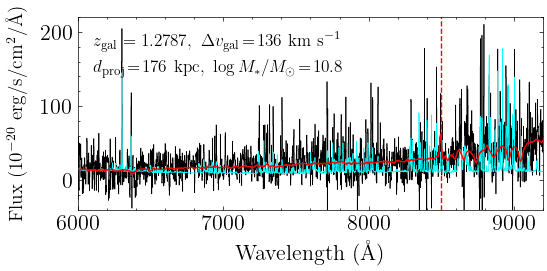

In [905]:
fig, ax = plt.subplots(1,figsize=(6,2.5))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
ax.text(6100, 180, 
             r'$z_\mathrm{gal}=1.2787, \ \Delta v_\mathrm{gal}\!=\!136 \ \mathrm{km \ s}^{-1}$', 
             fontsize=12.5)
ax.text(6100, 145, 
             r'$d_\mathrm{proj}\!=\!176 \ \mathrm{kpc}, \ \log M_*/M_\odot \!=\!10.8$', 
             fontsize=12.5)
ax.plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=1, color='red')
ax.axvline(3729.875*(1+1.2787), linestyle='--', color='red')

ax.set_xlim(6000, 9200)
ax.set_ylim(-40, 220)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.27767328/z_127_gal.pdf', dpi=300)#

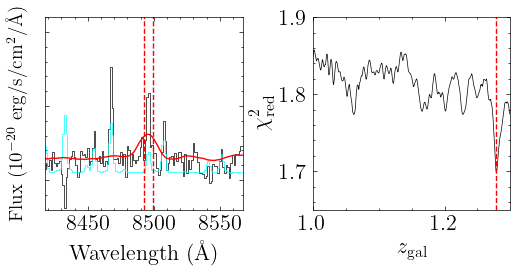

In [906]:
fig, axes = plt.subplots(1,2,figsize=(6,2.5))

axes[0].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)
axes[0].plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=1, color='red')

axes[0].set_xlim(3727.092*(1+1.2787)-75, 3727.092*(1+1.2787)+75)
axes[0].set_ylim(-40, 220)
axes[0].axvline(3727.092*(1+1.2787), linestyle='--', color='red')
axes[0].axvline(3729.875*(1+1.2787), linestyle='--', color='red')

#axes[1].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

axes[0].set_ylabel('')
axes[0].set_yticklabels([])

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)


axes[1].plot(z_arr, red_chi_sq_arr, lw=.5)
axes[1].axvline(z_arr[np.argmin(red_chi_sq_arr)],color='red', linestyle='--')

axes[1].set_xlabel(r'$z_\mathrm{gal}$')
axes[1].set_ylabel(r'$\chi^2_\mathrm{red}$')

axes[1].set_xlim(1.0,1.3)
axes[1].set_ylim(1.65,1.9)

plt.subplots_adjust(wspace=0.35, hspace=0.5)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.27767328/z_127_gal_fit.pdf', dpi=300)

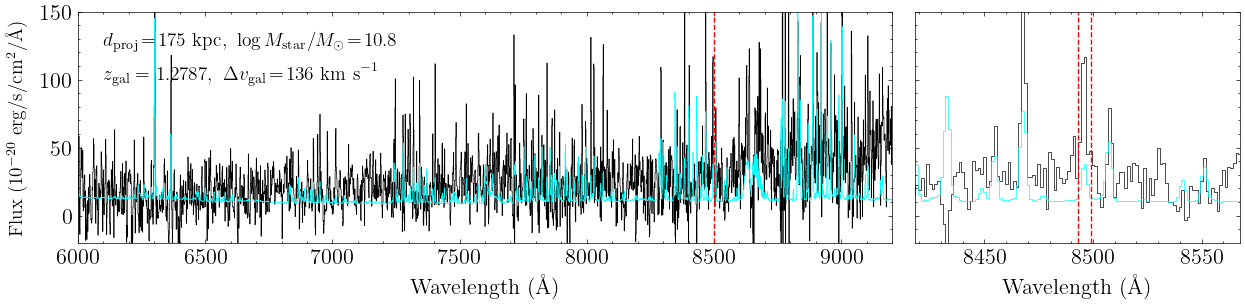

In [66]:
#fig, axes = plt.subplots(1, 2, figsize=(9,2.8), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)
fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [2.5, 1]}, sharey=True)

axes[0].step(wav_arr, spec_gal, where='mid', lw=.5)
axes[0].step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
axes[0].text(6100, 100, 
             r'$z_\mathrm{gal}=1.2787, \ \Delta v_\mathrm{gal}\!=\!136 \ \mathrm{km \ s}^{-1}$', 
             fontsize=14)
axes[0].text(6100, 125, 
             r'$d_\mathrm{proj}\!=\!175 \ \mathrm{kpc}, \ \log M_\mathrm{star}/M_\odot \!=\!10.8$', 
             fontsize=14)
axes[0].axvline(3729.875*(1+1.2787), linestyle='--', color='red')

axes[0].set_xlim(6000, 9200)
axes[0].set_ylim(-20, 150)

axes[0].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
axes[0].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

axes[1].step(wav_arr, 
              spec_gal, where='mid', lw=.5)
axes[1].step(wav_arr, 
              err_gal, where='mid', color='cyan', lw=.5)

axes[1].set_xlim(3727.092*(1+1.2787)-75, 3727.092*(1+1.2787)+75)
axes[1].axvline(3727.092*(1+1.2787), linestyle='--', color='red')
axes[1].axvline(3729.875*(1+1.2787), linestyle='--', color='red')


axes[1].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

#axes[1].set_xlim(-500,200)

plt.subplots_adjust(wspace=0.04, hspace=0.)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.27767328/z_127_gal.pdf', dpi=300)#

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

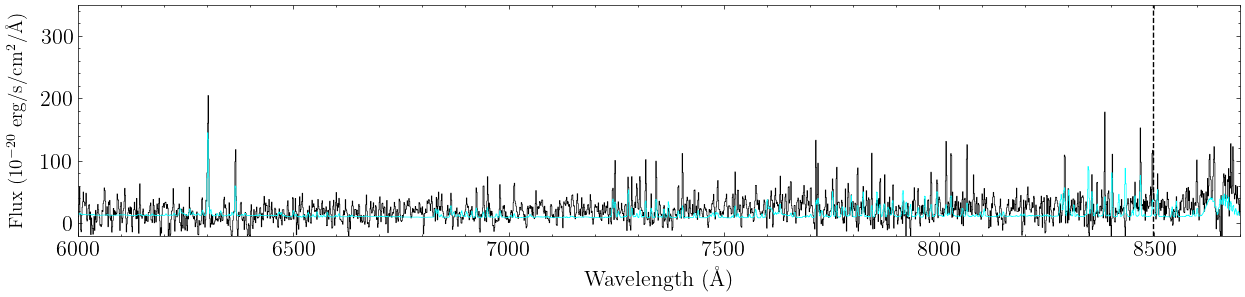

In [803]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)


ax.axvline(3729*(1+1.2787), linestyle='--')

ax.set_xlim(6000, 8700)
ax.set_ylim(-20, 350)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

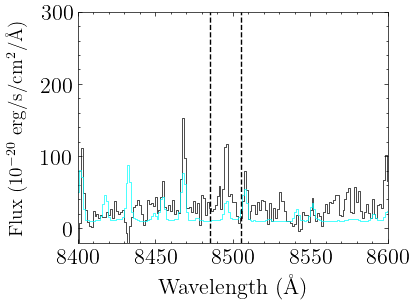

In [804]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.step(wav_arr, spec_gal, where='mid', lw=.5)
ax.step(wav_arr, err_gal, where='mid', color='cyan', lw=.5)
#ax.axvline(3729*(1+1.2787), linestyle='--')

ax.axvline(8485, linestyle='--')
ax.axvline(8505, linestyle='--')

ax.set_xlim(8400, 8600)
ax.set_ylim(-20, 300)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [805]:
idx = (wav_arr>=8485)&(wav_arr<=8505)
np.sum(spec_gal[idx][:-1])*1.25*1e-3, np.sqrt(np.sum(err_gal[idx][:-1]**2))*1.25*1e-3

(0.883033108918753, 0.08957476586534972)

In [806]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_g'],2)

(26.45, 0.06)

In [809]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_r'],2)

(25.3, 0.02)

In [810]:
calc_AB_mag(wav_arr, spec_gal, err_gal, bandpasses_lam['pseudo_i'],2)

(24.26, 0.03)